<a href="https://colab.research.google.com/github/Padasdaf/Object-Detection-Autonomous-Vehicles/blob/main/Object_Detection_for_Autonomous_Vehicles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

Today, we'll learn one of the most widely used state-of-the-art object detection algorithms -- YOLO. We'll apply this algorithm on both images and videos.

Click on the image below to see some amazing results!

[<img src="https://pjreddie.com/media/image/yologo_2.png" width="400"/>](https://www.youtube.com/watch?v=MPU2HistivI)


Let's get started!

In this notebook we'll be:
1.   Understanding YOLO
2.   Performing Bounding Box Prediction
3.   Performing Object Detection on videos


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }

import matplotlib.pyplot as plt
import os
from PIL import Image
import gdown

import argparse
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers import concatenate, add
from keras.models import Model
import struct
import cv2
from copy import deepcopy

# Prepare data
DATA_ROOT = '/content/data'
os.makedirs(DATA_ROOT, exist_ok=True)

# image_url = 'https://drive.google.com/uc?id=12ZpZ5H0kJIkWk6y4ktGfqR5OTKofL7qw'
# image_path = os.path.join(DATA_ROOT, 'image.jpg')
# gdown.download(image_url, image_path, True)
!wget -O /content/data/image.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg"

# image2_url = 'https://drive.google.com/uc?id=1_WpFbGEuS2r19UeP6wekbcF0kb-0nH18'
# image2_path = os.path.join(DATA_ROOT, 'image2.jpg')
# gdown.download(image2_url, image2_path, True)
!wget -O /content/data/image2.jpg "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg"

# video_url = 'https://drive.google.com/uc?id=1xFGjpzhZVYtNor9hJevvxysGESZJIMDz'
# video_path = os.path.join(DATA_ROOT, 'video1.mp4')
# gdown.download(video_url, video_path, True)
!wget -O /content/data/video1.mp4 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/6.mp4"

# model_url = 'https://drive.google.com/uc?id=19XKJWMKDfDlag2MR8ofjwvxhtr9BxqqN'
model_path = os.path.join(DATA_ROOT, 'yolo_weights.h5')
# gdown.download(model_url, model_path, True)
!wget -O /content/data/yolo_weights.h5 "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/yolo.h5"

labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax

        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union = w1*h1 + w2*h2 - intersect

    return float(intersect) / union

def preprocess_input(image_pil, net_h, net_w):
    image = np.asarray(image_pil)
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)/new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)/new_h
        new_h = net_h

    # resize the image to the new size
    #resized = cv2.resize(image[:,:,::-1]/255., (int(new_w), int(new_h)))
    resized = cv2.resize(image/255., (int(new_w), int(new_h)))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[int((net_h-new_h)//2):int((net_h+new_h)//2), int((net_w-new_w)//2):int((net_w+new_w)//2), :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image


def decode_netout(netout_, obj_thresh, anchors_, image_h, image_w, net_h, net_w):
    netout_all = deepcopy(netout_)
    boxes_all = []
    for i in range(len(netout_all)):
      netout = netout_all[i][0]
      anchors = anchors_[i]

      grid_h, grid_w = netout.shape[:2]
      nb_box = 3
      netout = netout.reshape((grid_h, grid_w, nb_box, -1))
      nb_class = netout.shape[-1] - 5

      boxes = []

      netout[..., :2]  = _sigmoid(netout[..., :2])
      netout[..., 4:]  = _sigmoid(netout[..., 4:])
      netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
      netout[..., 5:] *= netout[..., 5:] > obj_thresh

      for i in range(grid_h*grid_w):
          row = i // grid_w
          col = i % grid_w

          for b in range(nb_box):
              # 4th element is objectness score
              objectness = netout[row][col][b][4]
              #objectness = netout[..., :4]
              # last elements are class probabilities
              classes = netout[row][col][b][5:]

              if((classes <= obj_thresh).all()): continue

              # first 4 elements are x, y, w, and h
              x, y, w, h = netout[row][col][b][:4]

              x = (col + x) / grid_w # center position, unit: image width
              y = (row + y) / grid_h # center position, unit: image height
              w = anchors[b][0] * np.exp(w) / net_w # unit: image width
              h = anchors[b][1] * np.exp(h) / net_h # unit: image height

              box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
              #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

              boxes.append(box)

      boxes_all += boxes

    # Correct boxes
    boxes_all = correct_yolo_boxes(boxes_all, image_h, image_w, net_h, net_w)

    return boxes_all

def correct_yolo_boxes(boxes_, image_h, image_w, net_h, net_w):
    boxes = deepcopy(boxes_)
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
    return boxes

def do_nms(boxes_, nms_thresh, obj_thresh):
    boxes = deepcopy(boxes_)
    if len(boxes) > 0:
        num_class = len(boxes[0].classes)
    else:
        return

    for c in range(num_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

    new_boxes = []
    for box in boxes:
        label = -1

        for i in range(num_class):
            if box.classes[i] > obj_thresh:
                label = i
                # print("{}: {}, ({}, {})".format(labels[i], box.classes[i]*100, box.xmin, box.ymin))
                box.label = label
                box.score = box.classes[i]
                new_boxes.append(box)

    return new_boxes


from PIL import ImageDraw, ImageFont
import colorsys

def draw_boxes(image_, boxes, labels):
    image = image_.copy()
    image_w, image_h = image.size
    font = ImageFont.truetype(font='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
                    size=np.floor(3e-2 * image_h + 0.5).astype('int32'))
    thickness = (image_w + image_h) // 300

    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(labels), 1., 1.)
                  for x in range(len(labels))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.

    for i, box in reversed(list(enumerate(boxes))):
        c = box.get_label()
        predicted_class = labels[c]
        score = box.get_score()
        top, left, bottom, right = box.ymin, box.xmin, box.ymax, box.xmax

        label = '{} {:.2f}'.format(predicted_class, score)
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        #label_size = draw.textsize(label)

        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image_h, np.floor(bottom + 0.5).astype('int32'))
        right = min(image_w, np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=colors[c])
        draw.rectangle(
            [tuple(text_origin), tuple(text_origin + label_size)],
            fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        #draw.text(text_origin, label, fill=(0, 0, 0))
        del draw
    return image

--2024-07-26 04:58:53--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94721 (93K) [image/jpeg]
Saving to: ‘/content/data/image.jpg’

/content/data/image 100%[===================>]  92.50K  --.-KB/s    in 0.001s  

2024-07-26 04:58:53 (103 MB/s) - ‘/content/data/image.jpg’ saved [94721/94721]

--2024-07-26 04:58:53--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20%20Object%20Detection%20(Autonomous%20Vehicles)/image2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Milestone 1. What is YOLO?


The “You Only Look Once,” or YOLO, family of models are a series of end-to-end deep learning models designed for fast object detection, developed by Joseph Redmon, et al. and first proposed in the 2015 paper titled “[You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640).” The model has been updated since then. Today, we'll focus on YOLOv3, which is described in this very interesting [technical report](https://pjreddie.com/media/files/papers/YOLOv3.pdf). Today, we'll walk through the basic idea of the algorithm. If you'd like to know more details about it, definitely check out the papers!

The approach involves a single deep convolutional neural network (DarkNet which is based on the VGG model we used before) that splits the input into a grid of cells and each cell directly predicts a bounding box and object classification. The result is a large number of candidate bounding boxes that are consolidated into a final prediction by a post-processing step.

For example, an image may be divided into a 7×7 grid and each cell in the grid may predict 2 bounding boxes, resulting in 98 proposed bounding box predictions. The class probabilities map and the bounding boxes with confidences are then combined into a final set of bounding boxes and class labels. The image taken from the paper below summarizes the two outputs of the model.

In summary, to make object detection on one input image, the first step is a forward pass of the DarkNet; the second step is the post-processing on the DarkNet output to get the final bounding boxes prediction.

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/03/Summary-of-Predictions-made-by-YOLO-Model.png" width="600"/>











# Milestone 2. How does YOLO work?

Before we proceed to build the YOLO model, let's first define the **anchor boxes**, which are several pre-defined bounding boxes with useful shapes and sizes that are tailored based on the object shapes in the training dataset.

There are 9 anchor boxes in total. As we'll talk about later, the detection is performed on 3 scales. Therefore, the anchor boxes are divided into 3 groups, each corresponding to 1 scale.


In [ ]:
anchors = [[[116,90], [156,198], [373,326]], [[30,61], [62,45], [59,119]], [[10,13], [16,30], [33,23]]]


The 9 anchor boxes are plotted below. As you may discover, they can cover a variety of shapes and sizes.

<img src="http://www.programmersought.com/images/401/891354390c3aab3f1ab1fd0db3110bf9.png" width="400"/>

Now, let's load the image that we'll apply object detection on. To load the image, we'll use the `Image` module in the package `PIL`, which is commonly used  for image processing. The image is saved as a `PIL image` in the variable `image_pil`. We can get the width and the height of the image by accessing the `size` attribute of the image.


The type of the saved image is <class 'PIL.JpegImagePlugin.JpegImageFile'>


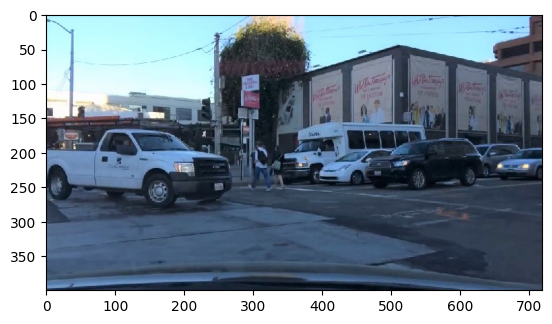

In [ ]:
from PIL import Image
from matplotlib import  pyplot as plt

image_path = '/content/data/image.jpg'

image_pil = Image.open(image_path)
image_w, image_h = image_pil.size
print("The type of the saved image is {}".format(type(image_pil)))
plt.imshow(image_pil)
plt.show()

### Exercise (Coding) | Image Preprocessing

The input size of DarkNet is `(416, 416)`, so we need to preprocess our image into the required size by resizing our image, keeping the aspect ratio consistent, and padding the left out areas with the grey color, which is `(128,128,128)` in RGB. We have implemented the preprocessing for you in the `preprocess_input(image, net_h, net_w)` function, which takes the orininal image, the target height and width `net_h, net_w` as input and returns the new image in the required size.

In the chunk below, do the preprocessing by yourself! Plot the new image to check your result


In [ ]:
### YOUR CODE HERE
net_h = 416
net_w = 416
new_image = preprocess_input(image_pil, net_h, net_w)

### END CODE

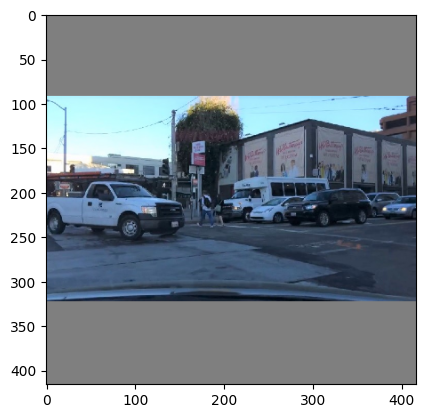

In [ ]:
#@title Run this to check the new image { display-mode: "form" }
plt.imshow(new_image[0])
plt.show()

### Exercise (Discussion) | DarkNet Architecture

**The** main part of the YOLO algorithm is the DarkNet model, which is basiclly a Convolutional Neural Network, with some special designs, like upsampling layers and detection layers.

Here is how the architecture of DarkNet looks like:


<img src="https://miro.medium.com/max/2000/1*d4Eg17IVJ0L41e7CTWLLSg.png" width="1000"/>

**The residual blocks** in the picture contain layers that are similar to the CNN models we built before, eg. convolutional layers `Conv2D`, max pooling layers `MaxPooling2D`, activation layers `Activation('relu')`. The network just stacks a lot more layers than the model we built before.





**How to make detections at 3 different scales?**

Besides the stuff that we are familiar with, the most salient feature of YOLOv3 DarkNet is that it makes detections at three different scales, which are precisely given by downsampling the dimensions of the input image by 32, 16 and 8 respectively.

The first detection is made by the 82nd layer. For the first 81 layers, the image is down sampled by the network, such that the 81st layer has a stride of 32. If we have an image of 416 x 416, the resultant feature map would be of size 13 x 13.

The feature map size at layer 94 and 106 grows bigger because of the upsampling layers. The feature maps are upsampled by 2x to dimensions of 26 x 26 and 52 x 52 respectively.

**What exactly are the DarkNet outputs?**

The eventual detection output is generated by applying detection kernels on feature maps at the three different places in the network.

For each grid cell, we'll consider several possible bounding boxes that are centered at the given grid cell. Then for each considered bounding box, the model predicts t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub>, an objectness score, and class scores.
- t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub> are related to predicting the exact position and shape of the considered bounding box.
- The objectness score is the model's prediction about how likely the considered bounding box has a complete object inside it.
- Class scores are the predicted probability over all the object classes.

Therefore, the shape of the detection kernel is 1 x 1 x (B x (4 + 1 + C)). Here, 1 x 1 means the kernel only looks at one grid cell at one time. B is the number of bounding boxes a cell on the feature map can predict, "4" is for the 4 bounding box attributes (t<sub>x</sub>, t<sub>y</sub>, t<sub>w</sub>, t<sub>h</sub>) and "1" for the object confidence. C is the number of object classes.

The model will consider bounding boxes based on the 3 anchor boxes defined before, so B = 3. As YOLO is trained on COCO (a large-scale object detection dataset), which contains 80 object catogories, C = 80. Therefore, the kernel size is 1 x 1 x 255. The feature map produced by this kernel has identical height and width of the previous feature map, and has detection attributes along the depth as described above.

The following picture illustrates how this works.

<img src="https://miro.medium.com/max/1200/0*3A8U0Hm5IKmRa6hu.png" width="500"/>



### Exercise (Coding and Discussion) | Forward Pass

Now, let's load a fully trained DarkNet model!

In [ ]:
import tensorflow as tf

# Load model
darknet = tf.keras.models.load_model(model_path)

Just as how we got the classification predictions from the perceptron, CNN, and VGG models, call the `model.predict(input_data)` function to do a forward pass on our preprocessed image `new_image`!

After you get the output, check the structure of the output and discuss what the dimensions mean with you classmates!

In [ ]:
### YOUR CODE HERE
yolo_outputs = darknet.predict(new_image)

### END CODE

1/1 [==============================] - 4s 4s/step


In [ ]:
print(len(yolo_outputs), yolo_outputs[0].shape)

3 (1, 13, 13, 255)


Answer the following questions:


*   How many elements are there in the `yolo_outputs`? Why?
*   What does each dimension of the `yolo_outputs[0]` mean?
*   Why the last dimension is 255?

If you are clear about the questions above, now you can definitely explain how the DarkNet works to your classmates! (At each detection scale, ... For each grid cell, ... For each bounding boxes, ...)

# Milestone 3. Bounding Box Prediction

We now have DarkNet's detection predictions for all the possible bounding boxes centered at each grid cell position, but to get the final detection results, which are the bounding boxes that the model is confident of, we need to apply a threshold to filter the results.

Besides, as you can imagine, there might be multiple bounding boxes that are detecting the same object. We need to remove the overlapping bounding boxes and only leave the best ones.

Here are some post-processing steps:



*   `decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)` takes the DarkNet output feature maps `yolo_outputs` as input, and returns all the predicted bounding boxes that have a higher objectness than the objectness threshold `obj_thresh`
*   `do_nms(boxes, nms_thresh, obj_thresh)` means Non-Maximal Suppression, which a commonly used post-processing step for object detection. It  removes  all the bounding boxes that have a big (higher overlap than the `nms_thresh`) overlap with other better bounding boxes.
*   `draw_boxes(image_pil, boxes, labels)` draws the final bounding boxes on the input image and return the detection image as a `PIL image`.


### Exercise (Coding) | Post-processing for bounding box prediction

First, let's define the thresholds mentioned above:

In [ ]:
obj_thresh = 0.4
nms_thresh = 0.45

Make use of the functions above to get our final detection bounding boxes and plot the result you get!


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.93 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.43 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
bus 0.91 (353, 153) (555, 233)
truck 0.95 (0, 161) (268, 278)


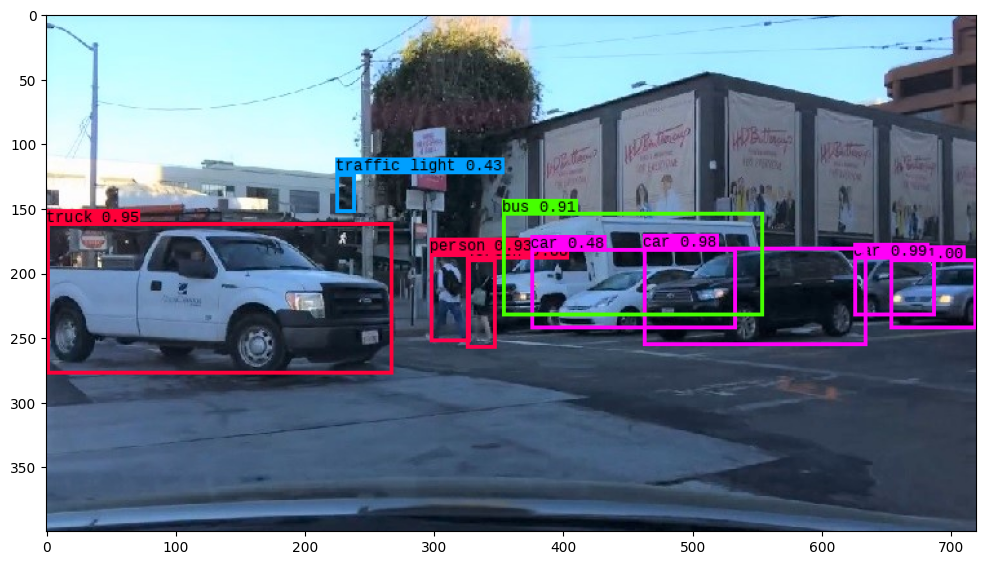

In [ ]:
### YOUR CODE HERE
boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)
boxes = do_nms(boxes, nms_thresh, obj_thresh)
image_detect = draw_boxes(image_pil, boxes, labels)
plt.figure(figsize=(12,12))
plt.imshow(image_detect)
plt.show()
### END CODE

### Exercise (Coding) | Non-Maximal Suppression

Good job! Are you curious about what each post-processing step is doing? You can explore this by yourself!

As a hint, you can...

*   Check the number of boxes after each step
*   Call the `draw_boxes(image_pil, boxes, labels)` function to visualize the bounding boxes after each step

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.51 (325, 203) (348, 256)
car 0.96 (666, 191) (720, 241)
car 1.00 (653, 189) (720, 243)
car 0.84 (623, 190) (685, 239)
car 0.22 (621, 190) (677, 239)
car 0.10 (403, 195) (492, 247)
car 0.13 (393, 200) (484, 247)
person 0.88 (325, 189) (348, 258)
person 0.10 (311, 189) (339, 253)
person 0.93 (297, 185) (328, 253)
car 0.26 (669, 190) (719, 233)
car 0.90 (650, 187) (720, 237)
car 0.28 (632, 186) (707, 231)
car 0.99 (625, 187) (688, 233)
car 0.69 (618, 189) (678, 233)
backpack 0.10 (303, 191) (320, 217)
person 0.11 (101, 178) (125, 199)
person 0.17 (93, 178) (116, 199)
traffic light 0.12 (281, 155) (294, 175)
traffic light 0.08 (220, 118) (242, 158)
traffic light 0.43 (224, 123) (239, 153)
traffic light 0.07 (45, 133) (55, 150)
car 0.07 (467, 195) (629, 261)
car 0.60 (632, 186) (720, 238)
car 0.46 (614, 185) (697, 234)
car 0.95 (478, 180) (634, 255)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
car 0.29 (350, 184) (516, 243)
person 0.46 (296, 184) (342, 258)
bus 0.9

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)


truck 0.21 (3, 156) (195, 266)


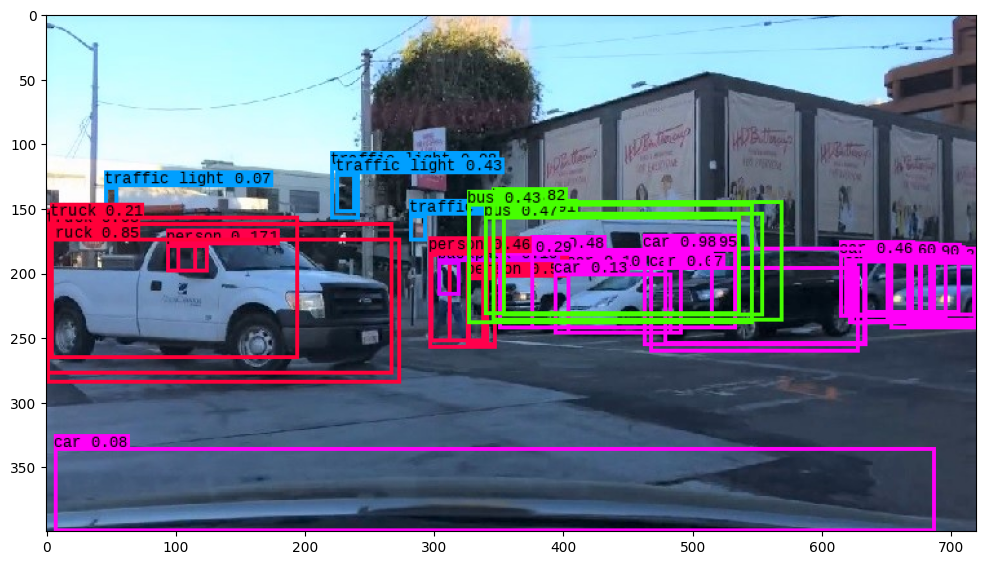

In [ ]:
### YOUR CODE HERE
boxes = decode_netout(yolo_outputs, 0.05, anchors, image_h, image_w, net_h, net_w)
image_detect = draw_boxes(image_pil, boxes, labels)
plt.figure(figsize=(12,12))
plt.imshow(image_detect)
plt.show()
boxes = do_nms(boxes, nms_thresh, obj_thresh)
### END CODE

### Exercise (Coding) | Image Detection Function

Our final goal is to detect objects in a video, which contains multiple frames (images). For better reusability and modularity, let's wrap all the code we wrote before in a function called `detect_image`, which takes the raw `PIL image` (without preprocessing) and other parameters as input, and returns the `PIl image` with detected bounding boxes and labels. Complete this function by yourself and test it

In [ ]:
def detect_image(image_pil, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
  ### YOUR CODE HERE
  image_w, image_h = image_pil.size
  new_image = preprocess_input(image_pil, net_h, net_w)
  yolo_outputs = darknet.predict(new_image)
  boxes = decode_netout(yolo_outputs, obj_thresh, anchors, image_h, image_w, net_h, net_w)
  boxes = do_nms(boxes, nms_thresh, obj_thresh)
  image_detect = draw_boxes(image_pil, boxes, labels)
  return image_detect
  ### END CODE

1/1 [==============================] - 0s 28ms/step
car 1.00 (653, 189) (720, 243)
person 0.88 (325, 189) (348, 258)
person 0.93 (297, 185) (328, 253)
car 0.99 (625, 187) (688, 233)
traffic light 0.43 (224, 123) (239, 153)
car 0.98 (462, 180) (635, 256)
car 0.48 (375, 181) (534, 243)
bus 0.91 (353, 153) (555, 233)
truck 0.95 (0, 161) (268, 278)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

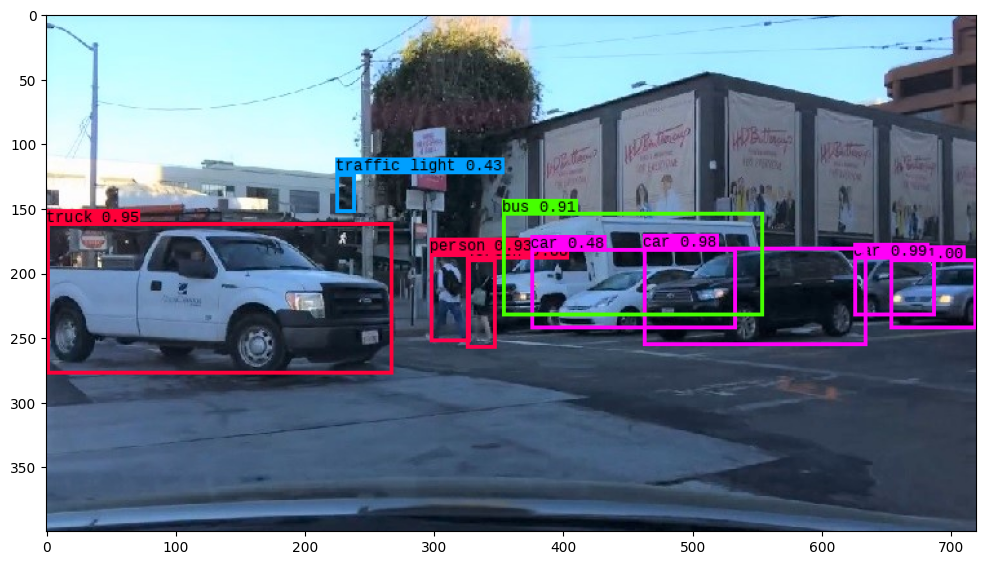

In [ ]:
#@title Run this to check your function definition { display-mode: "form" }
plt.figure(figsize=(12,12))
plt.imshow(detect_image(image_pil))
plt.show()

### Exercise (Discussion) | Thresholds

Up till now, We used default values for the 2 thresholds, `objectness threshold` and `nms_threshold`. Do you understand what these 2 thresholds control? Make use of the `detect_image`function we defined above, try different values for the 2 thresholds in the range of 0-1 and see the changes in the results. Then discuss this with your classmates!

# Milestone 4. Detection on Videos

A video is just a sequence of frames (images). Therefore, once we can use YOLO to detect objects on images, it's easy to extend this to videos. To deal with videos, we'll use the OpenCV package, which is called `cv2` in Python. If you are interested to know more, here is a [tutorial](https://docs.opencv.org/4.5.2/d0/de3/tutorial_py_intro.html).

The code below will open one video, create a new video file, read the input video frame-by-frame, and write each frame into the new video.

Now modify the code by yourself to get the object detection result on the input video!

Remember that the image input for the `detect_image` function is a `PIL image`, but here we are loading the input video using `OpenCV`. These 2 image formats are different, so we need to convert `OpenCV` to `PIL` for detection, and convert back to write the frame into the new video.

The conversion can be done as follows
```
# OpenCV -> PIL
image_pil = Image.fromarray(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))

# PIL -> OpenCV
image_cv2 = cv2.cvtColor(np.asarray(image_pil), cv2.COLOR_RGB2BGR)

```

In [ ]:
import cv2

def detect_video(video_path, output_path, obj_thresh = 0.4, nms_thresh = 0.45, darknet=darknet, net_h=416, net_w=416, anchors=anchors, labels=labels):
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'mp4v')
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

    out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)

    num_frame = 0
    while vid.isOpened():
      ret, frame = vid.read()
      num_frame += 1
      print("=== Frame {} ===".format(num_frame))
      if ret:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          image = Image.fromarray(frame)
          image = detect_image(image)
          new_frame = np.array(image)
          new_frame = cv2.cvtColor(new_frame, cv2.COLOR_RGB2BGR)
          out.write(new_frame)
      else:
          break
    vid.release()
    out.release()
    print("New video saved!")

Now test your code! You can check the videos in the FILES on the left

In [17]:
video_path = '/content/data/video.mp4'
output_path = '/content/data/video_detected.mp4'
detect_video(video_path, output_path)

=== Frame 1 ===
1/1 [==============================] - 0s 26ms/step
person 0.65 (1015, 298) (1046, 346)
car 0.96 (844, 285) (938, 357)
car 0.97 (708, 287) (795, 354)
motorbike 0.82 (647, 300) (675, 340)
person 0.91 (1078, 273) (1105, 327)
car 0.67 (776, 276) (829, 315)
car 0.65 (731, 263) (827, 320)
person 0.88 (319, 255) (358, 336)
person 0.58 (301, 265) (325, 329)
person 0.88 (171, 254) (206, 335)
person 0.96 (112, 251) (152, 362)
person 0.91 (992, 253) (1010, 303)
person 0.60 (915, 241) (932, 290)
car 0.53 (607, 252) (665, 285)
person 0.93 (265, 241) (301, 323)
person 0.41 (966, 235) (978, 275)
person 0.50 (868, 235) (879, 266)
person 0.42 (845, 232) (858, 264)
car 0.44 (687, 234) (718, 258)
person 0.46 (599, 233) (612, 261)
bus 0.59 (770, 195) (821, 269)
traffic light 0.55 (724, 194) (734, 212)
traffic light 0.58 (549, 184) (562, 208)
traffic light 0.48 (801, 157) (815, 181)
bicycle 0.81 (308, 386) (393, 541)
car 1.00 (1025, 360) (1277, 519)
car 0.99 (767, 310) (921, 451)
car 0.98 

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (873, 303) (990, 370)
person 0.79 (1055, 283) (1099, 371)
car 0.98 (708, 289) (796, 354)
motorbike 0.59 (649, 299) (671, 336)
person 0.93 (86, 265) (125, 373)
person 0.73 (1091, 264) (1115, 324)
car 0.92 (786, 274) (866, 323)
person 0.56 (648, 274) (674, 334)
person 0.90 (311, 261) (342, 347)
person 0.91 (270, 246) (311, 341)
person 0.85 (188, 257) (219, 334)
person 0.88 (996, 249) (1014, 305)
person 0.85 (914, 244) (933, 293)
car 0.74 (661, 258) (743, 302)
person 0.65 (351, 241) (370, 296)
person 0.40 (865, 239) (878, 270)
person 0.48 (844, 233) (859, 268)
car 0.76 (729, 244) (769, 268)
person 0.41 (597, 231) (609, 263)
traffic light 0.86 (723, 194) (732, 212)
traffic light 0.45 (549, 185) (562, 209)
traffic light 0.45 (800, 157) (815, 184)
car 0.85 (1154, 417) (1280, 622)
bicycle 0.79 (284, 388) (378, 555)
bicycle 0.55 (316, 370) (396, 527)
car 0.99 (767, 311) (923, 455)
car 0.93 (799, 362) (1109, 610)
=== Frame 3 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (1118, 299) (1164, 394)
car 0.97 (710, 282) (791, 354)
motorbike 0.55 (650, 298) (671, 333)
person 0.81 (63, 275) (105, 381)
person 0.56 (1097, 261) (1128, 342)
person 0.59 (648, 274) (675, 331)
person 0.91 (293, 257) (329, 347)
person 0.93 (270, 251) (306, 345)
person 0.56 (214, 258) (248, 345)
person 0.75 (1007, 253) (1028, 305)
person 0.87 (914, 241) (933, 294)
person 0.45 (891, 249) (905, 282)
person 0.43 (365, 250) (383, 297)
person 0.47 (967, 237) (978, 273)
person 0.42 (863, 234) (876, 271)
person 0.78 (843, 229) (859, 271)
person 0.41 (822, 235) (833, 265)
car 0.57 (727, 242) (764, 269)
car 0.43 (714, 238) (741, 264)
car 0.83 (687, 235) (715, 259)
traffic light 0.70 (723, 194) (732, 210)
bicycle 0.77 (284, 390) (377, 554)
bicycle 0.50 (316, 372) (396, 528)
car 0.99 (767, 303) (921, 456)
car 0.95 (796, 360) (1105, 611)
=== Frame 4 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.92 (1200, 322) (1252, 419)
car 0.99 (871, 291) (976, 367)
car 0.98 (707, 282) (794, 355)
motorbike 0.64 (647, 297) (670, 332)
person 0.91 (36, 270) (82, 384)
person 0.57 (1114, 257) (1144, 339)
car 0.90 (779, 276) (868, 320)
motorbike 0.65 (646, 274) (674, 328)
motorbike 0.65 (646, 274) (674, 328)
person 0.95 (284, 257) (322, 355)
person 0.81 (245, 266) (284, 349)
person 0.75 (225, 258) (252, 345)
person 0.80 (1011, 253) (1034, 308)
person 0.81 (913, 246) (934, 294)
person 0.50 (893, 250) (907, 283)
car 0.87 (570, 251) (626, 289)
person 0.52 (965, 238) (979, 275)
person 0.67 (846, 233) (861, 274)
car 0.66 (723, 240) (771, 271)
car 0.76 (687, 235) (713, 257)
car 0.41 (676, 234) (691, 252)
car 0.40 (636, 231) (652, 249)
bus 0.81 (733, 197) (817, 264)
bicycle 0.76 (283, 391) (380, 554)
car 1.00 (992, 354) (1239, 503)
bicycle 0.46 (316, 372) (397, 528)
car 0.99 (771, 308) (919, 451)
car 0.99 (795, 368) (1105, 605)
=== Frame 5 ===
1/1 [==============================] - 0s 24ms/step

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (930, 306) (1055, 389)
car 0.98 (708, 286) (793, 355)
motorbike 0.81 (647, 295) (673, 332)
person 0.95 (264, 268) (303, 361)
person 0.91 (231, 272) (271, 356)
person 0.90 (6, 266) (53, 392)
person 0.54 (1251, 248) (1280, 337)
person 0.81 (1129, 274) (1154, 339)
car 0.70 (824, 281) (916, 330)
person 0.73 (646, 281) (674, 331)
person 0.72 (304, 265) (326, 318)
person 0.50 (1017, 252) (1037, 302)
person 0.72 (912, 247) (929, 297)
person 0.52 (894, 249) (909, 285)
car 0.45 (672, 254) (716, 289)
car 0.75 (612, 255) (659, 290)
person 0.59 (966, 237) (978, 276)
person 0.81 (841, 233) (857, 277)
car 0.73 (723, 240) (770, 273)
car 0.51 (687, 239) (719, 263)
person 0.50 (600, 231) (611, 263)
bus 0.90 (732, 197) (817, 266)
traffic light 0.44 (723, 194) (733, 210)
car 0.47 (1117, 419) (1280, 619)
bicycle 0.82 (281, 392) (379, 550)
bicycle 0.46 (318, 377) (398, 525)
car 0.98 (765, 307) (934, 454)
car 0.99 (795, 357) (1104, 606)
=== Frame 6 ===
1/1 [==============================] - 0s 25ms

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (872, 292) (977, 357)
car 0.99 (706, 288) (791, 362)
motorbike 0.89 (644, 301) (670, 336)
person 0.98 (244, 267) (289, 370)
person 0.93 (214, 277) (253, 366)
person 0.44 (1237, 274) (1263, 328)
person 0.74 (1028, 269) (1051, 321)
person 0.81 (643, 276) (670, 328)
person 0.90 (965, 247) (981, 293)
person 0.83 (912, 247) (928, 292)
person 0.72 (895, 247) (908, 287)
person 0.79 (847, 244) (863, 285)
car 0.71 (729, 248) (767, 278)
car 0.75 (663, 252) (739, 302)
bus 0.60 (763, 213) (818, 277)
car 0.47 (683, 238) (711, 260)
car 0.55 (624, 236) (641, 256)
person 0.56 (600, 237) (612, 265)
bicycle 0.76 (284, 394) (381, 555)
car 0.98 (968, 340) (1182, 467)
car 0.98 (760, 321) (901, 455)
car 0.98 (791, 355) (1101, 609)
=== Frame 7 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (917, 309) (1042, 385)
car 0.98 (704, 288) (795, 364)
motorbike 0.95 (642, 301) (670, 340)
person 0.97 (235, 281) (269, 383)
person 0.97 (197, 285) (235, 379)
person 0.90 (642, 276) (670, 333)
person 0.63 (319, 260) (343, 319)
person 0.90 (266, 266) (289, 329)
person 0.73 (966, 252) (982, 296)
person 0.69 (932, 250) (948, 299)
person 0.84 (913, 251) (930, 305)
person 0.77 (893, 251) (909, 297)
person 0.53 (863, 250) (878, 287)
person 0.58 (845, 246) (865, 287)
car 0.77 (766, 252) (819, 285)
car 0.81 (720, 258) (766, 280)
car 0.41 (689, 253) (715, 274)
bus 0.46 (765, 220) (818, 284)
car 0.61 (686, 245) (711, 267)
car 0.55 (641, 236) (657, 250)
car 0.77 (620, 238) (643, 257)
car 0.99 (1048, 384) (1280, 558)
bicycle 0.81 (305, 398) (394, 540)
car 0.99 (762, 323) (900, 459)
car 0.92 (796, 366) (1100, 626)
=== Frame 8 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (703, 301) (797, 378)
person 0.99 (210, 292) (257, 395)
person 0.97 (170, 296) (212, 389)
person 0.68 (1039, 290) (1059, 340)
car 0.91 (769, 289) (846, 344)
motorbike 0.90 (641, 299) (669, 345)
motorbike 0.90 (641, 299) (669, 345)
person 0.63 (915, 264) (930, 315)
person 0.51 (338, 260) (363, 323)
person 0.45 (295, 280) (318, 331)
person 0.77 (278, 272) (303, 332)
person 0.47 (967, 257) (979, 302)
person 0.47 (937, 256) (951, 306)
person 0.66 (863, 256) (875, 296)
person 0.75 (843, 254) (856, 290)
car 0.90 (725, 262) (766, 291)
car 0.82 (685, 256) (715, 281)
car 0.57 (673, 255) (693, 272)
person 0.47 (599, 254) (611, 283)
car 0.56 (641, 244) (653, 257)
car 0.55 (627, 245) (642, 262)
bicycle 0.82 (310, 402) (391, 547)
car 0.98 (972, 337) (1142, 439)
car 0.99 (757, 327) (901, 463)
truck 0.58 (785, 384) (1101, 641)
car 0.82 (784, 373) (1101, 623)
=== Frame 9 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (705, 305) (791, 378)
person 0.99 (192, 297) (236, 404)
person 0.98 (154, 302) (194, 402)
person 0.42 (1230, 286) (1255, 341)
person 0.79 (1182, 270) (1218, 382)
person 0.60 (1052, 291) (1075, 340)
car 0.98 (793, 298) (894, 359)
motorbike 0.91 (639, 299) (664, 344)
motorbike 0.91 (639, 299) (664, 344)
person 0.72 (939, 266) (952, 313)
person 0.84 (914, 263) (928, 317)
person 0.77 (365, 266) (382, 323)
person 0.81 (348, 270) (368, 324)
person 0.90 (292, 278) (318, 336)
person 0.60 (861, 258) (874, 298)
person 0.53 (843, 257) (855, 291)
car 0.89 (723, 264) (767, 295)
car 0.78 (685, 259) (715, 283)
car 0.68 (670, 257) (692, 275)
car 0.51 (639, 246) (653, 259)
car 0.55 (626, 245) (643, 261)
bicycle 0.88 (310, 404) (390, 549)
car 1.00 (1052, 366) (1276, 497)
car 0.98 (760, 318) (899, 462)
truck 0.52 (780, 383) (1099, 647)
car 0.91 (784, 375) (1092, 625)
=== Frame 10 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.91 (127, 312) (171, 414)
person 0.65 (1198, 307) (1235, 384)
car 0.98 (840, 306) (951, 387)
car 0.98 (704, 306) (787, 379)
person 0.52 (217, 307) (240, 367)
person 0.98 (167, 300) (216, 414)
person 0.74 (1230, 283) (1253, 346)
person 0.76 (1054, 289) (1076, 345)
motorbike 0.88 (634, 304) (657, 343)
motorbike 0.88 (634, 304) (657, 343)
person 0.77 (302, 285) (326, 342)
person 0.76 (963, 269) (977, 314)
person 0.87 (944, 265) (960, 318)
person 0.81 (913, 264) (928, 316)
person 0.46 (631, 287) (657, 322)
person 0.54 (364, 269) (384, 324)
person 0.60 (346, 275) (365, 322)
person 0.43 (843, 258) (857, 294)
bus 0.52 (761, 236) (820, 295)
car 0.91 (723, 264) (765, 294)
car 0.79 (686, 260) (715, 284)
car 0.47 (673, 259) (692, 276)
person 0.68 (599, 260) (611, 289)
car 0.63 (641, 248) (656, 260)
car 0.60 (626, 248) (641, 263)
bicycle 0.81 (309, 406) (392, 549)
car 0.91 (754, 332) (905, 464)
car 0.92 (790, 379) (1099, 620)
=== Frame 11 ===
1/1 [==============================] - 0s 24ms/

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (884, 326) (1024, 399)
person 0.99 (143, 301) (192, 425)
person 0.98 (91, 315) (144, 424)
person 0.62 (68, 328) (102, 415)
person 0.93 (1216, 305) (1256, 389)
car 0.97 (701, 306) (786, 378)
person 0.65 (1060, 294) (1084, 345)
motorbike 0.86 (623, 304) (646, 338)
person 0.87 (962, 267) (977, 316)
person 0.68 (913, 266) (928, 318)
person 0.46 (366, 274) (382, 321)
person 0.65 (348, 271) (366, 322)
person 0.47 (317, 275) (337, 330)
person 0.54 (843, 257) (856, 295)
car 0.74 (724, 266) (772, 297)
car 0.73 (685, 260) (717, 285)
car 0.55 (671, 260) (690, 276)
person 0.75 (600, 257) (611, 287)
person 0.59 (573, 256) (584, 295)
bus 0.75 (727, 222) (814, 289)
car 0.63 (642, 248) (655, 259)
car 0.41 (626, 248) (637, 260)
traffic light 0.53 (550, 211) (560, 231)
bicycle 0.81 (311, 406) (391, 552)
car 0.99 (759, 334) (900, 466)
car 0.96 (785, 373) (1095, 626)
=== Frame 12 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (109, 305) (166, 433)
person 0.98 (61, 317) (112, 429)
person 0.93 (1231, 299) (1269, 397)
car 0.93 (695, 294) (774, 364)
motorbike 0.94 (620, 299) (640, 331)
person 0.84 (963, 271) (980, 319)
person 0.50 (913, 267) (929, 318)
motorbike 0.42 (624, 282) (644, 323)
motorbike 0.42 (624, 282) (644, 323)
person 0.50 (346, 272) (366, 322)
person 0.61 (319, 275) (341, 329)
person 0.70 (842, 257) (856, 295)
car 0.42 (772, 260) (818, 297)
car 0.80 (725, 266) (772, 299)
car 0.77 (684, 260) (716, 286)
car 0.56 (673, 261) (692, 278)
person 0.72 (601, 258) (613, 289)
person 0.61 (574, 256) (587, 297)
bus 0.67 (728, 223) (814, 289)
car 0.67 (641, 248) (655, 259)
car 0.45 (626, 248) (637, 261)
bicycle 0.80 (310, 404) (391, 552)
car 1.00 (940, 336) (1134, 457)
car 0.99 (757, 335) (900, 465)
car 0.97 (782, 370) (1099, 624)
=== Frame 13 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.91 (27, 330) (84, 443)
person 0.99 (78, 307) (133, 448)
person 0.93 (1249, 308) (1278, 399)
person 0.89 (1085, 291) (1113, 350)
car 0.97 (690, 298) (768, 359)
person 0.84 (965, 271) (983, 318)
person 0.80 (912, 265) (931, 320)
car 0.73 (727, 271) (783, 303)
motorbike 0.71 (627, 284) (647, 322)
motorbike 0.71 (627, 284) (647, 322)
person 0.44 (327, 266) (349, 326)
person 0.52 (842, 256) (856, 297)
bus 0.41 (767, 237) (821, 296)
car 0.81 (684, 263) (716, 287)
car 0.48 (672, 263) (690, 279)
person 0.41 (622, 258) (634, 279)
person 0.67 (600, 258) (612, 289)
person 0.57 (576, 256) (588, 297)
bicycle 0.82 (311, 404) (391, 551)
car 1.00 (1015, 366) (1276, 525)
car 0.99 (751, 330) (891, 463)
truck 0.55 (794, 376) (1097, 656)
car 0.90 (799, 368) (1089, 629)
=== Frame 14 ===


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 31ms/step
bicycle 0.46 (327, 417) (383, 530)
person 0.93 (2, 327) (54, 457)
person 0.51 (1258, 282) (1280, 411)
car 0.98 (688, 297) (752, 352)
person 0.93 (967, 267) (984, 321)
person 0.84 (913, 266) (929, 322)
person 0.50 (887, 275) (903, 312)
car 0.82 (742, 274) (793, 304)
motorbike 0.82 (634, 281) (652, 314)
person 0.43 (579, 276) (589, 304)
car 0.60 (711, 267) (740, 294)
car 0.88 (686, 263) (715, 288)
car 0.44 (672, 262) (689, 278)
person 0.63 (599, 262) (610, 288)
person 0.51 (577, 259) (588, 297)
person 0.45 (521, 261) (533, 297)
car 0.49 (642, 251) (655, 261)
car 0.94 (1140, 403) (1280, 598)
bicycle 0.84 (288, 411) (378, 564)
car 0.98 (743, 325) (874, 453)
person 0.87 (39, 312) (112, 460)
truck 0.85 (778, 393) (1083, 631)
car 0.47 (781, 380) (1069, 616)
=== Frame 15 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.52 (328, 417) (384, 530)
car 1.00 (728, 323) (851, 428)
person 0.61 (1109, 292) (1137, 357)
car 0.94 (681, 291) (740, 342)
person 0.72 (982, 278) (1000, 321)
person 0.76 (968, 272) (984, 318)
person 0.85 (913, 266) (930, 323)
car 0.97 (748, 275) (805, 309)
motorbike 0.93 (639, 280) (657, 308)
person 0.65 (340, 257) (364, 327)
car 0.44 (730, 270) (760, 294)
car 0.58 (714, 267) (741, 291)
car 0.91 (686, 264) (714, 287)
car 0.55 (671, 263) (688, 279)
car 0.45 (641, 260) (658, 281)
person 0.65 (599, 262) (610, 288)
person 0.54 (578, 260) (588, 296)
person 0.40 (520, 263) (532, 294)
car 0.53 (643, 250) (656, 261)
truck 0.44 (778, 381) (1030, 577)
truck 0.44 (778, 381) (1030, 577)
bicycle 0.80 (288, 414) (378, 563)
person 0.85 (0, 326) (69, 546)
=== Frame 16 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.40 (328, 417) (383, 530)
car 0.99 (719, 322) (823, 411)
person 0.55 (1256, 290) (1278, 349)
car 0.81 (677, 291) (732, 335)
person 0.91 (986, 277) (1003, 326)
person 0.64 (964, 273) (978, 316)
person 0.78 (913, 269) (929, 322)
car 0.93 (759, 274) (824, 314)
motorbike 0.87 (643, 278) (656, 302)
car 0.57 (726, 265) (764, 299)
car 0.74 (687, 263) (710, 285)
car 0.53 (674, 264) (690, 283)
car 0.52 (642, 262) (659, 288)
car 0.52 (642, 262) (659, 288)
person 0.67 (600, 263) (611, 289)
person 0.40 (578, 261) (588, 295)
car 0.42 (643, 251) (656, 261)
bicycle 0.85 (288, 413) (379, 563)
car 0.92 (760, 351) (983, 552)
person 0.93 (13, 336) (92, 557)
=== Frame 17 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.41 (328, 415) (383, 530)
car 0.99 (712, 304) (799, 390)
person 0.89 (988, 277) (1005, 328)
person 0.62 (966, 272) (980, 317)
person 0.78 (913, 270) (931, 322)
car 0.94 (773, 272) (832, 324)
car 0.83 (726, 275) (769, 304)
car 0.94 (673, 282) (724, 325)
motorbike 0.52 (642, 277) (656, 299)
person 0.61 (343, 265) (367, 328)
car 0.48 (670, 263) (686, 283)
car 0.85 (641, 262) (659, 283)
person 0.69 (598, 263) (610, 289)
person 0.52 (577, 261) (588, 295)
car 0.58 (643, 251) (657, 262)
bicycle 0.84 (289, 411) (379, 564)
car 0.47 (742, 334) (939, 503)
truck 0.73 (738, 335) (932, 500)
person 0.98 (47, 339) (129, 524)
=== Frame 18 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.49 (71, 331) (95, 402)
car 0.98 (700, 302) (783, 378)
person 0.86 (989, 279) (1008, 332)
person 0.54 (967, 272) (982, 317)
person 0.85 (913, 270) (932, 324)
car 0.94 (782, 276) (847, 329)
car 0.81 (736, 274) (780, 305)
car 0.94 (672, 275) (717, 317)
car 0.74 (643, 264) (658, 286)
person 0.60 (599, 263) (610, 289)
person 0.44 (576, 258) (588, 296)
bicycle 0.85 (290, 413) (379, 567)
person 0.83 (81, 344) (152, 506)
car 0.97 (730, 320) (878, 462)
=== Frame 19 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

backpack 0.41 (113, 366) (151, 420)
car 0.97 (710, 319) (854, 429)
person 0.60 (65, 331) (102, 410)
car 0.99 (807, 283) (871, 347)
car 0.95 (689, 297) (765, 361)
person 0.43 (303, 287) (320, 343)
person 0.78 (913, 269) (931, 323)
car 0.94 (744, 276) (793, 311)
car 0.95 (663, 273) (709, 312)
car 0.89 (642, 263) (660, 283)
person 0.55 (600, 265) (610, 290)
bicycle 0.83 (290, 414) (380, 567)
person 0.97 (107, 339) (177, 494)
person 0.88 (0, 344) (53, 519)
car 0.89 (838, 533) (1248, 711)
=== Frame 20 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (702, 309) (820, 415)
person 0.50 (66, 334) (102, 414)
person 0.51 (217, 307) (243, 371)
person 0.67 (1010, 287) (1033, 339)
car 1.00 (821, 297) (905, 360)
car 0.91 (689, 285) (747, 351)
person 0.52 (303, 289) (320, 342)
person 0.46 (967, 270) (981, 315)
person 0.79 (915, 268) (932, 324)
car 0.49 (802, 277) (846, 314)
car 0.85 (754, 281) (802, 313)
car 0.92 (663, 272) (703, 308)
bus 0.44 (796, 235) (853, 311)
car 0.43 (683, 267) (716, 293)
car 0.51 (664, 267) (695, 294)
car 0.66 (644, 263) (658, 284)
person 0.69 (599, 261) (609, 290)
person 0.43 (575, 257) (587, 297)
bicycle 0.83 (288, 414) (380, 564)
person 0.94 (5, 346) (77, 494)
person 0.98 (144, 324) (211, 479)
car 1.00 (787, 434) (1163, 700)
=== Frame 21 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (176, 328) (228, 462)
person 0.97 (37, 341) (100, 465)
backpack 0.52 (175, 349) (208, 405)
car 1.00 (847, 304) (955, 382)
car 0.99 (695, 299) (792, 388)
person 0.84 (1020, 284) (1039, 344)
car 0.48 (681, 293) (711, 340)
person 0.50 (967, 270) (981, 315)
person 0.43 (915, 272) (931, 311)
car 0.78 (770, 280) (820, 327)
bus 0.80 (807, 217) (872, 321)
car 0.50 (687, 266) (717, 291)
car 0.84 (659, 267) (691, 296)
car 0.68 (642, 262) (658, 282)
person 0.77 (599, 261) (610, 291)
person 0.59 (576, 257) (588, 298)
person 0.41 (525, 252) (538, 296)
car 1.00 (755, 396) (1023, 585)
bicycle 0.86 (285, 412) (378, 564)
=== Frame 22 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.92 (208, 319) (254, 456)
person 0.99 (70, 329) (131, 450)
person 0.66 (1190, 297) (1226, 384)
car 0.99 (691, 301) (771, 375)
person 0.42 (1265, 286) (1280, 357)
person 0.65 (1030, 293) (1053, 344)
car 0.90 (779, 287) (847, 338)
person 0.66 (967, 273) (981, 315)
person 0.60 (914, 271) (931, 318)
car 0.80 (668, 271) (719, 331)
car 0.55 (665, 279) (697, 320)
car 0.66 (656, 265) (689, 293)
car 0.80 (646, 262) (665, 286)
person 0.74 (599, 260) (611, 290)
person 0.41 (577, 258) (589, 298)
bus 0.70 (767, 219) (877, 294)
bicycle 0.83 (288, 413) (376, 566)
car 1.00 (734, 371) (928, 514)
car 1.00 (880, 318) (1037, 418)
=== Frame 23 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (100, 331) (154, 446)
person 0.96 (229, 310) (272, 447)
person 0.73 (64, 331) (104, 415)
person 0.90 (1200, 312) (1237, 389)
person 0.40 (1266, 289) (1279, 358)
car 0.98 (802, 291) (867, 352)
car 0.95 (681, 292) (751, 357)
person 0.57 (967, 275) (979, 316)
person 0.56 (917, 272) (931, 322)
car 0.84 (736, 276) (767, 308)
car 0.84 (663, 280) (689, 317)
bus 0.55 (833, 222) (901, 321)
bus 0.41 (758, 233) (800, 300)
car 0.44 (658, 266) (688, 289)
car 0.83 (646, 263) (667, 286)
person 0.67 (600, 262) (611, 291)
bicycle 0.88 (288, 413) (378, 565)
car 0.99 (943, 334) (1162, 473)
car 0.99 (722, 343) (857, 459)
=== Frame 24 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (689, 333) (824, 424)
person 0.99 (257, 316) (301, 434)
person 0.99 (130, 318) (183, 433)
person 0.78 (65, 333) (103, 415)
car 1.00 (827, 303) (904, 373)
person 0.89 (215, 308) (238, 371)
car 0.90 (676, 290) (740, 350)
person 0.43 (966, 276) (979, 315)
car 0.97 (736, 275) (780, 311)
car 0.70 (660, 279) (684, 315)
bus 0.81 (832, 219) (921, 330)
bus 0.73 (800, 225) (847, 316)
car 0.49 (661, 266) (686, 287)
car 0.82 (646, 265) (668, 287)
person 0.71 (599, 263) (611, 292)
car 0.98 (804, 589) (1280, 707)
car 0.99 (1038, 373) (1280, 571)
bicycle 0.82 (290, 417) (381, 565)
=== Frame 25 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.93 (1220, 325) (1271, 401)
car 0.99 (693, 322) (793, 403)
person 0.98 (276, 306) (320, 423)
person 0.98 (155, 314) (200, 424)
person 0.59 (67, 331) (101, 418)
car 1.00 (853, 314) (962, 399)
person 0.42 (1052, 295) (1076, 351)
car 0.52 (785, 270) (816, 310)
car 0.94 (746, 277) (788, 313)
car 0.87 (668, 278) (728, 335)
car 0.64 (658, 277) (682, 313)
bus 0.51 (775, 228) (820, 306)
car 0.48 (658, 266) (686, 289)
car 0.87 (644, 262) (669, 285)
person 0.70 (598, 262) (611, 293)
bicycle 0.63 (294, 419) (377, 569)
bus 0.83 (813, 213) (944, 333)
car 1.00 (785, 469) (1152, 712)
=== Frame 26 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.83 (1241, 327) (1277, 402)
person 0.98 (175, 315) (224, 414)
person 0.56 (66, 332) (101, 418)
car 0.99 (684, 320) (768, 379)
person 0.95 (304, 299) (344, 414)
person 0.71 (217, 308) (239, 372)
person 0.51 (1066, 310) (1089, 352)
car 0.98 (750, 277) (796, 317)
car 0.66 (728, 273) (756, 310)
car 0.80 (663, 272) (720, 333)
car 0.65 (661, 274) (686, 319)
bus 0.91 (780, 220) (837, 312)
car 0.93 (644, 261) (668, 288)
car 0.53 (620, 259) (635, 278)
person 0.71 (596, 261) (611, 294)
car 1.00 (739, 412) (977, 585)
bicycle 0.54 (293, 422) (376, 570)
car 1.00 (914, 331) (1059, 438)
bus 0.98 (835, 212) (980, 354)
=== Frame 27 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.79 (1254, 337) (1279, 400)
person 0.75 (66, 334) (101, 418)
car 0.97 (681, 310) (747, 365)
person 0.97 (316, 302) (356, 408)
person 0.95 (195, 305) (240, 407)
person 0.88 (1085, 295) (1109, 352)
person 0.63 (304, 295) (319, 343)
car 0.96 (755, 281) (813, 329)
car 0.89 (728, 274) (765, 308)
car 0.87 (662, 277) (703, 321)
bus 0.86 (790, 226) (852, 313)
car 0.91 (644, 263) (667, 287)
car 0.42 (620, 260) (633, 278)
person 0.58 (600, 263) (612, 292)
bicycle 0.59 (291, 425) (379, 567)
car 1.00 (977, 350) (1203, 505)
car 1.00 (721, 368) (883, 503)
bus 0.99 (844, 208) (1017, 369)
=== Frame 28 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (705, 350) (835, 452)
person 0.72 (67, 334) (101, 419)
person 0.97 (336, 308) (371, 402)
person 0.99 (212, 309) (257, 403)
person 0.63 (1088, 285) (1119, 363)
car 0.93 (763, 288) (824, 339)
car 0.96 (670, 301) (733, 355)
person 0.64 (303, 297) (320, 344)
car 0.94 (732, 275) (772, 308)
car 0.78 (659, 278) (693, 316)
bus 0.92 (779, 220) (864, 318)
car 0.90 (642, 262) (663, 284)
person 0.62 (601, 262) (611, 292)
traffic light 0.46 (1082, 230) (1102, 260)
car 0.98 (1104, 399) (1279, 599)
bicycle 0.72 (288, 423) (380, 568)
bus 1.00 (858, 197) (1074, 390)
=== Frame 29 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (699, 332) (800, 413)
person 0.69 (65, 334) (101, 418)
person 0.73 (347, 298) (381, 398)
backpack 0.40 (349, 323) (370, 360)
person 0.96 (231, 308) (273, 395)
car 0.94 (776, 293) (841, 346)
car 0.97 (663, 293) (725, 349)
car 0.82 (732, 278) (781, 312)
car 0.68 (655, 275) (689, 314)
bus 0.92 (782, 223) (877, 319)
car 0.93 (641, 261) (662, 283)
car 0.45 (620, 260) (632, 277)
person 0.64 (600, 262) (611, 291)
car 0.70 (890, 601) (1280, 720)
bicycle 0.76 (287, 425) (381, 569)
bus 0.99 (874, 185) (1165, 418)
=== Frame 30 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.55 (65, 333) (102, 418)
car 1.00 (692, 321) (775, 387)
person 0.98 (246, 300) (287, 391)
person 0.78 (219, 311) (242, 371)
car 0.99 (788, 306) (860, 354)
car 0.95 (743, 281) (798, 317)
car 0.92 (656, 280) (717, 329)
bus 0.96 (798, 223) (895, 332)
car 0.89 (639, 262) (662, 285)
person 0.63 (600, 262) (611, 291)
bicycle 0.78 (288, 423) (381, 571)
car 1.00 (786, 457) (1239, 710)
bus 1.00 (933, 175) (1249, 460)
=== Frame 31 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.48 (65, 333) (102, 418)
car 0.99 (803, 310) (890, 373)
car 1.00 (685, 310) (754, 373)
person 0.93 (268, 300) (303, 381)
person 0.41 (307, 295) (322, 345)
car 0.96 (751, 283) (804, 327)
car 0.78 (728, 276) (763, 316)
car 0.95 (649, 274) (709, 324)
bus 0.93 (797, 219) (911, 331)
car 0.91 (638, 260) (661, 284)
car 0.57 (621, 260) (636, 278)
person 0.65 (600, 262) (611, 291)
bicycle 0.80 (289, 424) (381, 571)
car 1.00 (753, 389) (1036, 597)
bus 1.00 (957, 159) (1280, 519)
=== Frame 32 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.54 (66, 333) (102, 419)
car 0.99 (825, 321) (926, 391)
person 0.97 (276, 297) (320, 379)
car 0.99 (680, 309) (744, 356)
car 0.83 (756, 283) (813, 329)
car 0.91 (734, 278) (763, 309)
car 0.93 (647, 275) (703, 316)
person 0.42 (353, 278) (370, 329)
car 0.85 (636, 258) (658, 280)
car 0.55 (621, 260) (636, 278)
person 0.65 (600, 262) (611, 291)
bicycle 0.74 (292, 425) (380, 570)
car 0.99 (732, 365) (911, 507)
bus 0.99 (1019, 131) (1280, 562)
bus 0.98 (824, 213) (931, 345)
=== Frame 33 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (855, 334) (980, 425)
person 0.40 (65, 333) (101, 419)
car 0.90 (768, 293) (830, 345)
car 0.98 (671, 294) (730, 349)
person 0.84 (294, 295) (330, 370)
car 0.86 (750, 282) (789, 317)
car 0.47 (739, 278) (764, 305)
car 0.92 (647, 275) (691, 312)
car 0.44 (689, 268) (707, 287)
car 0.53 (662, 267) (692, 291)
car 0.79 (640, 261) (658, 282)
car 0.55 (621, 261) (635, 278)
person 0.67 (601, 262) (611, 291)
bicycle 0.80 (291, 424) (381, 571)
bus 0.99 (1092, 145) (1280, 604)
car 1.00 (706, 335) (846, 448)
bus 0.85 (865, 216) (960, 358)
bus 0.84 (816, 212) (904, 342)
=== Frame 34 ===
1/1 [==============================] - ETA: 0s

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 43ms/step
car 1.00 (699, 323) (800, 412)
person 0.41 (65, 333) (102, 419)
car 0.97 (783, 294) (855, 359)
car 0.88 (672, 293) (719, 333)
person 0.88 (306, 293) (342, 365)
car 0.88 (750, 286) (797, 320)
car 0.41 (648, 280) (669, 304)
car 0.63 (657, 269) (687, 292)
car 0.65 (641, 263) (661, 286)
car 0.64 (623, 260) (639, 278)
person 0.68 (599, 262) (611, 292)
bicycle 0.60 (293, 425) (379, 569)
car 1.00 (890, 355) (1072, 472)
bus 0.97 (843, 209) (1001, 365)
=== Frame 35 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.59 (1180, 301) (1216, 389)
car 0.99 (798, 308) (887, 377)
car 1.00 (682, 316) (772, 385)
person 0.62 (319, 289) (353, 367)
car 0.97 (761, 283) (806, 324)
car 0.68 (728, 277) (763, 311)
car 0.90 (664, 284) (702, 319)
car 0.62 (657, 266) (691, 292)
car 0.67 (643, 264) (664, 289)
car 0.68 (622, 261) (636, 277)
person 0.63 (601, 263) (611, 291)
car 1.00 (958, 387) (1235, 559)
bicycle 0.52 (290, 423) (380, 568)
bus 1.00 (849, 198) (1061, 384)
=== Frame 36 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.46 (67, 333) (101, 419)
person 0.82 (1243, 312) (1278, 397)
person 0.96 (1195, 304) (1230, 399)
car 0.99 (820, 315) (927, 398)
car 0.99 (678, 305) (751, 371)
car 0.97 (768, 291) (825, 332)
person 0.62 (330, 284) (364, 361)
car 0.93 (732, 277) (770, 308)
car 0.97 (660, 282) (697, 316)
car 0.49 (662, 267) (687, 287)
car 0.77 (640, 264) (660, 287)
car 0.60 (623, 262) (637, 278)
person 0.53 (600, 264) (610, 292)
bicycle 0.67 (287, 419) (381, 571)
bus 0.99 (884, 193) (1116, 392)
car 0.99 (855, 525) (1280, 714)
=== Frame 37 ===
1/1 [==============================] - 0s 45ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.44 (329, 420) (387, 535)
person 0.75 (1225, 308) (1255, 394)
person 0.41 (1261, 290) (1277, 364)
car 0.94 (780, 289) (839, 341)
car 0.99 (669, 299) (735, 358)
person 0.60 (342, 280) (377, 357)
car 0.95 (739, 281) (776, 312)
car 0.96 (659, 279) (692, 311)
car 0.65 (662, 268) (688, 289)
car 0.75 (641, 263) (660, 287)
car 0.61 (623, 262) (637, 280)
person 0.57 (601, 264) (611, 291)
bicycle 0.66 (291, 424) (378, 570)
person 0.94 (0, 340) (68, 562)
car 0.99 (851, 330) (993, 441)
car 1.00 (789, 427) (1099, 681)
bus 1.00 (911, 176) (1221, 430)
=== Frame 38 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

handbag 0.66 (97, 461) (126, 496)
car 0.99 (790, 295) (857, 353)
car 0.99 (660, 287) (725, 345)
person 0.42 (360, 296) (385, 353)
person 0.51 (864, 283) (880, 312)
car 0.99 (748, 283) (799, 319)
car 0.48 (658, 278) (686, 306)
car 0.76 (662, 269) (686, 288)
car 0.79 (642, 264) (663, 287)
car 0.70 (623, 263) (637, 280)
person 0.69 (601, 265) (611, 292)
bicycle 0.61 (316, 415) (392, 562)
car 1.00 (901, 352) (1097, 492)
car 1.00 (746, 377) (943, 533)
person 0.99 (12, 353) (120, 554)
bus 1.00 (951, 161) (1276, 509)
=== Frame 39 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (803, 307) (872, 359)
person 0.58 (863, 284) (882, 313)
car 0.99 (754, 286) (808, 325)
car 0.92 (655, 282) (718, 330)
car 0.62 (663, 270) (687, 288)
car 0.73 (639, 264) (666, 289)
car 0.66 (623, 264) (638, 281)
person 0.63 (600, 266) (611, 292)
bicycle 0.74 (289, 423) (380, 570)
car 0.99 (727, 357) (865, 468)
person 1.00 (51, 357) (125, 533)
car 0.97 (968, 377) (1257, 595)
bus 0.99 (965, 162) (1280, 518)
=== Frame 40 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (704, 333) (816, 427)
car 1.00 (828, 316) (903, 379)
car 0.93 (763, 294) (823, 333)
person 0.41 (350, 293) (372, 339)
person 0.44 (304, 294) (321, 345)
person 0.46 (863, 284) (882, 312)
car 0.69 (714, 280) (735, 307)
car 0.98 (655, 281) (705, 323)
car 0.67 (640, 264) (663, 288)
car 0.50 (624, 263) (636, 281)
person 0.53 (601, 267) (611, 291)
bicycle 0.81 (288, 423) (382, 570)
person 1.00 (56, 346) (129, 524)
bus 1.00 (1047, 161) (1269, 503)
=== Frame 41 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.70 (0, 349) (27, 534)
car 1.00 (842, 317) (939, 398)
car 1.00 (697, 319) (785, 395)
car 0.94 (779, 294) (838, 343)
person 0.43 (457, 298) (474, 342)
car 0.77 (716, 281) (744, 311)
car 0.98 (654, 281) (699, 316)
car 0.76 (640, 265) (661, 286)
car 0.50 (624, 263) (636, 280)
person 0.40 (601, 266) (612, 291)
bicycle 0.80 (288, 423) (381, 570)
person 0.99 (73, 344) (142, 513)
bus 0.98 (1133, 143) (1276, 551)
=== Frame 42 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (862, 333) (990, 424)
car 0.99 (687, 314) (758, 373)
car 1.00 (791, 303) (861, 356)
person 0.75 (466, 296) (484, 339)
person 0.52 (341, 293) (368, 345)
person 0.47 (914, 276) (929, 325)
person 0.43 (863, 284) (879, 313)
car 0.95 (730, 276) (764, 307)
car 0.97 (654, 277) (691, 312)
car 0.41 (659, 267) (687, 291)
car 0.70 (638, 263) (660, 284)
car 0.59 (622, 264) (638, 281)
bicycle 0.81 (289, 422) (381, 569)
person 0.99 (96, 337) (161, 500)
person 0.97 (2, 334) (74, 507)
car 0.93 (860, 550) (1280, 716)
=== Frame 43 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (812, 309) (886, 371)
car 0.99 (678, 306) (743, 357)
person 0.53 (326, 292) (348, 343)
person 0.55 (913, 272) (929, 324)
car 0.58 (860, 282) (884, 311)
car 0.98 (735, 280) (774, 309)
car 0.95 (657, 275) (690, 311)
car 0.49 (689, 268) (712, 289)
car 0.52 (660, 267) (687, 293)
car 0.75 (638, 263) (660, 283)
car 0.56 (622, 263) (639, 282)
person 0.62 (601, 263) (611, 292)
bicycle 0.91 (289, 422) (382, 570)
car 1.00 (899, 345) (1057, 459)
person 0.95 (111, 330) (177, 480)
person 0.96 (43, 318) (110, 489)
car 0.98 (768, 418) (1065, 638)
=== Frame 44 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.50 (1251, 316) (1278, 368)
car 0.99 (829, 315) (923, 380)
person 0.53 (218, 306) (241, 375)
car 0.98 (668, 292) (730, 345)
person 0.77 (318, 282) (346, 348)
person 0.64 (964, 273) (977, 315)
person 0.66 (914, 272) (928, 324)
person 0.50 (864, 281) (881, 311)
car 0.99 (746, 279) (792, 313)
car 0.50 (685, 282) (720, 309)
car 0.94 (650, 271) (689, 306)
car 0.41 (692, 269) (718, 293)
car 0.78 (640, 263) (662, 283)
car 0.62 (621, 261) (638, 279)
person 0.60 (599, 261) (612, 291)
bicycle 0.73 (315, 410) (390, 560)
car 1.00 (929, 364) (1145, 496)
car 0.99 (737, 371) (919, 515)
person 0.99 (131, 314) (198, 476)
person 0.99 (67, 314) (139, 477)
=== Frame 45 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (716, 344) (842, 437)
handbag 0.54 (206, 382) (229, 417)
person 0.98 (100, 322) (156, 456)
car 1.00 (850, 329) (961, 405)
person 0.76 (65, 335) (99, 420)
person 0.53 (217, 306) (239, 374)
person 0.48 (1233, 292) (1269, 371)
person 0.52 (1111, 286) (1141, 363)
person 0.68 (316, 295) (339, 346)
person 0.71 (293, 299) (317, 346)
person 0.64 (914, 275) (929, 325)
car 0.99 (755, 285) (803, 324)
car 0.91 (675, 284) (717, 324)
car 0.42 (660, 278) (691, 309)
car 0.70 (655, 268) (687, 294)
car 0.77 (642, 266) (666, 288)
car 0.58 (620, 262) (635, 278)
person 0.56 (599, 262) (612, 291)
car 0.99 (977, 389) (1273, 559)
bicycle 0.74 (284, 418) (382, 566)
person 0.98 (152, 316) (219, 467)
=== Frame 46 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.63 (0, 415) (29, 619)
person 0.99 (206, 311) (263, 439)
person 0.99 (150, 307) (201, 437)
person 0.61 (67, 332) (100, 421)
car 0.99 (690, 311) (763, 374)
person 0.83 (1084, 295) (1110, 354)
car 0.98 (781, 289) (837, 343)
person 0.92 (299, 292) (324, 356)
person 0.63 (272, 293) (293, 346)
person 0.44 (968, 273) (983, 318)
person 0.65 (914, 274) (930, 325)
car 0.67 (724, 277) (757, 306)
car 0.99 (653, 281) (698, 315)
person 0.55 (355, 279) (372, 329)
car 0.46 (689, 270) (711, 291)
car 0.89 (640, 265) (661, 286)
person 0.72 (600, 262) (612, 291)
car 0.62 (1219, 482) (1278, 688)
bicycle 0.75 (284, 420) (380, 568)
car 1.00 (897, 358) (1092, 479)
=== Frame 47 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

handbag 0.76 (272, 375) (299, 403)
person 0.95 (230, 309) (289, 430)
person 0.99 (166, 300) (223, 430)
person 0.73 (66, 332) (101, 422)
person 0.58 (1060, 306) (1085, 349)
car 0.99 (796, 303) (860, 359)
car 1.00 (678, 307) (743, 354)
person 0.86 (292, 293) (320, 359)
person 0.45 (987, 280) (1002, 318)
person 0.58 (914, 274) (929, 324)
person 0.44 (863, 283) (878, 311)
car 0.93 (727, 275) (765, 306)
car 0.99 (647, 276) (694, 313)
person 0.58 (355, 278) (373, 331)
car 0.75 (686, 267) (714, 290)
car 0.83 (638, 262) (660, 283)
car 0.45 (620, 263) (636, 280)
person 0.69 (600, 262) (613, 290)
bicycle 0.64 (282, 418) (378, 568)
person 0.94 (0, 394) (67, 575)
car 1.00 (937, 380) (1208, 529)
=== Frame 48 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.62 (0, 388) (27, 547)
handbag 0.60 (290, 360) (314, 394)
person 0.98 (253, 308) (307, 423)
person 0.94 (199, 303) (248, 421)
car 0.99 (819, 311) (893, 374)
person 0.65 (1055, 300) (1076, 349)
person 0.43 (1041, 298) (1060, 339)
car 0.99 (664, 290) (727, 344)
person 0.89 (293, 290) (317, 348)
person 0.73 (239, 283) (262, 351)
person 0.45 (994, 282) (1006, 319)
person 0.40 (967, 274) (980, 316)
person 0.51 (914, 276) (928, 324)
car 0.97 (735, 277) (774, 308)
car 0.81 (646, 278) (691, 305)
car 0.40 (686, 270) (716, 291)
car 0.54 (658, 270) (688, 291)
car 0.75 (641, 263) (664, 285)
car 0.51 (622, 262) (639, 281)
person 0.75 (598, 262) (612, 294)
bicycle 0.74 (283, 418) (380, 569)
person 0.97 (18, 380) (94, 557)
car 0.98 (1004, 406) (1280, 633)
=== Frame 49 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (841, 322) (941, 404)
person 0.98 (265, 300) (318, 413)
person 0.99 (213, 300) (261, 408)
person 0.56 (1051, 297) (1073, 347)
person 0.82 (1041, 296) (1065, 348)
person 0.41 (914, 274) (929, 323)
car 0.98 (743, 280) (795, 316)
car 0.89 (657, 284) (708, 320)
car 0.40 (646, 280) (667, 299)
car 0.53 (661, 270) (687, 287)
car 0.71 (641, 266) (662, 287)
car 0.48 (621, 263) (636, 281)
person 0.66 (598, 263) (610, 294)
car 0.91 (1102, 456) (1276, 710)
bicycle 0.72 (287, 418) (381, 567)
person 0.99 (56, 356) (119, 542)
person 0.95 (0, 346) (65, 537)
=== Frame 50 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (867, 342) (1000, 433)
handbag 0.64 (317, 349) (335, 380)
person 0.99 (283, 299) (332, 405)
person 0.99 (237, 294) (285, 405)
person 0.67 (2, 294) (34, 406)
person 0.73 (1036, 296) (1062, 348)
person 0.77 (194, 289) (230, 367)
person 0.56 (912, 270) (929, 324)
person 0.41 (864, 280) (880, 310)
car 0.99 (753, 280) (806, 323)
car 0.99 (657, 282) (705, 316)
person 0.51 (597, 275) (608, 304)
person 0.48 (496, 280) (507, 311)
car 0.43 (662, 269) (691, 288)
car 0.91 (640, 265) (665, 290)
person 0.76 (598, 262) (611, 298)
bicycle 0.73 (287, 419) (381, 567)
person 0.98 (82, 359) (150, 519)
person 0.94 (15, 349) (101, 522)
=== Frame 51 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.88 (117, 361) (172, 498)
person 0.99 (293, 297) (338, 400)
person 0.96 (252, 296) (295, 397)
person 0.62 (19, 286) (62, 414)
person 0.81 (1029, 298) (1057, 347)
person 0.92 (183, 288) (227, 371)
person 0.52 (913, 271) (929, 324)
person 0.50 (863, 282) (880, 311)
car 0.94 (762, 284) (816, 332)
car 0.65 (716, 280) (741, 306)
car 0.99 (654, 279) (697, 310)
person 0.59 (599, 275) (611, 304)
person 0.55 (496, 279) (507, 312)
person 0.49 (348, 272) (370, 335)
car 0.43 (692, 270) (711, 288)
car 0.69 (639, 266) (660, 287)
bicycle 0.67 (288, 418) (379, 569)
car 1.00 (906, 356) (1069, 469)
person 0.97 (42, 333) (115, 511)
=== Frame 52 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (141, 348) (196, 491)
person 0.97 (84, 351) (141, 491)
person 0.98 (310, 299) (354, 391)
person 0.99 (268, 296) (308, 390)
person 0.94 (231, 299) (266, 381)
person 0.91 (42, 282) (82, 412)
person 0.56 (1030, 298) (1054, 345)
person 0.74 (1021, 291) (1040, 348)
car 0.96 (774, 289) (841, 343)
person 0.85 (171, 289) (211, 370)
person 0.50 (864, 284) (881, 311)
person 0.41 (841, 281) (854, 308)
car 0.95 (726, 278) (764, 307)
car 0.97 (654, 275) (694, 308)
person 0.42 (578, 276) (590, 306)
person 0.55 (499, 280) (511, 313)
car 0.63 (640, 266) (660, 285)
person 0.48 (597, 265) (609, 294)
bicycle 0.77 (285, 423) (382, 568)
car 0.99 (956, 368) (1161, 521)
=== Frame 53 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.82 (111, 350) (164, 475)
person 0.99 (319, 295) (364, 388)
person 0.98 (283, 297) (317, 379)
person 0.97 (216, 301) (252, 393)
person 0.81 (44, 277) (83, 404)
person 0.91 (1014, 292) (1033, 345)
car 0.99 (788, 300) (865, 357)
person 0.47 (863, 284) (881, 312)
car 0.94 (736, 278) (777, 309)
car 0.42 (710, 283) (731, 307)
car 0.96 (651, 274) (692, 306)
person 0.62 (623, 273) (636, 306)
person 0.65 (595, 275) (606, 304)
person 0.52 (500, 280) (512, 315)
car 0.55 (639, 264) (662, 284)
car 0.97 (1011, 400) (1276, 583)
bicycle 0.73 (287, 423) (381, 571)
person 0.78 (154, 300) (213, 482)
=== Frame 54 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.94 (191, 325) (243, 467)
person 0.53 (64, 333) (100, 417)
car 0.99 (807, 310) (896, 373)
person 0.99 (330, 293) (371, 384)
person 0.98 (291, 293) (329, 381)
person 0.93 (1010, 294) (1031, 342)
person 0.43 (966, 274) (981, 317)
car 0.99 (749, 279) (795, 312)
car 0.50 (714, 283) (733, 307)
car 0.91 (651, 274) (687, 303)
person 0.50 (620, 273) (632, 306)
person 0.54 (600, 275) (612, 305)
person 0.42 (502, 281) (514, 313)
car 0.44 (639, 262) (660, 281)
car 0.66 (1117, 433) (1280, 706)
bicycle 0.80 (288, 423) (379, 570)
person 0.85 (130, 298) (194, 465)
=== Frame 55 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (217, 333) (267, 458)
person 0.93 (163, 335) (218, 455)
person 0.70 (64, 330) (105, 417)
car 0.99 (830, 314) (937, 396)
person 0.94 (115, 305) (162, 389)
person 0.85 (1003, 290) (1027, 341)
person 0.61 (337, 284) (369, 373)
person 0.94 (302, 289) (334, 374)
car 0.97 (760, 284) (806, 324)
car 0.69 (731, 277) (761, 305)
car 0.69 (657, 274) (682, 304)
person 0.45 (642, 277) (660, 307)
person 0.59 (621, 276) (636, 306)
car 0.72 (689, 267) (709, 285)
car 0.66 (661, 269) (685, 290)
car 0.49 (641, 263) (662, 283)
person 0.45 (621, 266) (636, 290)
bicycle 0.82 (288, 423) (382, 569)
=== Frame 56 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (242, 331) (290, 448)
car 0.99 (854, 332) (1005, 428)
person 0.96 (194, 317) (242, 444)
person 0.93 (159, 312) (200, 412)
person 0.61 (353, 281) (389, 414)
person 0.85 (92, 297) (142, 399)
person 0.57 (997, 292) (1014, 340)
car 0.97 (770, 291) (827, 334)
person 0.98 (309, 280) (348, 373)
car 0.92 (735, 279) (772, 309)
person 0.50 (662, 277) (680, 308)
person 0.56 (644, 276) (660, 307)
person 0.64 (626, 273) (640, 307)
person 0.45 (504, 278) (516, 313)
car 0.71 (688, 268) (710, 288)
car 0.65 (664, 268) (687, 287)
car 0.49 (641, 264) (660, 284)
person 0.48 (622, 266) (635, 289)
person 0.57 (598, 267) (609, 291)
bicycle 0.82 (288, 422) (382, 569)
=== Frame 57 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (341, 321) (382, 422)
person 0.97 (266, 330) (311, 434)
person 0.99 (212, 320) (263, 436)
person 0.97 (141, 314) (185, 414)
person 0.70 (56, 328) (103, 414)
person 0.83 (992, 293) (1010, 339)
car 0.97 (782, 291) (845, 343)
person 0.48 (318, 281) (344, 368)
car 0.94 (749, 287) (788, 319)
car 0.66 (743, 284) (774, 314)
motorbike 0.55 (665, 281) (686, 306)
motorbike 0.55 (665, 281) (686, 306)
motorbike 0.43 (644, 279) (658, 305)
motorbike 0.43 (644, 279) (658, 305)
person 0.47 (629, 279) (644, 308)
person 0.41 (578, 277) (588, 306)
car 0.60 (662, 268) (688, 287)
car 0.62 (644, 266) (661, 285)
person 0.48 (623, 264) (635, 284)
person 0.60 (598, 267) (610, 290)
bicycle 0.64 (288, 431) (380, 568)
car 0.99 (883, 336) (1080, 468)
=== Frame 58 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.92 (334, 325) (376, 429)
person 0.93 (285, 324) (326, 427)
person 0.96 (243, 322) (285, 432)
person 0.90 (112, 319) (157, 419)
person 0.68 (218, 305) (240, 377)
person 0.40 (133, 278) (175, 407)
person 0.84 (989, 289) (1006, 339)
car 0.99 (798, 295) (864, 353)
person 0.44 (938, 276) (951, 316)
person 0.64 (863, 286) (877, 314)
car 0.99 (749, 283) (800, 323)
motorbike 0.50 (668, 279) (688, 307)
motorbike 0.50 (668, 279) (688, 307)
motorbike 0.48 (643, 280) (661, 304)
car 0.49 (662, 268) (686, 288)
car 0.54 (642, 265) (664, 289)
person 0.61 (600, 267) (610, 290)
bicycle 0.61 (290, 432) (378, 568)
car 1.00 (944, 367) (1210, 529)
=== Frame 59 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.91 (308, 325) (361, 429)
person 0.98 (262, 320) (305, 417)
person 0.97 (81, 316) (132, 428)
person 0.79 (7, 315) (57, 415)
car 0.99 (810, 310) (888, 371)
person 0.70 (982, 290) (1001, 337)
person 0.81 (153, 280) (193, 367)
person 0.53 (865, 284) (879, 311)
car 0.92 (760, 280) (807, 333)
motorbike 0.52 (689, 279) (705, 307)
motorbike 0.52 (689, 279) (705, 307)
motorbike 0.79 (648, 281) (666, 308)
person 0.53 (297, 280) (317, 327)
car 0.55 (645, 266) (664, 285)
person 0.53 (599, 267) (609, 289)
bicycle 0.74 (293, 424) (379, 568)
car 0.94 (1020, 400) (1279, 642)
=== Frame 60 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.71 (315, 322) (352, 430)
person 0.52 (287, 321) (325, 422)
person 0.89 (56, 315) (100, 431)
person 0.43 (0, 311) (20, 428)
car 1.00 (828, 315) (934, 388)
person 0.58 (218, 306) (242, 372)
car 0.93 (768, 290) (829, 340)
person 0.75 (355, 280) (376, 353)
person 0.90 (168, 278) (203, 358)
person 0.82 (980, 283) (999, 330)
person 0.41 (970, 280) (986, 321)
person 0.64 (913, 273) (931, 327)
person 0.43 (891, 280) (906, 315)
person 0.57 (864, 283) (882, 312)
motorbike 0.47 (698, 280) (714, 307)
motorbike 0.47 (698, 280) (714, 307)
motorbike 0.43 (661, 276) (680, 305)
motorbike 0.43 (661, 276) (680, 305)
person 0.49 (296, 279) (318, 329)
car 0.42 (663, 266) (688, 289)
car 0.90 (639, 262) (663, 285)
car 0.41 (620, 261) (634, 278)
person 0.57 (599, 263) (610, 287)
car 0.90 (1147, 428) (1280, 711)
bicycle 0.60 (311, 405) (390, 559)
=== Frame 61 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.55 (301, 438) (360, 555)
car 1.00 (855, 318) (986, 409)
person 0.93 (280, 311) (328, 445)
person 0.92 (15, 314) (62, 434)
person 0.95 (335, 302) (372, 396)
car 0.98 (783, 287) (848, 347)
person 0.49 (219, 281) (248, 366)
person 0.42 (222, 296) (242, 350)
person 0.51 (981, 274) (997, 320)
person 0.82 (970, 270) (987, 318)
person 0.51 (913, 267) (930, 315)
motorbike 0.58 (712, 279) (734, 303)
motorbike 0.44 (670, 278) (683, 299)
person 0.52 (290, 272) (315, 322)
person 0.63 (269, 275) (290, 332)
person 0.90 (184, 265) (215, 351)
person 0.51 (737, 260) (753, 293)
person 0.42 (717, 260) (736, 292)
car 0.51 (690, 258) (710, 285)
person 0.71 (672, 262) (691, 295)
car 0.72 (638, 254) (664, 272)
person 0.45 (598, 258) (610, 283)
bicycle 0.71 (310, 404) (392, 550)
=== Frame 62 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (256, 316) (303, 447)
person 0.84 (0, 308) (23, 434)
person 0.70 (348, 299) (379, 382)
person 0.93 (315, 297) (352, 380)
car 0.99 (794, 287) (875, 353)
person 0.64 (293, 264) (313, 334)
person 0.52 (271, 259) (309, 341)
person 0.45 (270, 267) (292, 326)
person 0.93 (196, 262) (235, 344)
person 0.73 (967, 256) (983, 306)
person 0.57 (911, 256) (928, 305)
car 0.84 (733, 261) (765, 287)
person 0.85 (679, 254) (695, 292)
car 0.92 (637, 240) (666, 263)
person 0.44 (598, 241) (610, 266)
bicycle 0.80 (288, 405) (376, 558)
car 1.00 (886, 323) (1076, 440)
=== Frame 63 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (221, 317) (281, 458)
person 0.58 (66, 310) (100, 395)
person 0.70 (1233, 284) (1258, 348)
car 1.00 (810, 292) (908, 370)
person 0.94 (328, 277) (365, 370)
person 0.44 (297, 269) (316, 325)
person 0.89 (264, 262) (304, 346)
person 0.82 (965, 255) (983, 304)
car 0.46 (861, 262) (884, 290)
car 0.98 (737, 254) (777, 285)
car 0.54 (688, 255) (710, 283)
car 0.91 (639, 240) (664, 257)
person 0.57 (600, 240) (610, 266)
bicycle 0.85 (285, 398) (374, 559)
car 1.00 (959, 343) (1221, 506)
=== Frame 64 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 1.00 (188, 328) (246, 473)
car 1.00 (833, 304) (949, 398)
person 0.51 (66, 310) (101, 396)
person 0.94 (341, 272) (375, 365)
person 0.98 (263, 256) (301, 353)
person 0.92 (224, 256) (258, 340)
person 0.68 (965, 256) (981, 300)
car 0.48 (859, 262) (884, 290)
car 0.99 (748, 258) (793, 293)
motorbike 0.47 (695, 255) (715, 283)
car 0.89 (639, 240) (663, 258)
car 0.41 (619, 239) (635, 255)
car 0.98 (1070, 374) (1280, 621)
bicycle 0.80 (277, 400) (373, 558)
=== Frame 65 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.56 (66, 310) (101, 394)
person 0.73 (355, 274) (387, 363)
person 0.86 (257, 254) (292, 357)
person 0.42 (239, 253) (275, 344)
person 0.91 (221, 252) (258, 348)
person 0.54 (964, 256) (981, 299)
person 0.44 (913, 253) (931, 303)
car 0.99 (755, 262) (805, 299)
motorbike 0.50 (693, 254) (715, 281)
person 0.58 (596, 250) (609, 282)
person 0.60 (329, 250) (351, 310)
car 0.93 (637, 238) (664, 258)
car 0.48 (619, 237) (635, 254)
person 0.45 (597, 240) (610, 266)
bicycle 0.78 (280, 405) (373, 557)
car 1.00 (849, 316) (1000, 421)
person 0.97 (140, 328) (210, 482)
=== Frame 66 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.42 (68, 309) (99, 397)
person 0.42 (1254, 254) (1280, 356)
car 0.98 (764, 269) (822, 308)
person 0.98 (244, 252) (283, 356)
person 0.92 (200, 265) (232, 349)
person 0.72 (964, 256) (979, 299)
person 0.60 (912, 252) (928, 303)
motorbike 0.60 (710, 257) (734, 286)
motorbike 0.60 (710, 257) (734, 286)
person 0.78 (677, 250) (689, 284)
person 0.51 (612, 252) (624, 282)
person 0.52 (601, 251) (612, 280)
person 0.46 (575, 251) (586, 285)
car 0.41 (673, 241) (687, 265)
car 0.86 (638, 238) (665, 260)
bicycle 0.78 (307, 399) (393, 539)
person 0.96 (98, 336) (165, 500)
car 1.00 (878, 330) (1058, 457)
=== Frame 67 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (775, 272) (837, 315)
person 0.96 (239, 254) (283, 355)
person 0.90 (184, 263) (214, 349)
person 0.71 (962, 258) (978, 299)
person 0.54 (914, 254) (929, 302)
person 0.47 (862, 261) (882, 288)
motorbike 0.77 (713, 256) (738, 285)
motorbike 0.77 (713, 256) (738, 285)
motorbike 0.58 (665, 252) (677, 279)
motorbike 0.58 (665, 252) (677, 279)
person 0.46 (667, 242) (681, 268)
car 0.82 (638, 237) (665, 258)
person 0.47 (620, 241) (633, 266)
person 0.46 (598, 242) (609, 267)
bicycle 0.75 (307, 396) (393, 541)
car 1.00 (920, 348) (1157, 511)
person 0.99 (45, 340) (119, 514)
=== Frame 68 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.90 (219, 261) (265, 364)
car 0.99 (788, 269) (855, 326)
person 0.76 (268, 256) (291, 321)
person 0.94 (167, 263) (200, 350)
person 0.75 (962, 258) (977, 299)
person 0.57 (945, 258) (959, 299)
person 0.73 (914, 254) (930, 304)
person 0.40 (863, 262) (881, 288)
motorbike 0.58 (712, 255) (742, 285)
motorbike 0.58 (712, 255) (742, 285)
motorbike 0.45 (641, 254) (659, 280)
person 0.45 (321, 254) (348, 310)
car 0.55 (665, 242) (681, 258)
car 0.54 (642, 240) (661, 259)
car 0.54 (642, 240) (661, 259)
person 0.42 (598, 242) (611, 265)
traffic light 0.41 (721, 213) (732, 228)
traffic light 0.50 (794, 162) (813, 195)
bicycle 0.79 (308, 395) (392, 541)
person 0.95 (3, 355) (69, 538)
car 0.99 (989, 389) (1271, 608)
=== Frame 69 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (218, 262) (262, 367)
person 0.95 (154, 268) (185, 357)
person 0.55 (1246, 257) (1278, 349)
car 0.99 (799, 281) (877, 336)
person 0.68 (277, 257) (300, 320)
person 0.63 (964, 257) (979, 297)
person 0.60 (941, 256) (956, 297)
person 0.75 (914, 253) (930, 303)
person 0.63 (863, 260) (883, 288)
car 0.91 (728, 255) (768, 285)
motorbike 0.66 (639, 253) (655, 281)
person 0.46 (595, 254) (607, 279)
person 0.55 (321, 254) (346, 308)
car 0.80 (665, 240) (684, 258)
person 0.71 (640, 240) (658, 265)
traffic light 0.45 (794, 162) (812, 196)
car 0.41 (1107, 447) (1278, 718)
bicycle 0.77 (306, 395) (392, 542)
=== Frame 70 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (814, 287) (903, 352)
person 0.98 (207, 259) (251, 372)
person 0.94 (131, 265) (176, 360)
person 0.69 (296, 262) (319, 322)
person 0.48 (966, 256) (979, 296)
person 0.73 (943, 257) (956, 300)
person 0.64 (915, 255) (930, 304)
person 0.60 (862, 261) (883, 289)
car 0.94 (748, 262) (787, 291)
car 0.52 (741, 257) (774, 286)
motorbike 0.45 (714, 256) (732, 286)
motorbike 0.45 (714, 256) (732, 286)
person 0.65 (647, 251) (663, 284)
person 0.65 (618, 249) (630, 282)
person 0.72 (599, 250) (611, 283)
person 0.59 (280, 253) (301, 311)
car 0.74 (665, 242) (684, 260)
car 0.51 (643, 239) (659, 259)
person 0.51 (621, 242) (634, 268)
traffic light 0.60 (794, 161) (813, 196)
bicycle 0.76 (307, 394) (392, 542)
=== Frame 71 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.49 (65, 308) (103, 395)
car 0.99 (830, 294) (937, 370)
person 0.98 (198, 264) (239, 373)
person 0.98 (117, 272) (153, 365)
person 0.93 (290, 256) (316, 324)
person 0.53 (939, 259) (953, 298)
car 0.98 (753, 264) (797, 297)
motorbike 0.48 (716, 256) (733, 285)
motorbike 0.48 (716, 256) (733, 285)
person 0.57 (663, 252) (676, 283)
person 0.76 (612, 252) (627, 285)
person 0.53 (601, 252) (614, 282)
person 0.91 (322, 252) (344, 313)
car 0.66 (665, 242) (685, 261)
car 0.69 (639, 238) (661, 254)
traffic light 0.44 (795, 161) (813, 196)
bicycle 0.73 (307, 395) (392, 541)
=== Frame 72 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (854, 308) (979, 391)
person 0.54 (64, 311) (101, 395)
person 0.99 (183, 268) (228, 378)
person 0.95 (101, 269) (137, 372)
car 0.92 (764, 270) (808, 306)
person 0.52 (299, 273) (322, 321)
person 0.68 (280, 262) (303, 321)
person 0.68 (988, 257) (1002, 298)
person 0.49 (967, 256) (981, 297)
person 0.42 (935, 254) (949, 298)
car 0.55 (858, 263) (887, 291)
person 0.55 (738, 251) (750, 286)
person 0.54 (715, 254) (731, 287)
person 0.86 (670, 250) (684, 283)
person 0.78 (629, 251) (642, 284)
person 0.58 (595, 251) (607, 282)
car 0.67 (667, 241) (686, 261)
car 0.70 (640, 237) (658, 254)
person 0.51 (598, 241) (610, 269)
traffic light 0.58 (723, 210) (733, 228)
traffic light 0.50 (795, 162) (813, 195)
bicycle 0.75 (305, 396) (394, 540)
=== Frame 73 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.73 (217, 281) (237, 350)
person 0.98 (170, 265) (213, 384)
person 0.97 (72, 271) (114, 391)
car 0.98 (769, 271) (829, 310)
person 0.87 (266, 257) (296, 324)
person 0.42 (981, 260) (998, 297)
person 0.53 (969, 256) (985, 299)
person 0.68 (932, 249) (949, 305)
car 0.45 (860, 260) (886, 288)
person 0.74 (747, 252) (759, 285)
person 0.65 (718, 256) (730, 285)
person 0.81 (675, 251) (690, 283)
person 0.89 (642, 250) (655, 283)
person 0.68 (317, 254) (339, 308)
car 0.57 (668, 241) (687, 260)
person 0.58 (601, 242) (611, 268)
traffic light 0.66 (723, 209) (732, 227)
traffic light 0.43 (543, 192) (555, 214)
traffic light 0.48 (795, 162) (813, 195)
bicycle 0.78 (306, 396) (393, 540)
car 1.00 (872, 316) (1028, 419)
=== Frame 74 ===


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 24ms/step
person 0.67 (51, 288) (91, 391)
person 0.99 (160, 265) (205, 388)
car 0.99 (785, 276) (846, 325)
person 0.48 (301, 270) (319, 318)
person 0.62 (271, 262) (295, 320)
person 0.84 (249, 259) (275, 324)
person 0.74 (969, 256) (984, 302)
person 0.73 (934, 255) (951, 307)
car 0.46 (860, 263) (885, 290)
person 0.56 (764, 254) (777, 289)
person 0.62 (748, 251) (759, 285)
person 0.66 (716, 257) (729, 286)
person 0.74 (688, 252) (701, 284)
person 0.83 (671, 251) (685, 282)
person 0.73 (655, 258) (668, 286)
car 0.42 (669, 242) (683, 255)
car 0.59 (641, 237) (659, 252)
person 0.50 (599, 242) (611, 267)
traffic light 0.70 (723, 210) (733, 228)
traffic light 0.49 (543, 192) (555, 214)
traffic light 0.58 (795, 162) (813, 196)
bicycle 0.80 (305, 397) (394, 540)
car 1.00 (894, 328) (1087, 450)
=== Frame 75 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.52 (65, 308) (100, 396)
person 0.93 (31, 285) (74, 394)
person 0.99 (145, 267) (191, 396)
car 0.99 (798, 278) (866, 338)
person 0.72 (241, 250) (277, 328)
person 0.67 (967, 255) (981, 300)
person 0.74 (940, 256) (955, 304)
person 0.45 (916, 257) (929, 299)
person 0.70 (773, 253) (786, 288)
person 0.83 (752, 251) (763, 284)
person 0.66 (716, 260) (729, 286)
person 0.82 (671, 252) (684, 280)
person 0.62 (338, 251) (363, 307)
car 0.62 (640, 237) (659, 252)
person 0.64 (601, 243) (611, 268)
traffic light 0.75 (723, 209) (733, 227)
traffic light 0.49 (543, 193) (556, 216)
traffic light 0.54 (795, 162) (813, 196)
bicycle 0.79 (305, 397) (395, 541)
car 1.00 (927, 346) (1185, 486)
=== Frame 76 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.51 (67, 306) (102, 398)
person 0.87 (5, 286) (47, 397)
car 0.99 (811, 288) (889, 351)
person 0.97 (140, 271) (186, 392)
person 0.76 (225, 247) (257, 347)
person 0.58 (962, 257) (978, 301)
person 0.46 (943, 256) (958, 304)
person 0.63 (769, 254) (786, 290)
person 0.65 (719, 256) (736, 287)
person 0.80 (687, 251) (704, 285)
person 0.43 (576, 251) (587, 285)
person 0.78 (343, 248) (366, 309)
car 0.52 (670, 244) (686, 260)
car 0.50 (639, 236) (656, 251)
car 0.52 (621, 236) (638, 254)
person 0.74 (601, 241) (611, 269)
traffic light 0.70 (722, 208) (732, 228)
traffic light 0.51 (544, 194) (557, 216)
traffic light 0.50 (795, 163) (813, 196)
bicycle 0.81 (305, 397) (395, 540)
car 0.99 (972, 369) (1274, 538)
=== Frame 77 ===
1/1 [==============================] - 0s 46ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (124, 270) (177, 405)
person 0.64 (0, 283) (22, 409)
car 0.99 (821, 295) (913, 368)
person 0.92 (221, 249) (254, 348)
person 0.89 (962, 256) (980, 307)
person 0.49 (915, 253) (930, 304)
person 0.56 (794, 256) (807, 287)
person 0.72 (773, 254) (786, 288)
person 0.72 (738, 253) (752, 288)
person 0.48 (720, 259) (734, 287)
motorbike 0.52 (693, 255) (709, 283)
motorbike 0.52 (693, 255) (709, 283)
car 0.65 (671, 244) (687, 258)
car 0.52 (639, 235) (654, 248)
car 0.60 (621, 235) (638, 251)
person 0.62 (600, 241) (611, 267)
traffic light 0.74 (723, 208) (733, 228)
traffic light 0.49 (544, 193) (556, 215)
traffic light 0.51 (795, 162) (814, 196)
car 0.77 (1039, 385) (1271, 652)
bicycle 0.76 (305, 396) (395, 540)
truck 0.62 (1025, 404) (1280, 629)
=== Frame 78 ===
1/1 [==============================] - ETA: 0s

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 37ms/step
car 1.00 (839, 303) (945, 381)
person 0.99 (113, 272) (170, 410)
person 0.85 (217, 256) (250, 354)
person 0.91 (963, 253) (983, 309)
person 0.75 (913, 252) (930, 306)
motorbike 0.71 (792, 254) (812, 290)
motorbike 0.71 (792, 254) (812, 290)
motorbike 0.43 (743, 256) (759, 290)
motorbike 0.43 (743, 256) (759, 290)
motorbike 0.43 (712, 256) (731, 287)
motorbike 0.43 (712, 256) (731, 287)
motorbike 0.43 (698, 255) (716, 281)
car 0.58 (687, 244) (712, 264)
car 0.68 (672, 242) (690, 257)
car 0.71 (639, 235) (655, 249)
car 0.69 (621, 235) (638, 252)
person 0.70 (600, 240) (611, 267)
traffic light 0.61 (723, 209) (733, 228)
traffic light 0.49 (543, 192) (556, 214)
car 0.87 (1107, 423) (1278, 672)
bicycle 0.76 (305, 396) (394, 541)
=== Frame 79 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (855, 313) (979, 400)
person 0.99 (99, 279) (153, 416)
person 0.68 (214, 258) (246, 350)
person 0.88 (966, 253) (984, 307)
person 0.67 (912, 250) (930, 304)
person 0.42 (808, 251) (823, 288)
person 0.68 (800, 249) (817, 290)
motorbike 0.41 (751, 253) (767, 288)
motorbike 0.41 (751, 253) (767, 288)
motorbike 0.47 (715, 257) (733, 285)
motorbike 0.47 (715, 257) (733, 285)
car 0.83 (686, 243) (715, 268)
car 0.51 (673, 243) (688, 259)
car 0.66 (638, 236) (655, 250)
car 0.64 (621, 235) (638, 253)
person 0.78 (600, 239) (611, 268)
traffic light 0.65 (723, 208) (732, 228)
traffic light 0.45 (544, 192) (555, 214)
car 0.95 (1219, 485) (1277, 663)
bicycle 0.79 (306, 397) (394, 540)
=== Frame 80 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.69 (981, 260) (999, 320)
person 0.67 (215, 260) (248, 349)
person 0.40 (963, 254) (977, 297)
person 0.64 (913, 248) (931, 306)
person 0.76 (814, 252) (829, 290)
motorbike 0.45 (765, 256) (782, 290)
motorbike 0.45 (765, 256) (782, 290)
motorbike 0.50 (719, 257) (737, 286)
motorbike 0.50 (719, 257) (737, 286)
car 0.80 (686, 244) (715, 267)
car 0.43 (674, 243) (688, 258)
car 0.77 (621, 233) (642, 252)
person 0.74 (599, 238) (611, 268)
traffic light 0.61 (723, 208) (732, 227)
traffic light 0.42 (543, 192) (555, 213)
bicycle 0.79 (306, 396) (393, 540)
car 1.00 (874, 321) (1017, 427)
person 0.99 (69, 279) (139, 422)
=== Frame 81 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (66, 281) (118, 431)
person 0.81 (987, 260) (1007, 318)
person 0.76 (214, 259) (248, 350)
person 0.44 (963, 254) (978, 297)
person 0.51 (914, 250) (932, 304)
person 0.50 (839, 255) (853, 289)
person 0.54 (826, 256) (840, 291)
person 0.84 (774, 255) (792, 291)
person 0.81 (746, 255) (760, 287)
person 0.56 (716, 259) (732, 286)
car 0.80 (683, 243) (714, 269)
car 0.77 (618, 233) (642, 253)
person 0.66 (600, 239) (611, 268)
traffic light 0.74 (723, 208) (733, 228)
traffic light 0.41 (544, 193) (555, 213)
bicycle 0.81 (306, 397) (394, 540)
car 0.99 (892, 335) (1071, 455)
=== Frame 82 ===
1/1 [==============================] - 0s 44ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.89 (41, 290) (94, 437)
person 0.47 (995, 261) (1011, 318)
person 0.74 (213, 259) (246, 351)
person 0.53 (964, 254) (978, 296)
person 0.50 (944, 252) (956, 289)
person 0.70 (914, 250) (931, 303)
person 0.75 (840, 258) (857, 291)
person 0.91 (786, 253) (805, 292)
person 0.69 (761, 254) (773, 288)
person 0.51 (755, 253) (766, 284)
motorbike 0.40 (715, 261) (733, 287)
motorbike 0.40 (715, 261) (733, 287)
car 0.55 (688, 245) (712, 266)
car 0.71 (617, 233) (642, 253)
person 0.69 (600, 239) (611, 269)
traffic light 0.70 (723, 209) (733, 229)
bicycle 0.81 (306, 397) (394, 540)
car 1.00 (923, 348) (1153, 490)
=== Frame 83 ===
1/1 [==============================] - 0s 45ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.80 (1005, 260) (1031, 323)
person 0.75 (213, 259) (246, 351)
person 0.51 (967, 254) (981, 294)
person 0.49 (942, 252) (954, 288)
person 0.77 (914, 246) (930, 305)
person 0.41 (863, 257) (880, 290)
person 0.52 (843, 256) (856, 288)
person 0.70 (793, 251) (809, 288)
person 0.69 (771, 252) (785, 287)
motorbike 0.55 (717, 258) (736, 286)
motorbike 0.55 (717, 258) (736, 286)
car 0.70 (687, 245) (714, 267)
car 0.71 (618, 233) (640, 251)
person 0.71 (599, 239) (612, 268)
traffic light 0.67 (722, 208) (732, 228)
bicycle 0.84 (306, 397) (395, 541)
car 1.00 (969, 371) (1228, 538)
person 0.95 (17, 290) (88, 446)
=== Frame 84 ===
1/1 [==============================] - 0s 45ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.83 (1015, 256) (1036, 328)
person 0.67 (211, 257) (245, 351)
person 0.54 (968, 254) (982, 295)
person 0.51 (938, 252) (950, 290)
person 0.66 (914, 250) (931, 302)
person 0.47 (866, 260) (882, 291)
motorbike 0.52 (792, 256) (813, 292)
motorbike 0.52 (792, 256) (813, 292)
person 0.63 (737, 255) (751, 288)
motorbike 0.53 (717, 258) (737, 288)
motorbike 0.53 (717, 258) (737, 288)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.66 (693, 257) (709, 278)
car 0.71 (619, 234) (637, 250)
person 0.62 (599, 240) (612, 266)
traffic light 0.61 (722, 208) (732, 228)
car 0.98 (1016, 393) (1280, 598)
bicycle 0.82 (306, 397) (394, 541)
person 0.79 (0, 296) (68, 458)
=== Frame 85 ===
1/1 [==============================] - 0s 47ms/step
person 0.45 (0, 310) (33, 471)
person 0.42 (67, 310) (101, 397)
person 0.69 (1029, 271) (1053, 328)
person 0.60 (213, 259) (246, 350)
person 0.47 (968, 253) (982, 295)
person 0.66 (914, 249) (931, 303)
person 0.47 (888, 255) (902, 297)
person 0.53 (871, 258) (884, 294)
person 0.61 (815, 256) (829, 291)
person 0.53 (793, 250) (806, 286)
person 0.84 (748, 255) (762, 287)
person 0.43 (681, 249) (692, 283)
car 0.64 (618, 233) (638, 251)
person 0.63 (600, 240) (611, 269)
traffic light 0.80 (723, 209) (733, 230)
traffic light 0.42 (543, 194) (556, 216)
truck 0.52 (1080, 434) (1278, 689)
car 0.86 (1092, 430) (1278, 672)
bicycle 0.82 (304, 398) (395, 541)
=== Frame 86 ===
1/1 [===========

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.55 (0, 280) (20, 469)
person 0.79 (1035, 270) (1060, 329)
person 0.94 (200, 263) (234, 348)
person 0.50 (968, 254) (982, 297)
person 0.69 (914, 250) (931, 302)
person 0.41 (892, 257) (905, 293)
person 0.47 (842, 259) (855, 289)
person 0.60 (820, 258) (837, 291)
person 0.69 (762, 254) (777, 288)
person 0.88 (668, 254) (680, 281)
person 0.43 (466, 259) (482, 304)
car 0.68 (619, 233) (639, 250)
person 0.60 (600, 240) (611, 267)
traffic light 0.69 (723, 209) (733, 228)
car 0.98 (1193, 450) (1279, 686)
bicycle 0.78 (304, 399) (396, 541)
=== Frame 87 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.74 (1040, 278) (1066, 329)
person 0.72 (189, 260) (222, 338)
person 0.42 (967, 254) (981, 295)
person 0.41 (935, 250) (948, 289)
person 0.67 (912, 253) (928, 301)
person 0.58 (837, 255) (855, 290)
person 0.87 (768, 254) (784, 287)
person 0.70 (654, 255) (668, 284)
person 0.55 (498, 256) (515, 297)
car 0.63 (691, 242) (714, 268)
car 0.65 (622, 234) (638, 248)
traffic light 0.69 (723, 208) (733, 228)
traffic light 0.54 (544, 192) (556, 215)
bicycle 0.78 (284, 403) (376, 557)
=== Frame 88 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.50 (1043, 257) (1085, 328)
person 0.95 (173, 255) (208, 338)
person 0.75 (966, 244) (984, 292)
person 0.73 (914, 244) (932, 298)
person 0.59 (863, 249) (878, 286)
person 0.69 (841, 248) (855, 285)
car 0.73 (693, 239) (720, 267)
person 0.60 (640, 233) (655, 271)
car 0.45 (614, 230) (640, 263)
car 0.79 (588, 234) (628, 269)
traffic light 0.57 (722, 199) (734, 218)
traffic light 0.65 (547, 188) (558, 208)
bicycle 0.89 (283, 397) (376, 552)
=== Frame 89 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.47 (67, 308) (100, 394)
person 0.40 (218, 279) (241, 347)
person 0.49 (302, 268) (320, 319)
person 0.89 (164, 260) (198, 336)
person 0.70 (967, 242) (985, 293)
person 0.67 (936, 245) (954, 295)
person 0.83 (913, 244) (933, 299)
person 0.55 (864, 252) (878, 287)
person 0.82 (845, 250) (861, 287)
motorbike 0.51 (789, 258) (815, 284)
car 0.48 (715, 255) (741, 280)
car 0.94 (517, 251) (608, 300)
person 0.79 (497, 252) (516, 303)
person 0.58 (467, 252) (481, 296)
car 0.50 (707, 239) (746, 271)
car 0.63 (693, 240) (719, 267)
car 0.91 (609, 235) (649, 265)
traffic light 0.50 (723, 207) (734, 226)
traffic light 0.50 (722, 200) (733, 217)
traffic light 0.68 (545, 190) (557, 212)
bicycle 0.81 (284, 397) (380, 554)
=== Frame 90 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.50 (217, 288) (240, 353)
person 0.45 (1081, 264) (1113, 344)
person 0.84 (499, 259) (518, 323)
person 0.95 (148, 269) (187, 346)
person 0.55 (965, 258) (979, 299)
person 0.69 (940, 258) (953, 302)
person 0.45 (917, 259) (929, 300)
person 0.43 (890, 258) (902, 294)
person 0.76 (865, 259) (878, 293)
person 0.73 (845, 257) (857, 290)
car 0.67 (713, 264) (743, 287)
car 0.91 (579, 259) (657, 298)
person 0.65 (467, 256) (482, 303)
car 0.41 (637, 244) (660, 261)
car 0.65 (618, 237) (646, 255)
traffic light 0.88 (723, 209) (733, 228)
traffic light 0.52 (543, 194) (557, 218)
bicycle 0.88 (284, 403) (382, 557)
=== Frame 91 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.59 (1094, 261) (1128, 352)
car 0.49 (655, 273) (704, 306)
person 0.51 (500, 264) (519, 324)
person 0.91 (133, 260) (175, 355)
person 0.64 (963, 255) (979, 303)
person 0.82 (940, 255) (957, 306)
person 0.58 (914, 254) (928, 305)
person 0.44 (890, 257) (902, 295)
person 0.76 (865, 258) (879, 291)
person 0.60 (845, 257) (857, 288)
person 0.70 (790, 259) (805, 289)
car 0.82 (620, 258) (701, 305)
car 0.47 (626, 264) (673, 295)
person 0.45 (598, 253) (609, 280)
person 0.44 (572, 253) (585, 289)
car 0.64 (641, 241) (659, 255)
car 0.48 (619, 238) (641, 258)
traffic light 0.90 (722, 210) (732, 232)
traffic light 0.46 (605, 187) (612, 202)
traffic light 0.53 (543, 196) (555, 217)
traffic light 0.72 (794, 163) (809, 199)
bicycle 0.82 (286, 404) (381, 558)
=== Frame 92 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.66 (1112, 266) (1141, 361)
person 0.47 (1252, 254) (1279, 353)
car 0.96 (659, 270) (738, 311)
person 0.68 (513, 268) (534, 325)
person 0.75 (120, 248) (158, 363)
person 0.71 (961, 255) (979, 304)
person 0.62 (943, 254) (960, 304)
person 0.60 (912, 251) (926, 306)
person 0.50 (891, 255) (903, 294)
person 0.82 (867, 256) (880, 291)
person 0.68 (844, 254) (856, 287)
person 0.71 (797, 257) (807, 286)
person 0.53 (765, 262) (782, 289)
car 0.56 (738, 263) (764, 287)
car 0.62 (644, 252) (669, 274)
person 0.45 (595, 254) (609, 282)
car 0.88 (639, 244) (666, 268)
traffic light 0.87 (721, 210) (732, 230)
traffic light 0.46 (546, 207) (559, 230)
traffic light 0.52 (504, 218) (517, 241)
traffic light 0.61 (605, 186) (613, 202)
traffic light 0.51 (542, 197) (555, 218)
traffic light 0.66 (794, 163) (810, 198)
bicycle 0.77 (303, 399) (396, 544)
=== Frame 93 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.45 (1126, 276) (1159, 360)
person 0.84 (110, 264) (144, 362)
person 0.42 (1247, 255) (1278, 354)
car 0.90 (697, 267) (769, 318)
car 0.52 (690, 269) (723, 313)
person 0.92 (514, 272) (538, 329)
person 0.84 (963, 256) (982, 305)
person 0.43 (943, 256) (958, 297)
person 0.70 (913, 251) (928, 307)
person 0.65 (868, 256) (880, 290)
person 0.58 (847, 256) (858, 288)
person 0.76 (800, 256) (812, 287)
car 0.93 (639, 241) (663, 264)
car 0.48 (616, 237) (638, 256)
car 0.41 (597, 240) (614, 264)
traffic light 0.83 (721, 211) (732, 232)
traffic light 0.49 (546, 207) (558, 230)
traffic light 0.58 (505, 219) (517, 240)
traffic light 0.55 (605, 186) (612, 202)
traffic light 0.47 (542, 197) (555, 218)
traffic light 0.57 (794, 163) (810, 198)
bicycle 0.75 (287, 405) (381, 557)
=== Frame 94 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.47 (1243, 258) (1276, 352)
person 0.65 (982, 268) (998, 311)
person 0.62 (964, 266) (980, 312)
car 0.98 (731, 275) (803, 332)
car 0.50 (715, 275) (749, 314)
person 0.72 (520, 277) (542, 331)
person 0.88 (99, 237) (141, 368)
person 0.57 (913, 255) (930, 306)
person 0.80 (870, 259) (881, 291)
person 0.76 (847, 258) (857, 290)
person 0.70 (811, 258) (822, 288)
person 0.50 (801, 257) (813, 285)
car 0.58 (709, 261) (737, 288)
car 0.79 (698, 257) (720, 284)
car 0.68 (560, 261) (633, 302)
car 0.93 (636, 242) (664, 266)
traffic light 0.85 (721, 211) (732, 233)
traffic light 0.61 (544, 196) (557, 219)
traffic light 0.57 (794, 165) (810, 197)
bicycle 0.71 (287, 405) (381, 560)
=== Frame 95 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.62 (1230, 276) (1267, 352)
person 0.56 (523, 287) (544, 344)
person 0.97 (97, 264) (138, 366)
person 0.56 (989, 267) (1005, 312)
car 1.00 (749, 275) (840, 341)
car 0.51 (633, 275) (681, 303)
car 0.66 (586, 270) (682, 305)
person 0.51 (547, 275) (563, 321)
person 0.73 (964, 257) (980, 303)
person 0.54 (913, 257) (929, 305)
person 0.57 (888, 260) (901, 294)
person 0.64 (870, 259) (882, 288)
person 0.61 (848, 256) (859, 286)
person 0.47 (815, 258) (826, 283)
car 0.80 (637, 240) (663, 261)
traffic light 0.83 (722, 210) (733, 231)
traffic light 0.57 (543, 197) (556, 219)
traffic light 0.58 (793, 165) (811, 199)
bicycle 0.73 (309, 401) (391, 549)
=== Frame 96 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.70 (1224, 278) (1252, 351)
person 0.42 (1180, 273) (1220, 378)
car 0.99 (800, 294) (886, 357)
person 0.91 (519, 273) (550, 360)
person 0.96 (90, 273) (126, 362)
person 0.85 (990, 268) (1007, 314)
car 0.99 (628, 272) (723, 310)
person 0.61 (966, 256) (980, 304)
person 0.66 (915, 256) (931, 308)
person 0.53 (890, 261) (901, 293)
person 0.42 (843, 258) (856, 287)
car 0.84 (712, 260) (748, 290)
person 0.50 (601, 251) (613, 280)
person 0.62 (575, 251) (588, 291)
car 0.71 (640, 242) (662, 262)
traffic light 0.88 (724, 211) (734, 231)
traffic light 0.63 (604, 187) (613, 205)
traffic light 0.49 (795, 167) (812, 199)
bicycle 0.87 (288, 408) (378, 564)
=== Frame 97 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.57 (1215, 288) (1257, 388)
car 0.99 (821, 300) (939, 377)
person 0.95 (513, 275) (547, 367)
person 0.75 (76, 270) (111, 378)
person 0.94 (989, 267) (1008, 316)
car 0.98 (675, 270) (761, 319)
person 0.50 (915, 256) (932, 307)
person 0.57 (601, 251) (612, 279)
person 0.63 (576, 252) (589, 293)
car 0.78 (640, 242) (659, 262)
car 0.43 (617, 241) (632, 262)
traffic light 0.86 (723, 212) (733, 231)
traffic light 0.52 (605, 188) (613, 205)
bicycle 0.93 (280, 410) (373, 575)
=== Frame 98 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.83 (1245, 295) (1278, 393)
person 0.96 (505, 293) (534, 381)
person 0.92 (64, 280) (102, 369)
person 0.90 (989, 271) (1009, 320)
car 0.99 (709, 277) (798, 328)
person 0.43 (913, 255) (932, 308)
person 0.48 (843, 259) (855, 291)
car 0.49 (690, 261) (714, 290)
person 0.45 (600, 253) (613, 279)
car 0.73 (641, 243) (660, 260)
car 0.49 (620, 240) (635, 257)
traffic light 0.75 (722, 213) (732, 232)
traffic light 0.55 (545, 208) (558, 232)
traffic light 0.41 (794, 168) (811, 199)
bicycle 0.93 (262, 432) (355, 593)
car 0.99 (857, 314) (1007, 411)
car 0.89 (887, 543) (1259, 715)
=== Frame 99 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (485, 296) (517, 394)
bicycle 0.42 (1072, 299) (1121, 333)
car 0.99 (749, 288) (833, 345)
person 0.97 (46, 283) (88, 375)
person 0.61 (1006, 271) (1023, 319)
person 0.89 (989, 272) (1007, 320)
car 0.75 (563, 273) (605, 306)
car 0.44 (509, 284) (554, 319)
person 0.56 (912, 257) (932, 307)
person 0.48 (841, 260) (853, 291)
car 0.53 (711, 262) (743, 291)
car 0.84 (665, 265) (694, 295)
car 0.85 (638, 244) (658, 262)
car 0.49 (621, 241) (638, 258)
traffic light 0.79 (718, 213) (728, 233)
bicycle 0.95 (257, 438) (349, 599)
car 1.00 (914, 332) (1101, 456)
car 0.99 (796, 429) (1200, 694)
=== Frame 100 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (456, 303) (497, 408)
car 1.00 (767, 297) (868, 365)
person 0.91 (25, 282) (66, 382)
person 0.90 (1005, 274) (1026, 327)
person 0.93 (988, 272) (1008, 324)
person 0.66 (909, 261) (930, 316)
car 0.97 (560, 270) (651, 310)
person 0.65 (475, 272) (489, 311)
person 0.43 (891, 256) (903, 292)
person 0.58 (840, 257) (853, 290)
car 0.80 (708, 262) (743, 290)
car 0.46 (696, 261) (713, 287)
car 0.46 (696, 261) (713, 287)
person 0.90 (662, 262) (677, 295)
car 0.54 (642, 242) (658, 254)
car 0.41 (618, 242) (637, 256)
traffic light 0.76 (715, 216) (726, 237)
traffic light 0.66 (528, 207) (544, 231)
bicycle 0.91 (215, 448) (325, 627)
car 0.99 (973, 375) (1276, 556)
car 1.00 (745, 386) (1011, 576)
=== Frame 101 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (423, 317) (468, 432)
car 0.99 (791, 315) (915, 386)
person 0.89 (0, 294) (39, 395)
person 0.79 (1009, 280) (1029, 333)
person 0.94 (987, 280) (1009, 332)
person 0.84 (916, 265) (933, 322)
car 0.97 (594, 276) (678, 320)
person 0.68 (470, 274) (489, 316)
person 0.68 (416, 270) (435, 323)
car 0.41 (710, 265) (738, 292)
car 0.41 (691, 266) (712, 292)
car 0.56 (615, 259) (642, 279)
car 0.43 (590, 256) (611, 283)
car 0.49 (615, 248) (634, 264)
traffic light 0.59 (711, 221) (723, 240)
traffic light 0.46 (521, 210) (537, 232)
traffic light 0.57 (783, 178) (798, 206)
bicycle 0.92 (169, 479) (280, 671)
car 0.99 (718, 367) (918, 519)
=== Frame 102 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (368, 318) (409, 443)
person 0.53 (1007, 288) (1030, 340)
person 0.75 (995, 281) (1017, 343)
person 0.67 (914, 264) (931, 318)
person 0.52 (894, 265) (911, 317)
car 0.99 (622, 277) (710, 325)
car 0.54 (701, 266) (733, 294)
car 0.55 (614, 246) (631, 260)
car 0.41 (597, 242) (613, 255)
traffic light 0.75 (700, 218) (713, 240)
traffic light 0.43 (580, 194) (588, 209)
bicycle 0.65 (83, 532) (175, 709)
bicycle 0.72 (122, 496) (238, 684)
car 0.99 (683, 350) (861, 485)
car 1.00 (825, 324) (992, 434)
=== Frame 103 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (308, 320) (352, 459)
person 0.89 (1014, 274) (1035, 339)
person 0.90 (994, 272) (1014, 336)
person 0.79 (909, 260) (929, 318)
person 0.56 (888, 263) (905, 315)
car 0.96 (656, 271) (742, 324)
car 0.81 (510, 265) (584, 313)
person 0.62 (821, 256) (834, 292)
person 0.84 (592, 257) (609, 296)
person 0.45 (441, 261) (460, 303)
person 0.64 (424, 259) (445, 302)
person 0.46 (349, 253) (369, 305)
car 0.65 (592, 237) (614, 253)
traffic light 0.81 (693, 210) (704, 232)
traffic light 0.51 (770, 162) (786, 196)
bicycle 0.56 (0, 538) (164, 717)
bicycle 0.63 (64, 505) (177, 689)
car 1.00 (858, 349) (1103, 480)
car 1.00 (681, 337) (822, 451)
=== Frame 104 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.66 (1029, 281) (1055, 346)
person 0.75 (1006, 279) (1030, 347)
car 0.58 (722, 291) (784, 341)
person 0.75 (910, 262) (927, 317)
person 0.83 (888, 262) (907, 318)
car 0.96 (689, 280) (772, 332)
car 0.99 (525, 271) (620, 317)
person 0.71 (421, 267) (437, 309)
person 0.43 (866, 262) (879, 294)
person 0.40 (837, 259) (848, 292)
person 0.62 (820, 258) (834, 296)
car 0.57 (665, 258) (692, 290)
person 0.55 (397, 256) (415, 306)
car 0.48 (304, 258) (351, 288)
car 0.75 (589, 239) (609, 254)
car 0.73 (568, 239) (595, 258)
traffic light 0.68 (686, 216) (699, 239)
traffic light 0.42 (479, 205) (493, 234)
traffic light 0.47 (832, 188) (848, 212)
traffic light 0.44 (559, 189) (567, 205)
traffic light 0.48 (481, 197) (494, 219)
car 0.99 (650, 326) (791, 438)
car 0.99 (947, 398) (1260, 605)
=== Frame 105 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.91 (1034, 298) (1057, 356)
person 0.97 (1007, 290) (1031, 359)
car 0.99 (720, 292) (810, 372)
person 0.70 (891, 270) (911, 329)
car 0.99 (551, 277) (658, 326)
person 0.93 (398, 262) (419, 315)
person 0.59 (536, 255) (560, 298)
person 0.75 (364, 252) (389, 310)
person 0.67 (314, 254) (331, 303)
car 0.67 (566, 241) (588, 259)
traffic light 0.78 (674, 216) (683, 237)
traffic light 0.41 (467, 204) (483, 231)
car 0.84 (769, 613) (1245, 715)
car 0.47 (1086, 498) (1280, 687)
car 0.99 (629, 338) (765, 444)
=== Frame 106 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (741, 304) (844, 384)
person 0.49 (1052, 298) (1076, 355)
person 0.72 (1027, 288) (1064, 363)
person 0.59 (1018, 288) (1041, 355)
person 0.80 (887, 263) (907, 324)
person 0.40 (867, 272) (885, 317)
car 0.99 (586, 279) (680, 337)
person 0.82 (376, 270) (396, 316)
person 0.88 (347, 260) (369, 318)
car 0.59 (654, 264) (695, 295)
person 0.85 (519, 253) (537, 299)
person 0.50 (500, 261) (517, 300)
car 0.52 (565, 242) (581, 255)
car 0.46 (545, 240) (565, 259)
traffic light 0.71 (663, 217) (674, 237)
car 1.00 (628, 339) (757, 444)
car 0.99 (710, 544) (1126, 710)
=== Frame 107 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (758, 325) (896, 416)
person 0.42 (1046, 289) (1084, 364)
person 0.91 (1027, 285) (1066, 361)
car 0.91 (622, 292) (729, 345)
person 0.65 (882, 261) (900, 321)
person 0.78 (865, 263) (885, 322)
car 0.70 (614, 279) (692, 334)
person 0.83 (369, 280) (388, 321)
person 0.83 (355, 277) (373, 324)
person 0.94 (322, 275) (346, 323)
person 0.40 (916, 257) (931, 301)
motorbike 0.60 (513, 255) (537, 287)
car 0.80 (547, 243) (566, 258)
traffic light 0.63 (647, 215) (657, 234)
traffic light 0.59 (417, 205) (436, 240)
car 1.00 (605, 345) (736, 456)
car 0.99 (669, 512) (1027, 715)
=== Frame 108 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.86 (1066, 302) (1109, 376)
person 0.52 (1047, 287) (1087, 374)
car 0.99 (639, 293) (766, 369)
person 0.84 (865, 260) (885, 326)
car 0.65 (636, 277) (672, 308)
person 0.76 (346, 276) (368, 322)
person 0.45 (846, 259) (860, 299)
person 0.55 (500, 254) (516, 284)
car 0.76 (541, 242) (558, 256)
traffic light 0.47 (635, 215) (648, 240)
traffic light 0.88 (397, 203) (416, 244)
car 0.99 (785, 345) (998, 483)
car 1.00 (581, 343) (712, 456)
car 0.99 (625, 512) (963, 715)
=== Frame 109 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.57 (1096, 304) (1127, 393)
person 0.84 (1071, 301) (1114, 389)
car 0.99 (683, 310) (806, 397)
person 0.49 (909, 266) (927, 318)
person 0.49 (892, 269) (905, 314)
person 0.65 (864, 266) (880, 325)
car 0.42 (626, 274) (661, 305)
person 0.55 (275, 275) (294, 320)
person 0.78 (251, 273) (267, 317)
person 0.77 (221, 269) (239, 318)
motorbike 0.58 (492, 256) (512, 284)
car 0.53 (521, 240) (542, 254)
traffic light 0.69 (623, 212) (635, 239)
traffic light 0.73 (368, 197) (393, 242)
car 1.00 (557, 344) (709, 462)
car 0.99 (585, 504) (913, 720)
car 0.98 (866, 393) (1165, 600)
=== Frame 110 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.94 (1123, 303) (1156, 399)
person 0.94 (1088, 290) (1122, 396)
person 0.54 (890, 269) (905, 314)
person 0.43 (864, 268) (880, 325)
person 0.82 (843, 268) (864, 332)
person 0.65 (766, 270) (783, 311)
car 0.50 (385, 282) (441, 325)
car 0.40 (326, 274) (431, 329)
person 0.76 (293, 273) (316, 326)
person 0.53 (274, 269) (297, 323)
person 0.87 (251, 269) (274, 327)
person 0.89 (226, 273) (245, 322)
car 0.56 (605, 261) (645, 299)
car 0.55 (439, 262) (476, 296)
car 0.51 (518, 241) (533, 254)
traffic light 0.84 (607, 208) (618, 237)
traffic light 0.66 (343, 199) (365, 242)
traffic light 0.41 (199, 208) (217, 236)
car 1.00 (532, 353) (695, 475)
car 1.00 (710, 325) (858, 435)
car 0.99 (560, 512) (858, 713)
car 0.97 (1019, 468) (1277, 720)
=== Frame 111 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.86 (1149, 309) (1190, 405)
person 0.61 (1114, 305) (1155, 404)
person 0.65 (840, 262) (862, 331)
car 0.99 (373, 266) (494, 326)
person 0.86 (269, 272) (293, 325)
person 0.85 (226, 264) (249, 324)
person 0.72 (201, 264) (224, 322)
person 0.43 (167, 260) (190, 323)
person 0.64 (743, 252) (760, 304)
car 0.68 (497, 237) (516, 250)
car 0.44 (466, 239) (488, 261)
traffic light 0.83 (595, 208) (607, 234)
traffic light 0.72 (317, 193) (341, 246)
traffic light 0.40 (172, 203) (194, 234)
car 1.00 (754, 351) (976, 499)
car 1.00 (518, 354) (676, 482)
car 1.00 (530, 520) (833, 707)
=== Frame 112 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.87 (1180, 305) (1221, 408)
person 0.98 (1146, 300) (1192, 411)
motorbike 0.41 (1030, 298) (1119, 356)
motorbike 0.41 (1030, 298) (1119, 356)
person 0.77 (837, 253) (856, 328)
car 0.99 (416, 273) (551, 334)
person 0.69 (245, 271) (273, 325)
person 0.60 (202, 262) (228, 324)
person 0.62 (175, 267) (199, 322)
person 0.51 (865, 256) (879, 299)
person 0.46 (762, 256) (779, 296)
person 0.58 (739, 248) (756, 297)
car 0.73 (577, 261) (626, 296)
car 0.59 (487, 233) (517, 251)
traffic light 0.60 (582, 203) (592, 230)
traffic light 0.41 (290, 195) (323, 245)
traffic light 0.50 (146, 201) (169, 233)
car 0.99 (496, 350) (669, 483)
car 0.99 (486, 517) (823, 713)
car 0.99 (842, 387) (1210, 649)
=== Frame 113 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.73 (1220, 313) (1262, 419)
person 0.89 (1188, 303) (1237, 421)
bicycle 0.60 (1036, 302) (1117, 357)
car 0.99 (471, 279) (601, 347)
person 0.73 (222, 272) (248, 330)
person 0.78 (190, 267) (217, 331)
person 0.49 (167, 274) (193, 327)
person 0.43 (866, 254) (880, 298)
person 0.48 (741, 255) (759, 297)
car 0.55 (577, 266) (620, 295)
car 0.65 (435, 253) (486, 296)
car 0.67 (492, 237) (513, 253)
traffic light 0.83 (578, 205) (590, 229)
traffic light 0.57 (276, 194) (301, 250)
car 0.99 (489, 362) (646, 483)
car 0.99 (461, 513) (791, 718)
car 0.99 (1022, 480) (1270, 714)
=== Frame 114 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.60 (1248, 310) (1279, 435)
motorbike 0.44 (1030, 302) (1118, 359)
car 0.96 (536, 289) (663, 369)
person 0.58 (816, 256) (835, 329)
person 0.44 (150, 274) (175, 330)
person 0.43 (740, 251) (753, 298)
person 0.72 (723, 249) (740, 300)
car 0.62 (554, 260) (612, 292)
car 0.89 (450, 248) (500, 289)
car 0.72 (492, 237) (512, 256)
car 0.40 (417, 235) (444, 266)
traffic light 0.77 (570, 204) (584, 231)
traffic light 0.49 (260, 179) (295, 261)
traffic light 0.41 (569, 198) (581, 218)
car 0.99 (475, 362) (636, 485)
car 0.97 (450, 510) (760, 716)
=== Frame 115 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (578, 311) (732, 399)
bicycle 0.65 (1030, 300) (1119, 362)
person 0.45 (815, 256) (833, 332)
person 0.58 (142, 269) (166, 333)
person 0.76 (101, 265) (124, 329)
person 0.63 (720, 252) (736, 299)
person 0.57 (546, 256) (563, 295)
car 0.86 (455, 244) (505, 287)
traffic light 0.77 (569, 206) (580, 230)
traffic light 0.55 (251, 192) (275, 253)
traffic light 0.58 (101, 205) (119, 238)
car 1.00 (463, 363) (636, 500)
car 0.99 (441, 518) (756, 716)
=== Frame 116 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.65 (1034, 309) (1123, 366)
car 0.81 (272, 265) (388, 339)
person 0.91 (194, 276) (219, 335)
person 0.87 (152, 264) (177, 336)
person 0.82 (125, 273) (150, 332)
person 0.56 (91, 270) (115, 331)
person 0.43 (762, 260) (779, 299)
person 0.62 (719, 246) (735, 299)
car 0.82 (554, 258) (604, 299)
car 0.94 (465, 247) (506, 285)
car 0.42 (494, 240) (511, 255)
traffic light 0.74 (556, 205) (567, 232)
traffic light 0.74 (243, 192) (270, 247)
traffic light 0.49 (96, 203) (116, 239)
traffic light 0.49 (77, 204) (104, 239)
car 1.00 (456, 369) (638, 507)
car 1.00 (638, 320) (802, 445)
car 1.00 (406, 524) (750, 712)
=== Frame 117 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.77 (1031, 301) (1120, 361)
car 0.99 (309, 265) (458, 338)
person 0.61 (192, 270) (221, 333)
person 0.92 (147, 259) (174, 333)
person 0.71 (121, 267) (147, 328)
person 0.76 (78, 262) (103, 327)
person 0.55 (760, 257) (780, 299)
person 0.71 (718, 249) (734, 297)
car 0.71 (553, 257) (602, 296)
car 0.80 (469, 248) (503, 280)
car 0.60 (0, 241) (81, 320)
traffic light 0.65 (553, 202) (568, 234)
traffic light 0.78 (236, 184) (263, 252)
traffic light 0.57 (74, 202) (99, 234)
car 1.00 (695, 352) (931, 527)
car 1.00 (437, 373) (631, 512)
car 0.99 (385, 534) (762, 709)
=== Frame 118 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.61 (1043, 309) (1127, 368)
person 0.41 (1004, 266) (1051, 343)
car 1.00 (371, 270) (531, 341)
person 0.72 (202, 271) (226, 336)
person 0.77 (177, 272) (204, 332)
person 0.71 (142, 260) (172, 331)
person 0.65 (75, 258) (100, 327)
person 0.71 (761, 256) (780, 296)
person 0.75 (716, 249) (732, 295)
car 0.80 (552, 261) (603, 296)
car 0.65 (466, 239) (498, 263)
traffic light 0.72 (555, 202) (567, 229)
traffic light 0.56 (235, 189) (262, 250)
car 1.00 (440, 373) (627, 514)
car 0.99 (379, 547) (767, 705)
car 0.98 (790, 395) (1201, 698)
=== Frame 119 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.44 (1031, 312) (1122, 368)
person 0.51 (1006, 277) (1048, 359)
car 0.99 (442, 278) (597, 356)
person 0.89 (145, 267) (175, 336)
person 0.76 (118, 275) (145, 333)
person 0.52 (764, 259) (781, 296)
person 0.63 (716, 253) (733, 302)
car 0.73 (553, 259) (603, 299)
car 0.50 (519, 239) (536, 252)
car 0.55 (472, 241) (495, 259)
traffic light 0.86 (555, 206) (565, 232)
traffic light 0.68 (236, 186) (262, 250)
traffic light 0.49 (227, 189) (254, 242)
traffic light 0.59 (71, 201) (98, 237)
car 0.92 (1024, 546) (1280, 720)
car 1.00 (435, 377) (629, 519)
car 0.99 (389, 548) (756, 706)
=== Frame 120 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.72 (1044, 310) (1127, 368)
car 0.98 (508, 284) (657, 369)
person 0.49 (869, 263) (890, 316)
person 0.66 (198, 279) (219, 332)
person 0.58 (176, 277) (200, 327)
person 0.89 (143, 269) (171, 332)
person 0.66 (120, 273) (144, 332)
person 0.81 (79, 263) (103, 333)
person 0.81 (762, 257) (781, 299)
person 0.50 (740, 255) (753, 294)
person 0.68 (714, 250) (729, 299)
car 0.41 (518, 241) (535, 257)
car 0.82 (472, 242) (495, 268)
traffic light 0.78 (554, 205) (565, 230)
traffic light 0.62 (73, 202) (96, 236)
traffic light 0.50 (235, 187) (262, 232)
traffic light 0.42 (650, 155) (667, 192)
car 1.00 (436, 371) (628, 522)
car 0.98 (392, 540) (753, 706)
=== Frame 121 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.68 (1042, 310) (1128, 369)
person 0.50 (215, 285) (240, 343)
person 0.41 (975, 252) (1008, 331)
person 0.42 (885, 266) (903, 318)
person 0.50 (870, 265) (893, 316)
car 0.87 (277, 258) (388, 335)
person 0.51 (196, 281) (217, 333)
person 0.64 (178, 278) (203, 335)
person 0.71 (143, 270) (167, 336)
person 0.85 (124, 267) (149, 335)
person 0.90 (78, 265) (103, 333)
car 0.42 (0, 281) (40, 319)
person 0.55 (762, 261) (781, 299)
person 0.62 (716, 257) (731, 299)
car 0.44 (519, 240) (535, 257)
car 0.83 (468, 241) (497, 266)
traffic light 0.83 (553, 202) (566, 232)
traffic light 0.53 (237, 194) (263, 245)
traffic light 0.47 (225, 191) (252, 240)
traffic light 0.69 (70, 200) (94, 239)
car 1.00 (439, 372) (628, 516)
car 0.91 (557, 288) (716, 407)
car 0.97 (398, 541) (748, 705)
=== Frame 122 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.61 (1182, 332) (1244, 468)
bicycle 0.68 (1043, 310) (1127, 369)
person 0.43 (980, 266) (1003, 327)
person 0.51 (968, 270) (986, 321)
person 0.90 (888, 265) (908, 319)
car 0.85 (300, 256) (466, 339)
person 0.55 (204, 270) (225, 337)
person 0.78 (178, 276) (203, 333)
person 0.80 (147, 275) (168, 330)
person 0.72 (120, 273) (145, 335)
person 0.59 (75, 270) (102, 332)
car 0.72 (2, 275) (116, 328)
car 0.87 (553, 263) (605, 298)
car 0.76 (466, 241) (494, 264)
traffic light 0.88 (554, 199) (567, 232)
traffic light 0.70 (236, 191) (263, 251)
traffic light 0.49 (225, 191) (252, 244)
traffic light 0.62 (71, 199) (94, 239)
car 1.00 (437, 374) (632, 519)
car 0.98 (606, 306) (790, 437)
car 0.98 (392, 545) (752, 706)
=== Frame 123 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (1143, 328) (1197, 451)
bicycle 0.74 (1044, 310) (1127, 369)
person 0.45 (966, 271) (984, 321)
person 0.93 (892, 267) (914, 323)
person 0.54 (867, 264) (887, 317)
person 0.53 (761, 274) (782, 310)
truck 0.41 (356, 259) (517, 344)
person 0.59 (204, 271) (226, 337)
person 0.82 (175, 275) (202, 332)
person 0.55 (146, 275) (170, 328)
person 0.74 (115, 269) (142, 338)
person 0.78 (74, 271) (98, 329)
person 0.59 (714, 248) (733, 300)
car 0.78 (555, 263) (606, 297)
car 0.57 (434, 236) (475, 252)
traffic light 0.89 (554, 199) (567, 231)
traffic light 0.73 (236, 188) (263, 249)
traffic light 0.52 (225, 191) (253, 243)
traffic light 0.61 (70, 199) (96, 241)
car 1.00 (441, 373) (629, 514)
car 0.99 (658, 319) (901, 493)
car 0.82 (355, 252) (541, 346)
car 0.98 (389, 542) (760, 707)
=== Frame 124 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (1108, 313) (1160, 443)
bicycle 0.54 (1040, 309) (1117, 367)
person 0.73 (955, 261) (980, 324)
person 0.93 (902, 271) (926, 323)
person 0.47 (894, 273) (914, 320)
person 0.63 (867, 263) (888, 318)
person 0.73 (764, 272) (781, 310)
car 0.41 (173, 273) (298, 326)
person 0.45 (192, 282) (228, 327)
person 0.63 (144, 272) (166, 330)
person 0.88 (122, 269) (145, 336)
person 0.51 (99, 270) (123, 337)
person 0.77 (78, 266) (103, 332)
person 0.57 (716, 254) (731, 299)
car 0.42 (558, 260) (604, 292)
traffic light 0.83 (554, 203) (566, 232)
traffic light 0.68 (238, 191) (262, 248)
traffic light 0.58 (225, 192) (250, 242)
traffic light 0.70 (72, 200) (96, 239)
car 1.00 (439, 374) (629, 519)
truck 0.77 (413, 254) (606, 372)
car 0.43 (414, 244) (595, 362)
car 0.98 (385, 541) (765, 708)
car 0.89 (730, 345) (1054, 603)
=== Frame 125 ===
1/1 [==============================] - ETA: 0s

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 40ms/step
person 0.91 (1075, 314) (1126, 424)
person 0.63 (956, 270) (978, 318)
person 0.98 (909, 268) (932, 321)
person 0.50 (867, 262) (886, 319)
person 0.81 (762, 271) (782, 311)
car 0.89 (274, 275) (378, 338)
person 0.67 (202, 274) (224, 337)
person 0.83 (179, 275) (203, 337)
person 0.96 (147, 273) (169, 333)
person 0.90 (120, 272) (143, 335)
person 0.42 (97, 271) (124, 337)
person 0.67 (77, 269) (106, 332)
person 0.67 (716, 255) (731, 298)
traffic light 0.84 (554, 202) (565, 231)
traffic light 0.69 (237, 190) (262, 247)
traffic light 0.57 (226, 191) (252, 242)
traffic light 0.61 (70, 202) (95, 237)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (439, 370) (628, 517)
car 0.75 (515, 262) (679, 383)
truck 0.65 (481, 257) (677, 375)
car 0.97 (388, 550) (762, 708)
car 1.00 (830, 382) (1280, 717)
=== Frame 126 ===
1/1 [==============================] - 0s 63ms/step
person 0.90 (1045, 315) (1101, 419)
person 0.90 (933, 268) (955, 322)
person 0.65 (915, 272) (934, 318)
person 0.43 (868, 262) (886, 319)
person 0.82 (763, 275) (781, 311)
car 1.00 (296, 279) (459, 337)
person 0.70 (203, 275) (224, 336)
person 0.77 (181, 274) (204, 336)
person 0.98 (146, 273) (170, 333)
person 0.88 (119, 272) (141, 331)
person 0.89 (79, 262) (104, 330)
car 0.71 (0, 280) (57, 319)
car 0.71 (469, 238) (494, 258)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

traffic light 0.84 (554, 200) (566, 232)
traffic light 0.72 (236, 188) (263, 250)
traffic light 0.51 (226, 191) (253, 243)
traffic light 0.66 (69, 201) (94, 237)
car 1.00 (438, 369) (627, 517)
truck 0.92 (531, 255) (740, 416)
car 0.78 (1013, 511) (1276, 720)
car 0.98 (390, 544) (750, 705)
=== Frame 127 ===
1/1 [==============================] - 0s 53ms/step
person 0.95 (1017, 287) (1069, 419)
car 1.00 (381, 285) (522, 346)
person 0.87 (936, 268) (959, 322)
person 0.66 (203, 275) (225, 333)
person 0.75 (181, 274) (204, 335)
person 0.96 (147, 273) (169, 332)
person 0.85 (119, 272) (142, 332)
person 0.54 (97, 268) (118, 333)
person 0.83 (81, 261) (106, 333)
car 0.88 (0, 259) (82, 327)
car 0.89 (553, 263) (602, 300)
person 0.43 (421, 253) (438, 283)
car 0.75 (469, 238) (495, 259)
traffic light 0.89 (554, 200) (566, 232)
traffic light 0.73 (236, 189) (263, 250)
traffic light 0.55 (226, 191) (252, 244)
traffic light 0.49 (71, 202) (95, 237)
motorbike 0.45 (744, 574) (959, 710)
person 0.90 (7

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 38ms/step
bicycle 0.76 (1045, 310) (1127, 369)
person 0.99 (1001, 280) (1050, 406)
car 1.00 (455, 289) (599, 357)
person 0.89 (953, 273) (976, 324)
person 0.42 (915, 269) (934, 318)
person 0.70 (196, 275) (220, 337)
person 0.46 (176, 278) (200, 327)
person 0.52 (145, 274) (170, 331)
person 0.51 (122, 274) (150, 335)
car 0.93 (549, 260) (604, 297)
car 0.81 (470, 238) (492, 256)
traffic light 0.87 (554, 201) (566, 232)
traffic light 0.73 (236, 189) (263, 250)
traffic light 0.55 (226, 190) (252, 244)
motorbike 0.95 (663, 449) (766, 603)
person 0.60 (663, 386) (767, 576)
car 1.00 (432, 375) (635, 522)
car 0.96 (390, 545) (755, 713)
car 0.73 (671, 286) (957, 509)
=== Frame 129 ===
1/1 [==============================] - 0s 44ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.87 (635, 390) (702, 507)
bicycle 0.74 (1045, 310) (1127, 367)
car 0.95 (519, 300) (669, 374)
person 0.55 (194, 281) (225, 332)
person 0.46 (174, 279) (199, 326)
person 0.69 (120, 273) (144, 331)
person 0.64 (103, 270) (125, 331)
person 0.87 (78, 265) (102, 330)
person 0.52 (717, 256) (729, 295)
car 0.87 (551, 259) (606, 296)
car 0.63 (471, 237) (489, 254)
traffic light 0.91 (554, 199) (566, 233)
traffic light 0.76 (237, 188) (263, 252)
traffic light 0.53 (71, 202) (95, 236)
car 1.00 (438, 372) (628, 517)
car 0.98 (398, 539) (756, 706)
truck 0.94 (739, 282) (1137, 632)
=== Frame 130 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.74 (597, 372) (656, 458)
car 0.97 (633, 308) (760, 399)
person 0.75 (765, 275) (783, 313)
person 0.50 (541, 274) (562, 310)
car 0.72 (269, 270) (355, 332)
person 0.74 (195, 276) (220, 336)
person 0.55 (180, 276) (203, 332)
person 0.95 (148, 273) (170, 333)
person 0.85 (119, 272) (141, 332)
person 0.59 (103, 270) (124, 331)
person 0.88 (78, 266) (102, 330)
person 0.60 (717, 259) (730, 297)
car 0.85 (552, 263) (610, 298)
person 0.54 (539, 261) (557, 295)
car 0.58 (470, 236) (492, 254)
traffic light 0.92 (553, 199) (567, 235)
traffic light 0.67 (237, 190) (263, 249)
traffic light 0.55 (225, 193) (249, 243)
traffic light 0.64 (69, 200) (95, 238)
car 1.00 (438, 373) (626, 518)
car 0.97 (389, 549) (759, 705)
truck 0.99 (845, 278) (1280, 716)
=== Frame 131 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.44 (1039, 310) (1116, 367)
person 0.98 (945, 295) (981, 382)
motorbike 0.43 (554, 325) (604, 367)
person 0.70 (896, 265) (915, 325)
person 0.67 (765, 276) (785, 314)
motorbike 0.41 (540, 280) (561, 310)
motorbike 0.41 (540, 280) (561, 310)
car 0.99 (282, 278) (436, 337)
person 0.73 (204, 272) (226, 337)
person 0.76 (178, 275) (204, 333)
person 0.94 (146, 273) (171, 332)
person 0.82 (118, 267) (142, 332)
person 0.52 (103, 266) (125, 331)
person 0.87 (78, 266) (103, 329)
person 0.47 (717, 255) (731, 297)
car 0.83 (554, 266) (603, 297)
car 0.72 (469, 237) (494, 254)
traffic light 0.91 (553, 200) (567, 234)
traffic light 0.77 (236, 187) (263, 250)
traffic light 0.57 (226, 191) (251, 243)
traffic light 0.67 (70, 200) (95, 238)
truck 0.80 (1053, 330) (1274, 720)
car 1.00 (436, 372) (627, 521)
car 1.00 (668, 325) (862, 437)
car 0.97 (389, 545) (752, 705)
=== Frame 132 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (0, 312) (29, 432)
bicycle 0.79 (1038, 310) (1120, 367)
person 0.59 (530, 314) (586, 371)
motorbike 0.55 (528, 325) (587, 365)
person 0.98 (930, 283) (972, 380)
car 0.97 (357, 283) (501, 342)
person 0.52 (890, 267) (909, 321)
person 0.63 (764, 273) (784, 313)
person 0.80 (203, 273) (225, 337)
person 0.88 (177, 274) (202, 334)
person 0.94 (147, 275) (171, 331)
person 0.88 (119, 269) (142, 333)
person 0.49 (102, 267) (122, 332)
person 0.88 (79, 268) (103, 330)
car 0.61 (0, 284) (33, 318)
person 0.63 (614, 261) (630, 296)
car 0.89 (554, 266) (604, 299)
traffic light 0.90 (552, 199) (568, 235)
traffic light 0.82 (236, 187) (263, 250)
traffic light 0.55 (226, 191) (252, 243)
traffic light 0.68 (71, 199) (95, 237)
car 1.00 (749, 346) (995, 487)
car 1.00 (436, 375) (629, 524)
car 0.98 (380, 550) (760, 707)
=== Frame 133 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (4, 305) (50, 429)
bicycle 0.83 (1037, 310) (1120, 367)
person 0.96 (922, 290) (952, 374)
car 0.99 (422, 287) (548, 347)
person 0.79 (964, 272) (981, 314)
person 0.74 (765, 271) (784, 313)
person 0.79 (201, 274) (226, 338)
person 0.85 (176, 274) (201, 333)
person 0.94 (148, 275) (172, 333)
person 0.79 (119, 272) (143, 335)
person 0.58 (98, 271) (120, 336)
person 0.64 (75, 275) (100, 332)
person 0.52 (716, 256) (731, 298)
person 0.59 (616, 262) (631, 294)
car 0.90 (552, 265) (604, 299)
car 0.81 (426, 258) (481, 288)
car 0.48 (469, 241) (490, 255)
traffic light 0.92 (553, 199) (568, 235)
traffic light 0.79 (237, 186) (263, 250)
traffic light 0.57 (225, 191) (251, 244)
traffic light 0.51 (72, 202) (95, 240)
car 1.00 (439, 373) (626, 524)
car 0.98 (381, 552) (763, 709)
car 0.98 (858, 388) (1216, 603)
=== Frame 134 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (25, 304) (77, 421)
bicycle 0.71 (1037, 310) (1120, 367)
person 0.97 (909, 291) (943, 365)
car 0.98 (507, 293) (644, 360)
person 0.83 (966, 273) (983, 315)
person 0.74 (765, 272) (784, 313)
person 0.81 (197, 270) (223, 339)
person 0.72 (173, 273) (200, 335)
person 0.44 (147, 274) (172, 329)
person 0.77 (122, 274) (147, 334)
person 0.55 (99, 270) (124, 334)
person 0.74 (78, 267) (103, 333)
person 0.46 (716, 259) (730, 297)
person 0.72 (617, 265) (631, 297)
car 0.88 (549, 265) (601, 294)
car 0.41 (539, 261) (566, 286)
car 0.94 (449, 253) (499, 291)
car 0.47 (492, 238) (509, 252)
traffic light 0.88 (555, 202) (566, 232)
traffic light 0.78 (237, 186) (263, 250)
traffic light 0.56 (225, 191) (251, 243)
car 1.00 (436, 373) (628, 523)
car 0.97 (389, 549) (752, 708)
car 0.99 (1026, 460) (1272, 709)
=== Frame 135 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.50 (1036, 310) (1120, 367)
car 0.99 (573, 297) (713, 382)
person 0.94 (55, 298) (102, 415)
person 0.79 (904, 281) (930, 366)
person 0.67 (764, 275) (783, 313)
person 0.82 (146, 271) (167, 334)
person 0.81 (120, 269) (143, 333)
person 0.76 (99, 265) (120, 334)
person 0.74 (81, 265) (103, 321)
person 0.46 (717, 262) (729, 295)
person 0.50 (616, 265) (631, 297)
car 0.76 (555, 265) (602, 300)
car 0.98 (466, 253) (503, 285)
car 0.48 (516, 237) (538, 249)
car 0.41 (495, 239) (512, 251)
traffic light 0.92 (554, 200) (566, 233)
traffic light 0.66 (237, 190) (262, 246)
traffic light 0.49 (226, 192) (251, 242)
car 1.00 (436, 373) (629, 522)
car 0.98 (391, 545) (751, 709)
=== Frame 136 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.45 (1046, 309) (1131, 370)
motorbike 0.60 (523, 329) (570, 369)
person 0.97 (94, 295) (140, 399)
person 0.94 (881, 275) (915, 358)
person 0.44 (519, 293) (570, 364)
person 0.68 (763, 273) (783, 313)
car 0.98 (342, 280) (480, 332)
person 0.77 (200, 271) (226, 338)
person 0.84 (175, 275) (201, 332)
person 0.91 (148, 273) (171, 333)
person 0.65 (124, 270) (146, 325)
person 0.65 (715, 256) (730, 301)
person 0.46 (615, 265) (630, 297)
car 0.90 (555, 264) (603, 299)
car 0.83 (478, 252) (513, 281)
car 0.71 (469, 239) (495, 260)
car 0.44 (449, 239) (465, 252)
traffic light 0.91 (552, 198) (567, 234)
traffic light 0.79 (236, 187) (263, 250)
traffic light 0.49 (226, 191) (253, 244)
traffic light 0.59 (71, 201) (96, 239)
car 1.00 (436, 376) (629, 517)
car 1.00 (700, 328) (892, 446)
car 0.98 (376, 547) (761, 707)
=== Frame 137 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.75 (1042, 309) (1131, 370)
person 0.98 (109, 294) (152, 397)
person 0.68 (872, 278) (908, 350)
car 0.82 (415, 284) (555, 343)
person 0.53 (816, 252) (835, 331)
person 0.72 (765, 272) (783, 313)
person 0.71 (196, 274) (226, 338)
person 0.67 (173, 274) (199, 330)
person 0.44 (145, 276) (172, 329)
person 0.45 (78, 273) (107, 325)
person 0.42 (843, 258) (857, 302)
person 0.68 (715, 255) (729, 300)
person 0.63 (616, 265) (631, 297)
car 0.89 (554, 266) (603, 298)
car 0.54 (483, 257) (509, 276)
car 0.44 (490, 242) (508, 256)
car 0.57 (472, 241) (495, 258)
traffic light 0.89 (555, 200) (567, 231)
traffic light 0.75 (236, 188) (263, 251)
traffic light 0.44 (226, 190) (253, 246)
traffic light 0.51 (72, 201) (95, 237)
car 1.00 (787, 351) (1031, 509)
car 1.00 (439, 374) (629, 522)
car 0.97 (377, 551) (765, 710)
=== Frame 138 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.68 (1037, 309) (1120, 367)
person 0.98 (118, 293) (157, 391)
person 0.76 (1139, 286) (1167, 372)
person 0.40 (1004, 278) (1050, 359)
car 0.96 (503, 284) (640, 352)
person 0.90 (866, 260) (892, 345)
person 0.73 (838, 257) (857, 326)
person 0.56 (816, 254) (835, 331)
person 0.78 (765, 272) (783, 313)
person 0.48 (193, 273) (220, 333)
person 0.53 (173, 274) (198, 330)
person 0.78 (98, 266) (122, 335)
person 0.68 (715, 256) (730, 300)
person 0.62 (615, 266) (630, 297)
car 0.46 (556, 268) (601, 291)
car 0.40 (477, 252) (500, 275)
car 0.44 (495, 240) (512, 254)
car 0.80 (470, 243) (496, 263)
traffic light 0.87 (554, 200) (566, 233)
traffic light 0.68 (237, 190) (262, 247)
traffic light 0.42 (226, 191) (252, 243)
traffic light 0.42 (73, 202) (95, 237)
car 1.00 (437, 371) (628, 523)
car 0.95 (384, 552) (759, 708)
car 0.99 (888, 392) (1280, 639)
=== Frame 139 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.57 (1038, 308) (1120, 368)
person 0.88 (126, 290) (160, 386)
person 0.91 (1159, 284) (1193, 365)
person 0.51 (1004, 276) (1049, 358)
car 0.99 (559, 291) (707, 366)
person 0.87 (866, 273) (890, 335)
person 0.68 (834, 261) (853, 327)
person 0.60 (817, 260) (839, 329)
person 0.77 (766, 271) (783, 313)
car 0.41 (559, 274) (595, 312)
car 0.95 (284, 279) (428, 336)
person 0.63 (199, 273) (225, 337)
person 0.74 (176, 275) (204, 334)
person 0.86 (104, 265) (127, 336)
person 0.66 (715, 258) (730, 300)
person 0.58 (419, 258) (438, 285)
car 0.58 (492, 238) (511, 253)
car 0.80 (472, 243) (495, 262)
traffic light 0.86 (553, 200) (567, 234)
traffic light 0.66 (236, 188) (262, 252)
traffic light 0.47 (72, 202) (95, 236)
car 0.96 (1077, 451) (1280, 706)
car 1.00 (435, 372) (630, 522)
car 0.97 (384, 549) (755, 707)
=== Frame 140 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.67 (1036, 309) (1120, 368)
car 0.99 (630, 301) (771, 386)
car 0.60 (515, 314) (573, 368)
motorbike 0.41 (521, 325) (572, 367)
person 0.93 (127, 292) (160, 381)
person 0.81 (1182, 286) (1214, 370)
person 0.41 (1004, 277) (1049, 359)
car 0.97 (346, 283) (500, 341)
person 0.78 (861, 272) (882, 333)
person 0.47 (835, 264) (851, 327)
person 0.50 (818, 260) (838, 330)
person 0.80 (765, 273) (783, 314)
person 0.83 (196, 273) (220, 339)
person 0.58 (173, 279) (197, 332)
person 0.58 (106, 271) (129, 329)
car 0.90 (554, 264) (604, 299)
car 0.87 (469, 244) (494, 263)
traffic light 0.88 (553, 200) (566, 233)
traffic light 0.74 (236, 188) (263, 252)
traffic light 0.48 (72, 201) (95, 236)
car 1.00 (436, 375) (631, 518)
car 0.96 (382, 545) (756, 705)
=== Frame 141 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.66 (1036, 308) (1121, 367)
car 0.97 (414, 286) (547, 347)
person 0.90 (134, 288) (171, 371)
person 0.93 (857, 264) (879, 331)
person 0.65 (815, 255) (839, 329)
person 0.79 (765, 272) (783, 313)
person 0.81 (200, 274) (225, 338)
person 0.65 (175, 278) (201, 331)
person 0.41 (117, 267) (141, 325)
person 0.58 (716, 253) (731, 300)
person 0.62 (614, 263) (631, 299)
car 0.88 (555, 264) (605, 299)
person 0.58 (417, 255) (436, 288)
car 0.93 (468, 241) (496, 263)
traffic light 0.88 (553, 199) (567, 233)
traffic light 0.76 (236, 187) (263, 251)
traffic light 0.47 (226, 191) (253, 246)
traffic light 0.46 (73, 201) (96, 237)
car 1.00 (438, 373) (628, 520)
car 1.00 (687, 312) (868, 423)
car 0.97 (379, 547) (762, 707)
=== Frame 142 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.74 (1037, 310) (1120, 367)
car 0.98 (484, 288) (628, 363)
person 0.90 (136, 281) (170, 368)
person 0.56 (856, 260) (878, 323)
person 0.77 (815, 256) (839, 326)
person 0.81 (765, 272) (784, 313)
person 0.46 (213, 275) (237, 336)
person 0.56 (200, 272) (223, 337)
person 0.76 (180, 271) (205, 334)
person 0.70 (715, 254) (731, 299)
person 0.59 (615, 266) (630, 297)
car 0.78 (552, 262) (606, 296)
person 0.41 (415, 252) (434, 286)
car 0.88 (470, 241) (495, 260)
traffic light 0.86 (553, 200) (566, 234)
traffic light 0.76 (236, 187) (263, 250)
traffic light 0.51 (226, 191) (252, 244)
traffic light 0.52 (73, 201) (96, 236)
car 1.00 (439, 373) (627, 520)
car 1.00 (762, 324) (991, 478)
car 0.95 (380, 552) (763, 707)
=== Frame 143 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.71 (1031, 310) (1123, 366)
car 0.98 (546, 300) (693, 376)
person 0.56 (860, 266) (877, 321)
person 0.96 (841, 260) (859, 333)
person 0.72 (816, 257) (836, 331)
person 0.83 (764, 273) (783, 313)
person 0.50 (209, 267) (242, 343)
person 0.62 (193, 270) (216, 339)
person 0.68 (715, 257) (730, 298)
person 0.40 (616, 266) (631, 297)
car 0.70 (555, 263) (604, 299)
car 0.84 (470, 240) (493, 259)
traffic light 0.87 (553, 200) (566, 233)
traffic light 0.77 (236, 187) (262, 251)
traffic light 0.49 (226, 191) (252, 245)
traffic light 0.49 (72, 202) (96, 236)
car 1.00 (436, 370) (630, 525)
car 0.97 (384, 548) (759, 707)
car 0.94 (862, 355) (1192, 591)
=== Frame 144 ===


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 27ms/step
car 0.57 (516, 315) (572, 367)
motorbike 0.52 (1034, 296) (1119, 366)
person 0.90 (832, 261) (852, 336)
person 0.45 (817, 263) (836, 333)
person 0.81 (765, 273) (783, 313)
person 0.58 (196, 272) (226, 336)
person 0.65 (716, 258) (730, 298)
car 0.90 (555, 263) (605, 298)
car 0.40 (493, 237) (509, 249)
car 0.87 (468, 240) (493, 258)
traffic light 0.90 (553, 199) (567, 234)
traffic light 0.74 (236, 188) (263, 252)
traffic light 0.44 (227, 190) (253, 246)
traffic light 0.50 (71, 201) (95, 236)
car 1.00 (440, 372) (626, 516)
car 0.99 (602, 300) (754, 410)
car 0.98 (384, 546) (757, 705)
car 0.98 (1000, 393) (1277, 673)
=== Frame 145 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.57 (1045, 308) (1127, 369)
car 0.52 (516, 316) (572, 367)
person 0.73 (813, 256) (846, 336)
person 0.81 (765, 273) (784, 313)
person 0.43 (542, 280) (566, 316)
person 0.83 (197, 274) (221, 336)
person 0.65 (172, 278) (194, 333)
person 0.59 (147, 272) (166, 328)
person 0.41 (134, 271) (150, 316)
person 0.64 (716, 256) (731, 299)
person 0.54 (615, 264) (630, 298)
car 0.86 (556, 263) (605, 298)
person 0.41 (416, 252) (434, 286)
car 0.52 (493, 236) (509, 249)
car 0.81 (471, 240) (491, 255)
traffic light 0.89 (553, 199) (567, 233)
traffic light 0.69 (236, 189) (263, 249)
traffic light 0.43 (226, 192) (252, 246)
traffic light 0.52 (71, 201) (96, 236)
car 1.00 (437, 373) (627, 515)
car 1.00 (660, 321) (841, 446)
car 0.98 (383, 543) (759, 706)
=== Frame 146 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.47 (1045, 308) (1130, 370)
motorbike 0.48 (524, 328) (572, 367)
motorbike 0.48 (524, 328) (572, 367)
person 0.53 (814, 257) (834, 331)
person 0.79 (765, 273) (784, 313)
person 0.59 (540, 282) (565, 319)
person 0.64 (202, 271) (227, 334)
person 0.73 (171, 277) (198, 332)
person 0.52 (145, 272) (166, 323)
person 0.64 (715, 256) (732, 298)
person 0.49 (615, 265) (630, 298)
car 0.86 (555, 263) (606, 298)
car 0.43 (521, 237) (538, 249)
car 0.72 (470, 239) (490, 254)
traffic light 0.90 (554, 199) (567, 232)
traffic light 0.73 (236, 189) (263, 249)
traffic light 0.54 (225, 192) (252, 244)
traffic light 0.47 (71, 200) (96, 236)
car 1.00 (725, 343) (973, 510)
car 1.00 (443, 374) (623, 511)
car 0.96 (384, 545) (761, 709)
=== Frame 147 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.54 (1039, 309) (1117, 367)
motorbike 0.52 (523, 327) (573, 366)
person 0.40 (989, 282) (1043, 358)
person 0.42 (810, 256) (831, 329)
person 0.56 (764, 270) (783, 313)
person 0.56 (539, 281) (565, 319)
person 0.41 (208, 266) (240, 345)
person 0.62 (198, 275) (219, 332)
person 0.67 (173, 275) (201, 334)
person 0.73 (714, 254) (732, 302)
person 0.46 (615, 265) (630, 297)
car 0.82 (556, 263) (605, 298)
car 0.83 (470, 238) (492, 254)
traffic light 0.90 (553, 200) (567, 233)
traffic light 0.69 (236, 188) (263, 249)
traffic light 0.55 (226, 192) (252, 243)
traffic light 0.50 (72, 200) (96, 236)
car 1.00 (443, 375) (623, 509)
car 0.97 (382, 550) (765, 708)
car 0.99 (830, 379) (1235, 662)
=== Frame 148 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.59 (1044, 309) (1126, 369)
person 0.69 (763, 273) (783, 312)
person 0.49 (540, 281) (565, 318)
person 0.44 (296, 262) (328, 348)
person 0.69 (207, 265) (241, 345)
person 0.64 (170, 269) (205, 339)
person 0.73 (714, 256) (731, 302)
person 0.46 (614, 265) (630, 298)
car 0.87 (555, 263) (606, 299)
car 0.57 (493, 237) (512, 250)
car 0.74 (471, 238) (492, 253)
traffic light 0.91 (553, 200) (567, 234)
traffic light 0.47 (525, 209) (536, 233)
traffic light 0.73 (236, 188) (262, 249)
traffic light 0.51 (226, 191) (253, 243)
traffic light 0.46 (72, 200) (96, 236)
car 1.00 (443, 374) (622, 510)
car 0.98 (387, 547) (757, 708)
car 0.98 (1009, 465) (1274, 708)
=== Frame 149 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.56 (1038, 309) (1120, 366)
person 0.75 (0, 269) (15, 387)
person 0.54 (760, 273) (782, 313)
person 0.47 (541, 281) (565, 318)
person 0.49 (215, 272) (239, 337)
person 0.60 (172, 273) (197, 329)
person 0.68 (714, 256) (731, 301)
person 0.51 (614, 265) (630, 298)
car 0.87 (556, 263) (605, 299)
car 0.58 (472, 237) (490, 252)
traffic light 0.91 (554, 199) (568, 235)
traffic light 0.46 (525, 213) (535, 235)
traffic light 0.76 (236, 189) (263, 251)
traffic light 0.46 (226, 192) (252, 245)
traffic light 0.59 (72, 200) (96, 237)
car 1.00 (443, 374) (622, 510)
car 0.98 (387, 547) (757, 708)
=== Frame 150 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.60 (1045, 309) (1127, 369)
person 0.90 (0, 284) (31, 377)
person 0.74 (761, 275) (782, 314)
person 0.49 (541, 281) (565, 318)
person 0.55 (219, 273) (240, 338)
person 0.69 (191, 271) (214, 334)
person 0.68 (714, 255) (732, 302)
person 0.53 (614, 265) (631, 297)
car 0.86 (555, 262) (605, 299)
car 0.48 (472, 238) (490, 253)
traffic light 0.91 (553, 198) (567, 235)
traffic light 0.41 (525, 209) (536, 233)
traffic light 0.80 (236, 189) (263, 251)
traffic light 0.44 (226, 192) (252, 245)
traffic light 0.54 (72, 201) (95, 237)
car 1.00 (443, 374) (622, 510)
car 0.97 (388, 547) (757, 708)
=== Frame 151 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.63 (1038, 309) (1119, 366)
car 0.41 (523, 327) (572, 365)
person 0.93 (4, 289) (48, 369)
person 0.70 (760, 275) (781, 314)
person 0.51 (542, 282) (565, 318)
person 0.68 (222, 275) (243, 337)
person 0.88 (196, 273) (219, 335)
person 0.67 (714, 255) (731, 302)
person 0.54 (615, 266) (631, 298)
car 0.84 (556, 262) (604, 298)
car 0.60 (472, 238) (490, 252)
traffic light 0.84 (553, 206) (566, 233)
traffic light 0.52 (236, 192) (261, 252)
traffic light 0.52 (73, 201) (96, 238)
car 1.00 (443, 374) (622, 510)
car 0.97 (388, 547) (757, 708)
=== Frame 152 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.65 (1036, 309) (1121, 366)
person 0.58 (1181, 290) (1205, 364)
person 0.86 (28, 282) (60, 372)
person 0.76 (759, 276) (780, 314)
person 0.46 (542, 282) (566, 319)
person 0.80 (217, 277) (241, 337)
person 0.58 (193, 274) (214, 332)
person 0.42 (183, 271) (203, 327)
person 0.70 (713, 255) (730, 302)
person 0.48 (614, 265) (630, 298)
car 0.86 (555, 262) (606, 298)
car 0.69 (469, 237) (490, 252)
traffic light 0.83 (553, 206) (566, 233)
traffic light 0.47 (236, 193) (261, 250)
traffic light 0.45 (227, 194) (252, 245)
traffic light 0.45 (74, 201) (96, 238)
car 1.00 (443, 374) (622, 510)
car 0.97 (387, 547) (758, 708)
=== Frame 153 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.64 (1035, 309) (1121, 366)
car 0.46 (509, 323) (563, 363)
person 0.84 (38, 282) (74, 373)
person 0.77 (759, 272) (780, 314)
person 0.84 (220, 271) (243, 337)
person 0.60 (184, 256) (215, 336)
person 0.73 (714, 255) (732, 302)
person 0.58 (614, 264) (630, 298)
car 0.81 (557, 262) (604, 298)
car 0.74 (468, 236) (491, 252)
traffic light 0.84 (552, 206) (566, 234)
traffic light 0.47 (237, 195) (262, 249)
traffic light 0.45 (226, 194) (251, 244)
traffic light 0.51 (74, 201) (96, 238)
car 1.00 (443, 373) (621, 509)
car 0.97 (387, 546) (758, 708)
=== Frame 154 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.66 (1035, 309) (1121, 366)
person 0.87 (53, 278) (82, 362)
person 0.49 (863, 268) (881, 314)
person 0.61 (761, 274) (781, 316)
person 0.60 (221, 274) (242, 335)
person 0.55 (196, 274) (215, 327)
person 0.63 (715, 257) (730, 300)
person 0.64 (614, 261) (630, 298)
car 0.76 (558, 262) (602, 297)
person 0.49 (539, 259) (558, 295)
car 0.75 (469, 237) (492, 253)
traffic light 0.84 (552, 205) (566, 234)
traffic light 0.51 (237, 193) (261, 250)
traffic light 0.47 (226, 194) (250, 244)
traffic light 0.57 (74, 201) (96, 238)
car 1.00 (446, 367) (620, 506)
car 0.98 (388, 544) (755, 707)
=== Frame 155 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.59 (1033, 309) (1123, 366)
car 0.65 (483, 305) (517, 350)
person 0.92 (61, 283) (94, 358)
person 0.57 (763, 272) (780, 315)
person 0.47 (751, 273) (767, 313)
person 0.54 (541, 279) (564, 312)
person 0.52 (482, 287) (512, 316)
person 0.74 (221, 277) (243, 336)
person 0.90 (194, 279) (217, 333)
person 0.47 (131, 274) (147, 309)
person 0.57 (714, 258) (729, 302)
person 0.61 (616, 264) (631, 299)
car 0.80 (558, 264) (601, 298)
car 0.78 (469, 237) (492, 253)
traffic light 0.90 (554, 204) (566, 233)
traffic light 0.68 (237, 195) (260, 247)
traffic light 0.55 (73, 201) (96, 238)
car 0.99 (452, 364) (608, 496)
car 0.98 (393, 526) (742, 707)
=== Frame 156 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.60 (1035, 309) (1122, 366)
motorbike 0.91 (467, 299) (497, 341)
person 0.86 (76, 284) (104, 350)
person 0.94 (744, 272) (764, 320)
motorbike 0.42 (538, 279) (564, 313)
motorbike 0.42 (538, 279) (564, 313)
person 0.52 (468, 283) (498, 318)
person 0.75 (220, 278) (241, 334)
person 0.90 (195, 272) (217, 334)
person 0.50 (129, 273) (145, 310)
car 0.85 (557, 262) (602, 298)
car 0.80 (469, 237) (493, 254)
traffic light 0.71 (243, 230) (262, 256)
traffic light 0.71 (554, 206) (568, 236)
traffic light 0.64 (73, 200) (96, 239)
car 0.98 (455, 339) (597, 467)
car 0.99 (388, 512) (730, 714)
=== Frame 157 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (446, 342) (596, 447)
bicycle 0.59 (1033, 310) (1122, 366)
person 0.82 (0, 300) (30, 398)
person 0.82 (84, 280) (117, 352)
person 0.95 (737, 275) (759, 319)
motorbike 0.67 (624, 275) (641, 303)
motorbike 0.54 (537, 280) (565, 314)
motorbike 0.54 (537, 280) (565, 314)
motorbike 0.81 (464, 282) (492, 319)
person 0.73 (217, 274) (239, 336)
person 0.87 (191, 272) (215, 336)
person 0.41 (128, 274) (144, 312)
car 0.78 (558, 263) (603, 297)
person 0.59 (540, 258) (560, 293)
car 0.83 (469, 237) (492, 255)
traffic light 0.60 (241, 230) (263, 255)
traffic light 0.72 (554, 206) (567, 234)
traffic light 0.60 (72, 200) (96, 239)
car 1.00 (395, 516) (708, 707)
=== Frame 158 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (456, 333) (567, 421)
bicycle 0.63 (1046, 316) (1126, 374)
person 0.90 (25, 294) (64, 404)
person 0.50 (217, 284) (237, 345)
person 0.66 (204, 283) (224, 344)
person 0.92 (90, 286) (130, 361)
person 0.95 (732, 282) (756, 326)
motorbike 0.64 (635, 282) (653, 311)
motorbike 0.43 (629, 280) (646, 308)
motorbike 0.43 (629, 280) (646, 308)
car 0.94 (558, 277) (610, 307)
motorbike 0.90 (464, 280) (489, 316)
person 0.58 (177, 279) (202, 334)
person 0.51 (423, 263) (443, 290)
car 0.44 (494, 243) (507, 254)
car 0.74 (471, 243) (489, 257)
car 0.47 (449, 244) (463, 256)
traffic light 0.43 (340, 231) (363, 255)
traffic light 0.46 (239, 237) (261, 266)
traffic light 0.55 (553, 209) (563, 233)
traffic light 0.52 (77, 208) (96, 246)
car 1.00 (408, 481) (681, 711)
=== Frame 159 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (454, 327) (558, 410)
bicycle 0.68 (1049, 318) (1131, 374)
person 0.93 (40, 301) (76, 392)
person 0.56 (203, 286) (223, 347)
person 0.60 (161, 289) (186, 347)
person 0.95 (96, 273) (134, 360)
person 0.56 (868, 264) (888, 319)
person 0.84 (734, 282) (757, 330)
motorbike 0.89 (640, 284) (661, 316)
motorbike 0.89 (640, 284) (661, 316)
car 0.96 (555, 277) (615, 312)
motorbike 0.85 (467, 276) (489, 312)
motorbike 0.85 (467, 276) (489, 312)
person 0.55 (423, 263) (441, 291)
car 0.56 (494, 244) (509, 256)
car 0.75 (471, 245) (488, 258)
traffic light 0.41 (225, 233) (248, 267)
traffic light 0.46 (220, 196) (245, 245)
car 0.99 (420, 421) (630, 663)
=== Frame 160 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.79 (1073, 322) (1157, 379)
car 0.99 (458, 314) (555, 380)
person 0.97 (41, 300) (78, 381)
person 0.93 (756, 294) (781, 342)
motorbike 0.74 (660, 298) (680, 330)
person 0.84 (149, 298) (179, 353)
person 0.73 (111, 283) (146, 360)
person 0.64 (741, 278) (756, 317)
person 0.76 (657, 283) (679, 326)
car 0.95 (567, 285) (630, 319)
motorbike 0.69 (479, 272) (500, 306)
motorbike 0.69 (479, 272) (500, 306)
person 0.64 (424, 265) (441, 295)
car 0.56 (494, 244) (506, 255)
car 0.62 (473, 246) (489, 259)
traffic light 0.63 (556, 207) (565, 234)
traffic light 0.45 (218, 198) (245, 245)
car 1.00 (420, 401) (619, 590)
=== Frame 161 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.77 (1117, 325) (1204, 385)
bicycle 0.79 (785, 324) (813, 359)
car 0.97 (466, 311) (559, 373)
person 0.96 (40, 300) (77, 379)
person 0.83 (785, 298) (813, 349)
motorbike 0.96 (686, 302) (711, 341)
person 0.50 (297, 266) (320, 367)
person 0.91 (120, 286) (160, 362)
person 0.67 (937, 272) (954, 323)
person 0.44 (907, 266) (927, 320)
person 0.63 (748, 269) (764, 314)
person 0.60 (685, 288) (706, 321)
car 0.92 (588, 285) (649, 321)
motorbike 0.49 (494, 268) (512, 295)
person 0.53 (440, 263) (458, 292)
traffic light 0.47 (205, 245) (230, 284)
car 0.54 (496, 244) (512, 256)
traffic light 0.44 (570, 206) (581, 233)
traffic light 0.45 (53, 211) (73, 249)
car 1.00 (433, 374) (606, 530)
=== Frame 162 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.50 (1187, 329) (1278, 402)
motorbike 0.44 (1177, 321) (1271, 391)
bicycle 0.86 (833, 323) (861, 370)
motorbike 0.95 (731, 321) (764, 369)
person 0.91 (830, 292) (867, 366)
person 0.48 (730, 298) (770, 363)
person 0.77 (735, 304) (763, 345)
car 0.97 (480, 302) (563, 348)
person 0.81 (143, 291) (180, 365)
person 0.95 (99, 287) (137, 367)
person 0.91 (37, 289) (73, 376)
person 0.89 (767, 265) (788, 318)
car 0.91 (610, 284) (678, 325)
car 0.74 (580, 275) (616, 307)
person 0.54 (303, 272) (323, 335)
motorbike 0.41 (511, 265) (529, 290)
motorbike 0.41 (511, 265) (529, 290)
person 0.44 (451, 262) (474, 294)
traffic light 0.41 (194, 239) (219, 270)
traffic light 0.90 (51, 206) (74, 254)
car 1.00 (461, 359) (600, 489)
=== Frame 163 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.42 (1174, 329) (1270, 405)
motorbike 0.62 (890, 347) (924, 395)
motorbike 0.62 (890, 347) (924, 395)
motorbike 0.92 (796, 335) (844, 412)
person 0.55 (1187, 291) (1248, 397)
person 0.86 (889, 301) (927, 384)
person 0.42 (800, 313) (843, 389)
person 0.41 (809, 323) (840, 366)
person 0.64 (70, 302) (110, 378)
person 0.86 (41, 300) (83, 375)
car 0.97 (639, 288) (712, 343)
car 0.97 (498, 298) (577, 346)
person 0.70 (318, 284) (337, 343)
person 0.48 (166, 289) (205, 366)
person 0.69 (790, 261) (811, 323)
car 0.82 (608, 276) (650, 308)
person 0.79 (529, 260) (545, 287)
person 0.48 (473, 263) (489, 292)
car 0.56 (546, 244) (560, 256)
traffic light 0.50 (602, 203) (616, 238)
traffic light 0.64 (47, 207) (69, 252)
car 0.99 (479, 353) (599, 471)
=== Frame 164 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.54 (87, 406) (138, 490)
person 0.69 (975, 320) (1032, 416)
person 0.95 (39, 309) (79, 396)
car 0.99 (672, 293) (771, 365)
car 0.93 (521, 296) (595, 347)
person 0.91 (325, 286) (344, 347)
person 0.67 (288, 290) (314, 355)
person 0.59 (116, 293) (138, 342)
person 0.84 (832, 273) (850, 328)
person 0.67 (820, 270) (838, 323)
car 0.59 (633, 283) (681, 317)
person 0.58 (545, 259) (560, 286)
person 0.57 (474, 262) (488, 293)
car 0.43 (571, 244) (583, 256)
traffic light 0.45 (982, 201) (1005, 250)
traffic light 0.47 (144, 179) (179, 257)
traffic light 0.80 (24, 206) (49, 252)
bicycle 0.43 (355, 518) (542, 643)
motorbike 0.98 (931, 401) (1028, 548)
car 1.00 (509, 325) (618, 457)
=== Frame 165 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.57 (0, 441) (59, 557)
bicycle 0.98 (1132, 409) (1219, 484)
person 0.51 (0, 314) (15, 436)
car 0.99 (733, 311) (853, 400)
person 0.48 (131, 317) (177, 389)
person 0.80 (76, 304) (114, 383)
car 0.92 (542, 294) (612, 346)
person 0.93 (332, 277) (362, 360)
person 0.90 (289, 281) (325, 371)
bicycle 0.48 (934, 284) (966, 321)
person 0.80 (866, 270) (883, 334)
car 0.88 (668, 282) (727, 328)
person 0.47 (569, 255) (584, 277)
person 0.78 (496, 261) (513, 296)
car 0.40 (595, 243) (608, 257)
car 0.51 (569, 246) (586, 262)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

traffic light 0.46 (649, 196) (669, 242)
traffic light 0.74 (3, 202) (19, 255)
traffic light 0.77 (88, 171) (127, 247)
person 0.88 (1130, 337) (1220, 469)
car 0.99 (526, 327) (648, 449)
=== Frame 166 ===
1/1 [==============================] - 0s 45ms/step
car 0.99 (564, 333) (669, 442)
person 0.67 (315, 306) (337, 374)
bicycle 0.41 (999, 297) (1036, 331)
person 0.70 (909, 286) (935, 348)
car 0.99 (710, 286) (782, 349)
car 0.90 (569, 298) (641, 333)
person 0.98 (346, 282) (378, 366)
person 0.60 (287, 280) (314, 375)
person 0.60 (1026, 266) (1048, 319)
person 0.43 (663, 276) (689, 315)
car 0.84 (575, 290) (637, 319)
person 0.44 (592, 256) (607, 277)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.41 (520, 261) (536, 291)
car 0.49 (619, 246) (632, 258)
car 0.43 (596, 248) (610, 260)
traffic light 0.66 (0, 148) (41, 309)
car 1.00 (794, 336) (984, 465)
=== Frame 167 ===
1/1 [==============================] - 0s 65ms/step
car 0.99 (582, 337) (692, 437)
car 1.00 (751, 309) (846, 374)
person 0.94 (343, 293) (376, 383)
person 0.85 (297, 296) (328, 387)
person 0.87 (265, 297) (298, 388)
person 0.44 (117, 288) (162, 403)
bicycle 0.50 (1049, 304) (1095, 343)
person 0.92 (961, 288) (993, 370)
person 0.46 (1060, 274) (1091, 316)
car 0.96 (589, 289) (655, 320)
person 0.43 (294, 273) (314, 319)
car 0.48 (619, 249) (634, 262)
car 0.99 (913, 397) (1277, 655)
=== Frame 168 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (587, 335) (695, 438)
person 0.99 (141, 340) (196, 447)
person 0.94 (326, 316) (355, 414)
person 0.94 (261, 321) (287, 405)
person 0.97 (227, 319) (258, 408)
person 0.97 (109, 320) (141, 406)
person 0.96 (1026, 295) (1058, 393)
bicycle 0.44 (1084, 305) (1159, 353)
car 0.90 (594, 292) (658, 338)
person 0.89 (297, 285) (316, 349)
person 0.52 (540, 281) (554, 312)
person 0.45 (272, 279) (293, 328)
person 0.42 (671, 259) (682, 278)
person 0.63 (615, 254) (626, 276)
car 0.49 (642, 249) (657, 262)
traffic light 0.48 (392, 234) (412, 282)
traffic light 0.48 (735, 195) (760, 242)
car 0.99 (792, 317) (927, 430)
=== Frame 169 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (74, 350) (128, 478)
person 0.95 (1107, 310) (1145, 417)
car 1.00 (595, 330) (699, 428)
person 0.84 (288, 324) (326, 434)
person 0.99 (197, 328) (239, 431)
person 0.99 (163, 329) (202, 430)
bicycle 0.54 (1156, 318) (1237, 371)
motorbike 0.64 (824, 304) (862, 350)
person 0.51 (248, 294) (269, 351)
person 0.53 (1150, 277) (1178, 326)
car 0.96 (602, 288) (662, 320)
motorbike 0.56 (542, 284) (557, 310)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.57 (687, 256) (697, 279)
person 0.54 (617, 254) (630, 273)
traffic light 0.46 (390, 250) (405, 288)
traffic light 0.44 (378, 251) (395, 289)
car 0.49 (641, 247) (659, 263)
car 0.45 (618, 249) (631, 267)
stop sign 0.59 (264, 228) (310, 269)
car 1.00 (862, 369) (1129, 538)
=== Frame 170 ===
1/1 [==============================] - 0s 49ms/step
person 0.89 (0, 397) (30, 536)
person 0.81 (1225, 355) (1272, 480)
person 0.95 (216, 362) (258, 496)
person 0.99 (118, 364)

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

 (169, 478)
person 0.98 (79, 366) (123, 477)
car 0.99 (605, 345) (705, 436)
motorbike 0.85 (895, 334) (943, 404)
person 0.60 (894, 319) (939, 392)
car 0.85 (610, 301) (664, 330)
motorbike 0.58 (544, 303) (557, 330)
motorbike 0.68 (704, 275) (715, 301)
motorbike 0.68 (704, 275) (715, 301)
person 0.49 (700, 266) (713, 291)
car 0.94 (642, 262) (666, 280)
car 0.50 (621, 260) (635, 279)
bus 0.42 (514, 260) (547, 296)
traffic light 0.66 (44, 211) (72, 274)
traffic light 0.93 (812, 172) (855, 289)
car 0.94 (1117, 536) (1280, 720)
=== Frame 171 ===
1/1 [==============================] - 0s 49ms/step
motorbike 0.72 (1007, 381) (1090, 466)
person 0.77 (1014, 352) (1070, 449)
car 1.00 (612, 339) (711, 436)
person 0.96 (167, 306) (202, 390)
person 0.96 (122, 300) (158, 387)
car 0.96 (610, 295) (674, 335)
motorbike 0.60 (724, 279) (737, 307)
motorbike 0.60 

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

(724, 279) (737, 307)
person 0.69 (793, 257) (809, 290)
car 0.56 (661, 262) (676, 278)
car 0.69 (646, 259) (668, 280)
person 0.51 (625, 257) (638, 280)
traffic light 0.55 (165, 184) (206, 263)
person 0.99 (73, 395) (142, 585)
traffic light 0.91 (893, 147) (961, 304)
=== Frame 172 ===
1/1 [==============================] - 0s 47ms/step
car 1.00 (619, 326) (715, 424)
person 0.67 (5, 314) (53, 412)
person 0.44 (236, 298) (278, 388)
person 0.92 (142, 303) (186, 405)
person 0.88 (93, 298) (137, 403)
motorbike 0.82 (751, 278) (768, 314)
motorbike 0.82 (751, 278) (768, 314)
car 0.97 (616, 274) (672, 329)
person 0.73 (344, 266) (364, 313)
person 0.42 (572, 255) (581, 282)
car 0.82 (664, 246) (683, 263)
car 0.56 (646, 244) (659, 257)
car 0.58 (627, 243) (639, 260)
traffic light 0.68 (1087, 30) (1252, 356)
=== Frame 173 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (621, 330) (714, 422)
person 0.94 (0, 312) (43, 436)
bicycle 0.73 (1194, 323) (1273, 379)
person 0.89 (176, 303) (225, 395)
person 0.88 (140, 305) (182, 395)
person 0.41 (91, 297) (126, 381)
motorbike 0.54 (792, 300) (814, 345)
motorbike 0.54 (792, 300) (814, 345)
motorbike 0.76 (511, 303) (534, 348)
car 0.98 (612, 277) (673, 316)
person 0.80 (317, 271) (338, 322)
person 0.50 (906, 243) (923, 297)
person 0.42 (894, 249) (909, 288)
car 0.96 (661, 255) (690, 275)
person 0.60 (573, 253) (584, 285)
person 0.64 (545, 255) (560, 295)
person 0.45 (454, 259) (468, 292)
umbrella 0.51 (1235, 233) (1280, 266)
car 0.43 (665, 246) (682, 260)
car 0.48 (644, 246) (659, 258)
car 0.58 (625, 245) (640, 262)
traffic light 0.40 (1050, 86) (1134, 306)
=== Frame 174 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.81 (873, 353) (917, 422)
car 0.99 (622, 325) (712, 416)
person 0.93 (91, 313) (148, 414)
person 0.87 (874, 315) (916, 393)
person 0.56 (59, 311) (98, 401)
person 0.65 (1, 293) (30, 402)
motorbike 0.61 (484, 283) (524, 360)
car 0.95 (611, 271) (671, 310)
person 0.71 (279, 258) (302, 329)
person 0.72 (914, 250) (929, 291)
person 0.52 (817, 251) (831, 282)
car 0.95 (664, 255) (693, 277)
person 0.78 (571, 251) (581, 284)
person 0.75 (542, 253) (558, 293)
person 0.42 (443, 255) (459, 294)
person 0.68 (430, 256) (446, 297)
car 0.52 (666, 243) (682, 258)
car 0.60 (645, 241) (663, 256)
car 0.63 (623, 242) (641, 260)
car 0.42 (594, 238) (609, 255)
=== Frame 175 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.66 (0, 321) (37, 432)
car 0.99 (621, 314) (704, 398)
motorbike 0.51 (461, 305) (505, 379)
person 0.51 (1229, 271) (1253, 335)
person 0.54 (456, 244) (502, 350)
person 0.77 (241, 267) (265, 328)
person 0.65 (947, 248) (961, 289)
person 0.76 (919, 250) (931, 282)
car 0.87 (668, 252) (697, 276)
car 0.86 (616, 262) (657, 295)
person 0.47 (565, 250) (576, 281)
person 0.41 (546, 251) (558, 285)
person 0.78 (522, 249) (539, 296)
person 0.80 (418, 256) (437, 295)
person 0.52 (365, 257) (378, 295)
car 0.63 (665, 242) (683, 259)
car 0.68 (645, 237) (666, 253)
car 0.53 (622, 237) (636, 253)
motorbike 0.59 (1165, 441) (1270, 616)
person 0.85 (1168, 411) (1272, 576)
=== Frame 176 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (612, 310) (697, 386)
person 0.57 (380, 275) (398, 308)
person 0.70 (325, 272) (341, 309)
person 0.87 (972, 251) (989, 300)
person 0.72 (932, 250) (946, 295)
person 0.49 (836, 250) (850, 284)
person 0.40 (817, 250) (830, 281)
car 0.96 (667, 258) (701, 283)
car 0.95 (615, 266) (654, 295)
person 0.49 (563, 252) (573, 280)
person 0.79 (553, 251) (564, 286)
person 0.65 (518, 256) (533, 299)
person 0.68 (500, 255) (515, 305)
car 0.44 (666, 243) (683, 259)
car 0.60 (644, 244) (663, 260)
car 0.45 (623, 242) (636, 257)
=== Frame 177 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (610, 303) (685, 375)
bench 0.41 (1101, 296) (1184, 348)
person 0.74 (474, 273) (485, 311)
person 0.89 (338, 276) (360, 315)
person 0.86 (279, 267) (300, 316)
person 0.77 (1006, 250) (1027, 306)
person 0.58 (844, 251) (859, 282)
person 0.56 (825, 251) (836, 283)
car 0.98 (676, 260) (715, 290)
car 0.97 (612, 262) (652, 291)
person 0.81 (552, 251) (562, 284)
person 0.65 (523, 253) (534, 290)
person 0.72 (499, 256) (514, 303)
car 0.76 (663, 244) (683, 263)
car 0.65 (645, 242) (666, 258)
car 0.53 (622, 240) (637, 255)
=== Frame 178 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.50 (258, 395) (347, 495)
person 0.92 (386, 314) (418, 411)
car 0.99 (608, 295) (677, 357)
person 0.88 (11, 269) (53, 372)
person 0.60 (1060, 253) (1081, 326)
person 0.82 (449, 270) (462, 311)
person 0.67 (292, 271) (320, 318)
person 0.96 (220, 267) (243, 319)
person 0.75 (959, 251) (977, 293)
person 0.76 (915, 248) (930, 287)
person 0.61 (865, 250) (884, 287)
person 0.78 (839, 250) (855, 285)
car 0.97 (686, 260) (732, 302)
car 0.50 (664, 255) (688, 274)
car 0.98 (612, 260) (651, 287)
person 0.68 (546, 248) (557, 284)
person 0.61 (521, 251) (534, 287)
person 0.59 (489, 253) (507, 304)
car 0.54 (810, 241) (842, 269)
car 0.46 (681, 238) (708, 263)
car 0.69 (664, 244) (690, 266)
car 0.72 (643, 240) (664, 257)
car 0.45 (619, 236) (639, 249)
=== Frame 179 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (328, 308) (371, 433)
car 0.99 (610, 275) (677, 335)
person 0.67 (222, 255) (262, 325)
person 0.86 (140, 261) (169, 318)
person 0.51 (991, 246) (1009, 285)
car 0.98 (702, 259) (761, 307)
car 0.64 (614, 255) (654, 284)
person 0.94 (468, 251) (493, 307)
person 0.90 (429, 253) (449, 303)
person 0.56 (944, 237) (960, 278)
car 0.94 (681, 236) (715, 268)
car 0.75 (663, 236) (689, 261)
car 0.47 (640, 235) (663, 255)
car 0.50 (618, 238) (650, 260)
person 0.52 (544, 231) (557, 268)
person 0.60 (500, 238) (514, 274)
=== Frame 180 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (726, 279) (811, 348)
car 0.99 (611, 273) (676, 329)
person 0.96 (447, 269) (472, 324)
person 0.73 (415, 278) (433, 318)
person 0.85 (405, 275) (423, 320)
person 0.82 (18, 239) (58, 355)
person 0.71 (1025, 255) (1049, 295)
person 0.41 (1021, 250) (1038, 287)
person 0.62 (982, 249) (997, 286)
person 0.87 (973, 247) (990, 289)
person 0.51 (930, 252) (944, 291)
person 0.95 (871, 249) (887, 290)
car 0.93 (690, 249) (732, 281)
car 0.40 (616, 258) (647, 284)
person 0.50 (541, 244) (555, 284)
person 0.53 (496, 245) (510, 285)
person 0.49 (817, 241) (827, 269)
car 0.55 (688, 240) (721, 265)
car 0.89 (662, 243) (687, 265)
car 0.58 (639, 239) (664, 258)
car 0.46 (621, 238) (646, 257)
person 0.42 (425, 232) (439, 269)
person 0.41 (399, 231) (414, 271)
person 0.92 (194, 358) (272, 518)
=== Frame 181 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (420, 319) (445, 370)
person 0.57 (389, 332) (406, 366)
person 0.94 (370, 323) (393, 369)
motorbike 0.42 (778, 307) (806, 342)
car 0.98 (614, 298) (677, 353)
car 0.41 (624, 306) (670, 339)
person 0.50 (1116, 280) (1134, 315)
person 0.95 (1065, 277) (1090, 332)
person 0.98 (1016, 272) (1040, 329)
person 0.58 (896, 280) (913, 325)
car 0.90 (708, 286) (755, 326)
car 0.97 (681, 276) (714, 304)
person 0.70 (536, 271) (553, 319)
person 0.69 (523, 272) (542, 321)
person 0.70 (502, 276) (517, 327)
person 0.69 (473, 281) (488, 322)
person 0.48 (393, 266) (409, 317)
person 0.55 (370, 270) (385, 312)
person 0.64 (349, 274) (363, 316)
person 0.78 (325, 279) (342, 322)
car 0.86 (659, 260) (684, 284)
car 0.75 (637, 263) (666, 286)
car 1.00 (776, 333) (909, 462)
=== Frame 182 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.96 (853, 355) (910, 434)
person 0.88 (342, 335) (365, 388)
person 0.77 (855, 319) (906, 387)
person 0.95 (372, 309) (409, 391)
person 0.91 (317, 324) (344, 380)
person 0.92 (1124, 267) (1149, 325)
person 0.86 (1076, 269) (1097, 321)
person 0.73 (942, 269) (957, 315)
person 0.92 (920, 272) (940, 319)
car 0.98 (729, 286) (787, 329)
car 0.99 (618, 280) (676, 335)
person 0.80 (520, 265) (539, 316)
person 0.63 (492, 267) (508, 323)
person 0.58 (468, 267) (485, 328)
person 0.43 (347, 266) (361, 311)
person 0.80 (295, 271) (313, 323)
person 0.51 (167, 265) (200, 342)
person 0.44 (848, 256) (863, 291)
car 0.87 (691, 266) (730, 298)
car 0.90 (661, 255) (692, 285)
car 0.50 (632, 259) (665, 285)
car 0.69 (639, 241) (658, 255)
car 0.54 (627, 242) (640, 254)
car 0.95 (890, 423) (1257, 700)
=== Frame 183 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (298, 332) (347, 445)
person 0.93 (257, 367) (294, 438)
person 0.80 (237, 352) (268, 435)
car 1.00 (750, 302) (845, 375)
person 0.46 (230, 285) (252, 345)
person 0.89 (47, 284) (81, 379)
person 0.56 (20, 290) (56, 376)
person 0.77 (1184, 275) (1214, 339)
person 0.81 (1151, 268) (1178, 344)
person 0.96 (956, 279) (981, 335)
car 0.99 (696, 279) (755, 318)
car 0.97 (620, 278) (676, 335)
person 0.89 (500, 271) (519, 336)
person 0.65 (473, 275) (490, 329)
person 0.50 (342, 277) (361, 324)
person 0.44 (327, 273) (346, 322)
person 0.66 (296, 271) (318, 326)
person 0.64 (272, 270) (295, 330)
car 0.93 (679, 262) (710, 291)
car 0.86 (665, 258) (693, 288)
car 0.67 (634, 257) (667, 283)
car 0.72 (637, 245) (656, 260)
=== Frame 184 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (165, 363) (219, 516)
person 0.86 (116, 405) (165, 502)
person 0.99 (90, 385) (132, 495)
person 0.87 (998, 280) (1025, 345)
person 0.73 (474, 284) (496, 345)
person 0.93 (414, 280) (447, 363)
person 0.72 (345, 281) (379, 368)
person 0.42 (219, 279) (244, 347)
person 0.72 (154, 285) (182, 369)
person 0.64 (1054, 266) (1086, 347)
car 0.99 (715, 279) (778, 335)
car 0.99 (619, 279) (676, 331)
person 0.84 (446, 269) (466, 337)
person 0.92 (294, 275) (316, 334)
person 0.43 (276, 275) (295, 331)
car 0.99 (677, 261) (716, 298)
car 0.50 (662, 254) (693, 287)
car 0.60 (632, 259) (665, 285)
car 0.63 (634, 240) (657, 258)
car 0.54 (628, 241) (643, 258)
car 1.00 (806, 332) (970, 454)
=== Frame 185 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (361, 293) (404, 396)
person 0.59 (270, 291) (312, 401)
person 0.94 (38, 294) (83, 405)
person 0.96 (1174, 281) (1211, 380)
person 0.88 (1053, 281) (1086, 363)
car 0.99 (741, 297) (827, 368)
person 0.76 (464, 291) (485, 355)
person 0.53 (441, 288) (470, 367)
person 0.87 (423, 278) (444, 354)
person 0.73 (92, 282) (136, 376)
car 0.94 (689, 264) (733, 310)
car 0.99 (619, 277) (677, 328)
car 0.90 (667, 256) (689, 281)
car 0.49 (666, 244) (682, 261)
car 0.75 (639, 241) (658, 257)
car 0.57 (628, 240) (641, 255)
traffic light 0.41 (741, 168) (755, 193)
car 0.99 (1004, 439) (1271, 704)
=== Frame 186 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.76 (282, 299) (331, 429)
person 0.94 (378, 286) (423, 392)
person 0.44 (117, 288) (159, 401)
person 0.94 (1125, 283) (1158, 373)
person 0.78 (416, 288) (450, 376)
person 0.80 (367, 278) (399, 374)
person 0.97 (40, 274) (86, 379)
person 0.96 (1003, 264) (1034, 328)
car 0.96 (695, 271) (757, 313)
car 0.97 (621, 265) (676, 312)
car 0.93 (683, 254) (714, 285)
person 0.43 (496, 258) (508, 293)
person 0.55 (477, 257) (490, 294)
car 0.86 (664, 242) (686, 263)
car 0.55 (641, 238) (660, 256)
car 0.45 (628, 234) (640, 250)
car 1.00 (794, 324) (947, 446)
person 0.93 (192, 298) (268, 449)
=== Frame 187 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.45 (161, 350) (206, 481)
person 0.95 (289, 315) (343, 464)
person 0.98 (1222, 328) (1275, 427)
person 0.94 (342, 323) (383, 440)
person 0.96 (1080, 287) (1122, 366)
car 0.99 (711, 298) (780, 360)
car 0.80 (687, 275) (731, 312)
car 0.98 (617, 281) (673, 322)
person 0.57 (466, 277) (485, 320)
car 0.93 (668, 262) (691, 285)
person 0.40 (575, 258) (586, 285)
person 0.41 (517, 256) (531, 304)
traffic light 0.51 (753, 170) (765, 193)
person 0.66 (0, 387) (66, 588)
person 0.97 (97, 358) (178, 547)
car 1.00 (964, 466) (1262, 700)
=== Frame 188 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

handbag 0.45 (196, 424) (230, 473)
car 0.99 (726, 333) (842, 422)
car 0.88 (695, 292) (762, 335)
person 0.45 (444, 294) (460, 340)
person 0.66 (429, 295) (444, 333)
car 0.83 (680, 276) (711, 304)
car 0.96 (619, 282) (665, 323)
person 0.82 (499, 270) (515, 322)
person 0.58 (475, 282) (490, 324)
car 0.42 (680, 267) (709, 293)
car 0.93 (666, 264) (693, 289)
car 0.42 (623, 261) (640, 280)
car 0.47 (624, 248) (638, 260)
person 0.99 (110, 357) (207, 586)
person 0.94 (200, 379) (275, 530)
person 0.79 (0, 359) (56, 538)
=== Frame 189 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (709, 290) (800, 360)
person 0.62 (386, 298) (412, 345)
car 0.92 (691, 273) (731, 310)
car 0.98 (621, 272) (664, 314)
person 0.75 (490, 269) (508, 328)
person 0.42 (473, 273) (490, 327)
car 0.41 (688, 266) (714, 289)
car 0.97 (668, 264) (693, 288)
car 0.56 (642, 246) (658, 257)
car 1.00 (783, 390) (1016, 575)
=== Frame 190 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.90 (318, 309) (344, 374)
person 0.79 (413, 298) (434, 358)
person 0.81 (394, 296) (416, 358)
person 0.58 (377, 292) (397, 357)
car 0.99 (698, 281) (758, 324)
car 0.93 (620, 269) (662, 309)
car 0.98 (672, 264) (711, 293)
person 0.46 (551, 259) (561, 293)
car 0.51 (623, 241) (634, 254)
car 0.99 (739, 308) (867, 416)
=== Frame 191 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.67 (223, 330) (255, 415)
person 0.77 (371, 305) (408, 384)
person 0.55 (371, 322) (394, 373)
person 0.59 (353, 323) (372, 369)
car 0.99 (725, 282) (793, 349)
car 0.98 (682, 272) (728, 304)
car 0.99 (621, 269) (663, 307)
car 0.81 (668, 260) (691, 282)
car 0.73 (641, 241) (655, 252)
car 0.57 (625, 241) (637, 255)
car 0.98 (809, 339) (1077, 589)
=== Frame 192 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (340, 314) (379, 411)
person 0.60 (216, 320) (252, 432)
car 0.99 (760, 298) (873, 386)
person 0.85 (286, 300) (322, 409)
car 0.98 (699, 268) (762, 309)
person 0.56 (446, 263) (466, 325)
car 0.94 (683, 253) (712, 278)
car 0.99 (633, 257) (669, 288)
person 0.61 (770, 235) (781, 259)
car 0.46 (687, 246) (709, 266)
car 0.89 (641, 237) (662, 253)
car 0.51 (643, 227) (657, 237)
car 0.68 (1113, 530) (1278, 714)
=== Frame 193 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (139, 346) (187, 498)
person 0.98 (253, 344) (306, 464)
car 0.99 (720, 285) (792, 348)
person 0.56 (422, 279) (445, 353)
car 0.91 (694, 266) (736, 295)
car 0.99 (639, 265) (670, 292)
car 0.79 (645, 239) (659, 250)
traffic light 0.48 (912, 214) (930, 252)
person 0.78 (0, 379) (66, 556)
car 1.00 (832, 356) (1077, 533)
=== Frame 194 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.54 (1175, 624) (1277, 720)
car 1.00 (750, 313) (862, 400)
car 1.00 (706, 275) (749, 309)
car 0.98 (642, 272) (676, 303)
person 0.54 (795, 254) (807, 280)
car 0.84 (643, 267) (669, 289)
car 0.59 (589, 260) (611, 285)
traffic light 0.49 (1032, 219) (1056, 269)
car 0.82 (644, 247) (658, 258)
person 0.70 (77, 393) (165, 569)
=== Frame 195 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.86 (128, 351) (179, 473)
car 0.99 (713, 274) (774, 318)
person 0.54 (802, 248) (813, 281)
car 0.97 (644, 264) (674, 290)
car 0.64 (564, 259) (601, 294)
car 0.70 (645, 240) (657, 250)
traffic light 0.76 (395, 217) (424, 288)
car 1.00 (808, 354) (1031, 526)
=== Frame 196 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (731, 286) (798, 347)
person 0.44 (811, 251) (823, 282)
car 0.98 (642, 265) (671, 289)
car 0.57 (559, 256) (594, 294)
traffic light 0.88 (288, 215) (326, 314)
traffic light 0.69 (1152, 204) (1192, 275)
car 0.45 (754, 246) (784, 268)
car 0.48 (644, 240) (656, 250)
car 0.56 (1062, 545) (1280, 716)
=== Frame 197 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (746, 302) (853, 380)
car 0.94 (1177, 272) (1275, 333)
car 0.99 (637, 254) (668, 282)
car 0.71 (534, 260) (577, 298)
car 0.57 (758, 239) (788, 264)
car 0.60 (643, 238) (662, 252)
car 0.46 (563, 239) (587, 261)
car 0.46 (645, 228) (657, 238)
traffic light 0.47 (1037, 144) (1067, 194)
traffic light 0.91 (16, 180) (114, 364)
=== Frame 198 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (1200, 304) (1280, 380)
car 0.47 (531, 270) (565, 312)
car 0.56 (516, 282) (550, 322)
person 0.45 (937, 260) (959, 292)
person 0.72 (821, 258) (835, 292)
car 0.57 (759, 253) (788, 278)
car 0.94 (636, 265) (666, 292)
car 0.44 (646, 240) (659, 251)
car 1.00 (790, 350) (999, 503)
=== Frame 199 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.62 (1260, 337) (1278, 400)
car 0.68 (493, 279) (549, 321)
person 0.47 (962, 259) (989, 293)
person 0.93 (836, 255) (851, 289)
car 0.98 (635, 258) (666, 288)
person 0.54 (589, 254) (603, 289)
car 0.98 (992, 504) (1275, 720)
=== Frame 200 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.91 (294, 348) (336, 426)
motorbike 0.90 (390, 315) (480, 375)
car 0.61 (464, 287) (525, 342)
car 0.52 (505, 263) (559, 326)
person 0.87 (843, 259) (861, 293)
car 0.94 (631, 264) (662, 294)
person 0.64 (591, 256) (609, 301)
=== Frame 201 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (140, 397) (180, 506)
motorbike 0.77 (351, 336) (447, 402)
car 0.71 (423, 292) (497, 355)
truck 0.42 (477, 269) (546, 334)
car 0.56 (480, 270) (542, 335)
person 0.83 (855, 260) (874, 291)
person 0.52 (767, 252) (782, 283)
car 0.80 (621, 260) (649, 291)
person 0.60 (599, 257) (615, 301)
car 0.49 (639, 238) (660, 251)
=== Frame 202 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.95 (190, 377) (341, 468)
motorbike 0.71 (287, 349) (378, 436)
motorbike 0.69 (64, 345) (153, 405)
car 0.97 (358, 305) (462, 381)
car 0.91 (434, 276) (517, 351)
person 0.60 (1066, 260) (1092, 320)
person 0.44 (370, 283) (390, 318)
person 0.48 (359, 281) (372, 319)
person 0.94 (865, 253) (886, 290)
person 0.78 (769, 244) (785, 285)
person 0.47 (612, 258) (643, 292)
car 0.42 (640, 236) (657, 249)
=== Frame 203 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.76 (155, 387) (261, 504)
car 0.98 (263, 322) (404, 421)
car 0.90 (381, 282) (490, 376)
person 0.74 (1117, 265) (1142, 325)
bicycle 0.55 (618, 268) (641, 323)
bicycle 0.55 (618, 268) (641, 323)
person 0.92 (878, 257) (903, 297)
person 0.48 (603, 235) (611, 253)
motorbike 0.89 (0, 449) (171, 588)
motorbike 0.46 (119, 406) (213, 539)
=== Frame 204 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.73 (1186, 278) (1220, 351)
person 0.42 (294, 302) (313, 343)
person 0.85 (276, 296) (300, 348)
person 0.96 (906, 273) (929, 314)
person 0.92 (647, 273) (666, 342)
person 0.85 (787, 252) (802, 296)
car 0.93 (611, 260) (641, 288)
person 0.48 (722, 243) (731, 265)
car 0.41 (624, 237) (636, 249)
car 0.86 (2, 473) (63, 678)
car 1.00 (106, 348) (340, 507)
car 0.79 (304, 308) (455, 418)
truck 0.68 (325, 283) (476, 411)
=== Frame 205 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (177, 292) (212, 396)
person 0.98 (681, 273) (707, 355)
person 0.95 (942, 260) (971, 318)
person 0.55 (915, 253) (930, 286)
person 0.87 (812, 256) (827, 297)
car 0.98 (617, 251) (647, 281)
person 0.54 (552, 250) (565, 288)
person 0.49 (744, 236) (753, 259)
person 0.59 (722, 233) (731, 257)
car 0.56 (641, 235) (655, 247)
car 0.68 (620, 238) (640, 256)
car 1.00 (0, 382) (217, 680)
car 1.00 (175, 339) (400, 487)
car 0.95 (289, 285) (443, 410)
=== Frame 206 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.68 (95, 347) (182, 408)
person 0.98 (736, 306) (770, 409)
person 0.97 (987, 285) (1016, 348)
person 0.43 (392, 296) (412, 334)
person 0.81 (945, 273) (959, 310)
person 0.91 (841, 281) (857, 322)
car 0.55 (624, 275) (651, 299)
person 0.44 (744, 257) (751, 277)
person 0.42 (725, 256) (734, 277)
car 0.78 (631, 266) (658, 289)
person 0.60 (594, 257) (601, 276)
person 0.50 (574, 260) (584, 289)
car 0.88 (210, 328) (398, 467)
car 0.97 (6, 419) (306, 667)
=== Frame 207 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 1.00 (819, 320) (867, 457)
person 0.78 (1042, 280) (1079, 348)
person 0.45 (365, 293) (385, 335)
person 0.97 (868, 273) (888, 317)
person 0.51 (337, 282) (366, 329)
person 0.66 (790, 249) (804, 283)
car 0.95 (627, 254) (659, 282)
person 0.48 (553, 256) (564, 292)
person 0.50 (768, 241) (778, 269)
person 0.77 (747, 240) (757, 269)
car 0.72 (641, 237) (663, 253)
person 0.45 (597, 242) (604, 260)
car 0.88 (2, 341) (305, 604)
=== Frame 208 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (1102, 286) (1143, 379)
person 0.85 (902, 288) (925, 340)
person 0.41 (251, 290) (295, 357)
person 0.41 (248, 298) (275, 358)
person 0.81 (790, 250) (804, 285)
car 0.97 (619, 262) (650, 286)
person 0.56 (746, 244) (755, 270)
car 0.62 (642, 240) (662, 256)
car 0.53 (0, 463) (128, 703)
person 1.00 (979, 387) (1057, 598)
=== Frame 209 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.89 (1193, 303) (1243, 408)
person 0.85 (185, 299) (222, 404)
person 0.97 (141, 302) (182, 396)
person 0.91 (943, 296) (968, 361)
person 0.77 (789, 249) (803, 287)
car 0.97 (614, 260) (646, 287)
person 0.57 (523, 262) (538, 294)
person 0.52 (746, 243) (757, 273)
car 0.74 (648, 242) (664, 257)
=== Frame 210 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (9, 350) (58, 475)
person 0.98 (1004, 304) (1044, 393)
person 0.61 (818, 255) (833, 292)
person 0.81 (794, 253) (808, 289)
person 0.66 (768, 252) (779, 281)
person 0.63 (748, 253) (759, 279)
car 0.93 (613, 265) (648, 291)
car 0.44 (646, 245) (662, 260)
=== Frame 211 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.83 (1125, 321) (1167, 427)
person 0.83 (817, 249) (832, 286)
car 0.92 (617, 259) (655, 290)
person 0.58 (765, 242) (778, 273)
car 0.82 (663, 243) (682, 259)
car 0.56 (644, 241) (660, 256)
=== Frame 212 ===


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 55ms/step
car 0.95 (616, 271) (657, 307)
person 0.91 (837, 260) (856, 298)
person 0.44 (819, 258) (830, 286)
person 0.64 (797, 253) (806, 278)
person 0.85 (769, 253) (782, 283)
car 0.71 (666, 255) (689, 273)
car 0.59 (619, 263) (645, 288)
car 0.59 (664, 247) (682, 263)
car 0.49 (644, 245) (659, 257)
=== Frame 213 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (608, 269) (651, 309)
person 0.90 (427, 272) (446, 326)
person 0.44 (867, 260) (882, 301)
person 0.82 (845, 256) (862, 306)
person 0.48 (794, 253) (805, 282)
person 0.60 (770, 251) (784, 283)
car 0.96 (666, 254) (692, 275)
car 0.59 (665, 245) (682, 262)
car 0.68 (644, 242) (660, 257)
car 0.45 (623, 241) (638, 255)
=== Frame 214 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.89 (380, 291) (401, 350)
person 0.79 (885, 276) (902, 314)
person 0.93 (858, 269) (877, 315)
car 0.98 (596, 280) (651, 316)
person 0.51 (794, 255) (805, 286)
car 0.98 (669, 258) (695, 281)
car 0.79 (610, 259) (643, 283)
person 0.40 (547, 252) (556, 276)
car 0.49 (375, 265) (431, 296)
car 0.69 (644, 242) (661, 257)
car 0.46 (620, 243) (636, 257)
=== Frame 215 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.76 (306, 300) (340, 376)
person 0.54 (895, 277) (913, 313)
person 0.97 (869, 268) (891, 317)
car 0.94 (584, 277) (641, 326)
person 0.44 (462, 283) (480, 316)
person 0.53 (452, 283) (474, 319)
car 0.47 (393, 275) (427, 304)
person 0.45 (816, 261) (825, 287)
person 0.75 (793, 259) (805, 289)
car 0.99 (666, 259) (696, 284)
car 0.75 (605, 257) (641, 287)
car 0.50 (333, 265) (394, 300)
car 0.59 (199, 258) (257, 289)
car 0.40 (668, 243) (683, 258)
car 0.89 (641, 242) (662, 260)
car 0.44 (618, 242) (636, 256)
=== Frame 216 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (234, 300) (272, 398)
person 0.53 (918, 276) (939, 317)
person 0.82 (891, 264) (914, 315)
car 0.96 (583, 276) (643, 328)
person 0.51 (437, 280) (463, 321)
person 0.53 (817, 252) (829, 282)
car 0.99 (669, 262) (721, 297)
car 0.79 (602, 257) (642, 287)
car 0.46 (592, 258) (626, 281)
car 0.57 (308, 262) (406, 303)
car 0.88 (159, 244) (238, 287)
car 0.61 (949, 240) (990, 263)
car 0.58 (663, 244) (682, 264)
car 0.94 (644, 236) (667, 258)
car 0.64 (608, 240) (633, 261)
car 0.40 (543, 235) (560, 259)
car 0.47 (622, 222) (635, 231)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

=== Frame 217 ===
1/1 [==============================] - 0s 51ms/step
person 0.61 (170, 333) (217, 465)
person 0.99 (118, 335) (169, 460)
person 0.79 (959, 290) (981, 338)
car 0.94 (583, 289) (650, 346)
person 0.69 (421, 300) (447, 342)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.70 (402, 303) (424, 343)
person 0.71 (920, 266) (956, 336)
person 0.40 (922, 276) (943, 327)
car 0.98 (687, 278) (748, 318)
person 0.44 (421, 280) (449, 326)
car 0.95 (263, 272) (399, 320)
car 0.42 (967, 249) (1025, 278)
person 0.77 (843, 260) (856, 294)
person 0.84 (813, 262) (830, 299)
car 0.80 (678, 261) (707, 283)
car 0.82 (604, 258) (645, 291)
person 0.46 (541, 250) (552, 281)
car 0.74 (120, 252) (182, 300)
car 0.77 (663, 244) (679, 259)
car 0.70 (646, 240) (664, 256)
car 0.40 (618, 241) (633, 253)
=== Frame 218 ===
1/1 [==============================] - 0s 38ms/step
bicycle 0.46 (395, 330) (426, 366)
person 0.84 (951, 277) (994, 353)
car 0.98 (713, 295) (778, 347)
car 0.98 (586, 299) (654, 361)
person 0.80 (394, 286) (429, 361)
person 0.69 (370, 305) (394, 354)
car 0.45 (599, 282) (652, 310)
car 0.97 (214, 275) (358, 333)
car 0.44 (997, 249) (1055, 278)
car 0.99 (688, 265) (721, 291)
car 0.75 (605, 257) (650, 291)
car 0.92 (663, 242) (687, 261)
car 0.41 (620, 241) (637, 

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (741, 312) (849, 398)
car 0.99 (579, 307) (661, 386)
person 0.77 (354, 314) (394, 388)
person 0.84 (320, 326) (348, 384)
person 0.73 (1037, 305) (1061, 347)
person 0.95 (985, 280) (1019, 362)
person 0.45 (855, 272) (876, 318)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.78 (597, 281) (656, 312)
car 0.81 (175, 280) (343, 326)
car 0.97 (696, 262) (741, 302)
car 0.61 (606, 257) (650, 292)
person 0.45 (541, 249) (555, 286)
person 0.72 (523, 249) (539, 285)
car 0.96 (41, 254) (130, 312)
car 0.91 (665, 242) (685, 261)
car 0.47 (644, 239) (661, 256)
car 0.43 (620, 238) (638, 253)
car 0.40 (567, 236) (588, 255)
car 0.47 (539, 235) (567, 262)
car 0.57 (140, 282) (377, 353)
=== Frame 220 ===
1/1 [==============================] - 0s 49ms/step
car 1.00 (567, 318) (666, 412)
person 0.50 (304, 330) (347, 418)
person 0.85 (254, 335) (293, 417)
person 0.91 (1068, 303) (1106, 384)
person 0.95 (1021, 281) (1055, 379)
car 0.99 (706, 273) (765, 318)
car 0.89 (593, 282) (660, 313)
car 0.51 (1052, 253) (1092, 282)
car 0.82 (681, 254) (708, 274)
car 0.78 (608, 257) (653, 288)
person 0.57 (541, 247) (555, 286)
person 0.78 (519, 247) (536, 285)
car 0.94 (0, 250) (78, 317)
car 0.54 (685, 248) (706, 268)
car 0.81 (667, 242) (688, 261)
car 1.00 (790, 361) (997, 519)
car 0

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (163, 377) (205, 467)
car 1.00 (558, 342) (667, 441)
person 0.86 (233, 339) (283, 450)
person 0.97 (1102, 324) (1146, 399)
person 0.97 (1053, 301) (1091, 398)
car 0.97 (720, 290) (790, 350)
car 0.94 (595, 298) (666, 349)
car 0.40 (1075, 262) (1115, 290)
car 0.95 (682, 259) (713, 282)
car 0.86 (612, 259) (652, 289)
person 0.42 (520, 251) (536, 285)
car 0.47 (666, 245) (685, 262)
car 0.86 (46, 293) (274, 371)
car 0.72 (935, 526) (1269, 716)
=== Frame 222 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.90 (86, 450) (141, 537)
person 0.46 (135, 423) (180, 524)
person 0.99 (24, 412) (82, 539)
person 0.96 (1139, 321) (1181, 408)
person 0.94 (1087, 296) (1133, 403)
car 0.94 (738, 308) (842, 385)
car 0.97 (596, 298) (667, 351)
person 0.68 (883, 273) (901, 313)
car 0.99 (685, 259) (716, 284)
car 0.83 (611, 258) (652, 289)
person 0.68 (522, 249) (537, 287)
person 0.42 (506, 251) (519, 287)
car 0.76 (667, 245) (685, 262)
car 1.00 (541, 354) (668, 473)
car 0.93 (7, 300) (231, 387)
=== Frame 223 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (1172, 322) (1215, 412)
person 0.93 (1120, 315) (1164, 415)
car 0.99 (589, 301) (666, 351)
person 0.79 (889, 272) (909, 310)
car 0.75 (1086, 255) (1159, 280)
car 0.98 (687, 265) (722, 291)
car 0.90 (610, 257) (652, 288)
person 0.81 (522, 253) (538, 289)
person 0.55 (503, 253) (518, 291)
car 0.61 (667, 244) (685, 262)
car 0.98 (772, 348) (952, 477)
car 1.00 (530, 360) (667, 490)
car 0.73 (5, 302) (168, 402)
=== Frame 224 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (1209, 331) (1263, 430)
person 0.99 (1147, 314) (1200, 425)
car 0.66 (1, 329) (87, 418)
car 0.98 (587, 301) (667, 352)
person 0.70 (911, 280) (930, 316)
person 0.89 (893, 275) (913, 315)
car 0.94 (691, 273) (730, 305)
car 0.77 (1103, 260) (1185, 287)
car 0.60 (688, 262) (716, 291)
car 0.86 (670, 256) (691, 276)
car 0.78 (610, 255) (652, 290)
person 0.84 (522, 254) (537, 292)
person 0.69 (500, 254) (515, 293)
car 0.61 (668, 247) (687, 263)
car 0.55 (622, 241) (641, 253)
car 1.00 (518, 370) (671, 501)
car 0.94 (905, 460) (1274, 706)
=== Frame 225 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (1249, 342) (1280, 446)
person 0.95 (1189, 332) (1239, 446)
car 0.95 (590, 301) (665, 355)
person 0.62 (910, 286) (927, 324)
person 0.52 (899, 282) (915, 323)
car 0.98 (691, 282) (752, 324)
car 0.82 (1126, 265) (1214, 301)
car 0.86 (679, 265) (706, 288)
car 0.90 (672, 261) (695, 282)
car 0.72 (611, 259) (652, 293)
person 0.76 (518, 259) (536, 301)
person 0.79 (497, 260) (513, 300)
car 0.51 (642, 239) (657, 251)
car 0.53 (624, 243) (639, 254)
car 1.00 (521, 377) (668, 508)
=== Frame 226 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (719, 299) (813, 375)
car 0.99 (592, 300) (665, 352)
person 0.58 (978, 281) (1000, 332)
person 0.81 (933, 287) (953, 326)
car 0.50 (600, 286) (655, 315)
car 0.80 (1182, 262) (1270, 302)
car 0.99 (686, 266) (720, 293)
car 0.90 (612, 259) (653, 290)
person 0.52 (490, 264) (510, 294)
car 1.00 (534, 358) (667, 485)
=== Frame 227 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.81 (998, 281) (1024, 352)
person 0.53 (988, 299) (1008, 339)
person 0.63 (966, 297) (985, 335)
person 0.73 (947, 290) (964, 337)
car 0.98 (593, 300) (667, 351)
car 0.98 (692, 273) (743, 306)
car 0.45 (602, 285) (657, 314)
person 0.77 (505, 271) (517, 309)
person 0.86 (476, 272) (492, 311)
car 0.75 (685, 266) (709, 286)
car 0.59 (672, 260) (691, 280)
car 0.84 (612, 259) (653, 290)
car 1.00 (540, 354) (667, 476)
car 0.98 (750, 315) (883, 437)
=== Frame 228 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.77 (1023, 279) (1053, 365)
person 0.72 (1006, 305) (1025, 343)
person 0.96 (968, 290) (991, 341)
car 0.96 (596, 299) (667, 350)
car 0.99 (701, 280) (763, 320)
car 0.41 (600, 286) (658, 315)
person 0.54 (498, 269) (514, 311)
person 0.72 (469, 268) (488, 313)
car 0.98 (685, 263) (715, 289)
car 0.85 (613, 259) (653, 290)
person 0.50 (497, 259) (517, 295)
car 0.46 (641, 241) (657, 253)
car 1.00 (540, 351) (668, 472)
car 0.99 (813, 361) (1108, 635)
=== Frame 229 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.92 (1060, 282) (1090, 366)
person 0.74 (1033, 302) (1054, 341)
person 0.93 (994, 287) (1015, 343)
car 0.80 (594, 294) (662, 342)
person 0.47 (923, 280) (940, 307)
car 0.98 (715, 279) (782, 333)
person 0.67 (489, 262) (509, 315)
person 0.53 (845, 260) (857, 295)
car 0.97 (688, 261) (718, 286)
car 0.80 (611, 253) (653, 288)
car 0.44 (444, 255) (479, 290)
car 0.42 (688, 241) (704, 257)
car 0.43 (644, 225) (655, 234)
car 1.00 (544, 339) (666, 460)
=== Frame 230 ===


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 169ms/step
car 0.99 (542, 350) (664, 450)
person 0.97 (1097, 302) (1129, 388)
person 0.93 (1061, 319) (1087, 366)
car 0.99 (728, 307) (823, 374)
person 0.89 (1024, 299) (1052, 362)
car 0.95 (591, 297) (662, 346)
pottedplant 0.43 (329, 287) (381, 348)
car 0.99 (700, 282) (746, 313)
car 0.58 (594, 290) (658, 319)
person 0.76 (478, 270) (497, 316)
person 0.82 (443, 274) (467, 318)
car 0.95 (685, 260) (715, 289)
car 0.83 (607, 256) (654, 290)
car 0.41 (431, 257) (472, 285)
pottedplant 0.60 (121, 317) (338, 415)
=== Frame 231 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (542, 353) (661, 451)
person 0.98 (1139, 318) (1182, 411)
person 0.91 (1097, 330) (1127, 383)
person 0.97 (1052, 308) (1093, 380)
car 0.95 (700, 296) (781, 337)
car 0.98 (589, 303) (660, 353)
car 0.51 (601, 285) (653, 312)
person 0.97 (465, 277) (489, 333)
person 0.85 (426, 280) (450, 330)
car 0.97 (688, 267) (721, 298)
car 0.90 (611, 258) (650, 292)
person 0.49 (568, 256) (579, 284)
umbrella 0.66 (406, 258) (459, 280)
car 0.50 (622, 242) (640, 255)
car 0.91 (758, 330) (891, 445)
=== Frame 232 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (537, 361) (665, 462)
person 0.98 (1199, 329) (1242, 431)
person 0.84 (1146, 342) (1178, 401)
person 0.98 (1099, 315) (1138, 398)
car 0.98 (725, 309) (813, 372)
person 0.53 (1001, 309) (1026, 345)
car 0.95 (589, 302) (657, 351)
person 0.64 (452, 290) (474, 340)
person 0.77 (412, 287) (438, 343)
person 0.75 (869, 279) (884, 314)
car 0.99 (690, 277) (742, 316)
car 0.56 (603, 285) (651, 312)
car 0.86 (613, 259) (651, 293)
person 0.54 (568, 257) (579, 286)
umbrella 0.77 (399, 261) (459, 282)
car 0.42 (622, 243) (639, 255)
car 0.88 (818, 371) (1080, 627)
=== Frame 233 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (540, 352) (665, 451)
person 0.79 (1204, 343) (1243, 412)
person 0.86 (1160, 320) (1208, 410)
car 0.99 (759, 331) (894, 428)
car 0.98 (592, 298) (659, 351)
person 0.98 (441, 286) (465, 348)
person 0.85 (392, 292) (419, 344)
car 0.99 (700, 282) (765, 328)
car 0.61 (596, 287) (654, 317)
car 0.90 (610, 255) (652, 289)
umbrella 0.63 (372, 259) (441, 281)
car 0.60 (622, 240) (643, 255)
=== Frame 234 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (543, 352) (664, 452)
person 0.99 (1225, 318) (1277, 441)
person 0.46 (1084, 328) (1113, 363)
car 0.89 (719, 288) (794, 351)
car 0.98 (590, 296) (657, 349)
person 0.95 (423, 290) (449, 352)
person 0.94 (363, 279) (404, 356)
person 0.43 (369, 296) (396, 343)
person 0.50 (889, 280) (903, 311)
car 0.83 (595, 287) (651, 318)
car 0.88 (612, 256) (651, 287)
car 0.40 (358, 258) (411, 281)
car 0.43 (639, 237) (653, 251)
car 0.69 (622, 240) (641, 256)
car 0.94 (820, 393) (1088, 586)
=== Frame 235 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.51 (743, 317) (858, 405)
truck 0.42 (746, 307) (853, 402)
car 0.97 (593, 296) (658, 348)
person 0.99 (396, 293) (433, 367)
person 0.99 (338, 287) (380, 365)
car 0.76 (594, 285) (656, 316)
car 0.88 (611, 257) (653, 289)
car 0.59 (623, 240) (639, 254)
car 0.93 (1048, 611) (1280, 720)
car 0.99 (544, 343) (668, 464)
=== Frame 236 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.52 (584, 303) (666, 336)
person 0.94 (368, 288) (409, 377)
person 0.99 (309, 284) (354, 377)
car 0.91 (595, 269) (658, 323)
car 0.40 (604, 246) (659, 303)
car 0.79 (608, 256) (651, 288)
car 0.66 (620, 239) (642, 258)
car 0.42 (645, 226) (655, 236)
car 0.99 (787, 345) (999, 509)
car 1.00 (545, 334) (676, 451)
=== Frame 237 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (560, 341) (677, 446)
person 0.99 (338, 305) (379, 407)
person 0.99 (268, 301) (315, 406)
car 0.84 (592, 297) (663, 332)
person 0.62 (934, 282) (952, 329)
car 0.88 (599, 286) (657, 319)
car 0.53 (285, 272) (386, 312)
car 0.76 (614, 257) (652, 288)
car 0.55 (21, 255) (145, 307)
car 0.50 (641, 240) (654, 252)
car 0.55 (622, 243) (639, 256)
car 0.95 (935, 477) (1277, 707)
=== Frame 238 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (574, 338) (690, 436)
person 0.98 (304, 315) (349, 426)
person 0.98 (229, 315) (282, 426)
person 0.62 (956, 295) (977, 337)
car 0.90 (601, 283) (670, 313)
car 0.56 (262, 271) (364, 312)
boat 0.40 (7, 269) (105, 314)
car 0.63 (623, 255) (666, 289)
car 0.40 (618, 260) (650, 284)
car 0.60 (276, 262) (382, 298)
car 0.45 (639, 242) (659, 257)
car 0.56 (410, 247) (449, 263)
=== Frame 239 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (588, 336) (696, 438)
person 0.98 (256, 343) (307, 464)
person 1.00 (162, 332) (218, 465)
car 0.44 (604, 299) (680, 331)
car 0.95 (613, 279) (676, 315)
car 0.80 (249, 274) (371, 317)
car 0.64 (0, 276) (62, 326)
car 0.50 (721, 255) (777, 276)
car 0.82 (628, 259) (670, 289)
car 0.52 (644, 245) (659, 256)
=== Frame 240 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (182, 364) (233, 510)
car 0.99 (599, 329) (703, 424)
car 0.49 (609, 304) (684, 330)
car 0.93 (617, 279) (680, 312)
car 0.71 (219, 276) (350, 320)
car 0.80 (718, 254) (773, 278)
car 0.85 (629, 259) (674, 290)
car 0.58 (642, 242) (663, 254)
person 0.97 (68, 352) (143, 511)
=== Frame 241 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (608, 330) (708, 424)
car 0.55 (615, 301) (687, 327)
car 0.94 (624, 282) (682, 315)
car 0.84 (184, 286) (327, 327)
person 0.46 (794, 258) (804, 281)
car 0.82 (714, 259) (753, 282)
car 0.64 (637, 260) (677, 293)
person 0.99 (57, 400) (126, 607)
=== Frame 242 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (608, 323) (704, 416)
person 0.48 (1098, 303) (1136, 379)
car 0.86 (105, 288) (268, 350)
car 0.94 (622, 281) (680, 312)
person 0.40 (791, 255) (802, 278)
car 0.92 (711, 257) (750, 282)
car 0.77 (632, 258) (675, 290)
person 0.53 (566, 259) (576, 288)
person 0.47 (550, 261) (562, 294)
car 0.42 (643, 243) (661, 255)
traffic light 0.40 (484, 227) (506, 266)
=== Frame 243 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (603, 322) (700, 412)
car 0.97 (620, 281) (680, 310)
person 0.78 (795, 254) (805, 278)
car 0.95 (706, 258) (746, 282)
car 0.92 (631, 257) (673, 287)
person 0.89 (551, 259) (565, 296)
car 0.63 (643, 242) (665, 257)
traffic light 0.67 (444, 230) (471, 270)
car 0.96 (0, 301) (185, 389)
=== Frame 244 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (607, 325) (705, 410)
traffic light 0.61 (416, 312) (430, 344)
car 0.64 (0, 300) (91, 358)
car 0.98 (620, 281) (680, 309)
person 0.67 (798, 254) (810, 283)
car 0.98 (705, 260) (746, 286)
car 0.89 (632, 259) (675, 285)
person 0.93 (549, 256) (565, 297)
person 0.49 (520, 257) (533, 292)
car 0.72 (640, 241) (666, 259)
traffic light 0.66 (408, 218) (438, 267)
traffic light 0.55 (1054, 205) (1083, 262)
=== Frame 245 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (618, 321) (718, 415)
car 0.43 (629, 301) (686, 331)
person 0.42 (883, 276) (898, 314)
car 0.94 (630, 282) (688, 313)
person 0.46 (840, 260) (850, 287)
person 0.89 (818, 257) (829, 285)
car 0.95 (717, 266) (752, 293)
car 0.77 (638, 255) (681, 289)
person 0.81 (551, 259) (568, 301)
car 0.60 (643, 240) (667, 258)
traffic light 0.43 (359, 222) (390, 274)
=== Frame 246 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (637, 332) (735, 426)
car 0.69 (632, 297) (703, 331)
person 0.57 (911, 283) (932, 321)
person 0.55 (865, 278) (875, 302)
person 0.60 (841, 274) (851, 302)
car 0.99 (735, 280) (779, 314)
car 0.89 (644, 283) (697, 315)
person 0.44 (561, 277) (577, 315)
person 0.80 (551, 279) (571, 318)
person 0.41 (515, 277) (530, 315)
person 0.77 (495, 273) (515, 325)
person 0.42 (825, 267) (836, 297)
car 0.71 (654, 262) (691, 295)
car 0.51 (408, 259) (447, 288)
car 0.53 (339, 261) (383, 293)
traffic light 0.41 (258, 194) (308, 308)
=== Frame 247 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (656, 323) (753, 411)
person 0.58 (944, 283) (963, 322)
car 0.97 (751, 273) (814, 316)
car 0.91 (650, 281) (711, 314)
person 0.61 (561, 271) (580, 313)
car 0.74 (659, 255) (700, 289)
car 0.95 (248, 254) (365, 296)
car 0.55 (669, 242) (684, 255)
car 0.41 (650, 242) (662, 259)
=== Frame 248 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (664, 316) (766, 411)
car 0.94 (11, 286) (169, 361)
person 0.79 (980, 280) (1001, 334)
car 0.98 (774, 279) (840, 327)
car 0.56 (665, 279) (719, 311)
person 0.91 (561, 264) (581, 318)
car 0.54 (675, 255) (713, 288)
car 0.57 (658, 244) (715, 306)
car 0.47 (664, 257) (697, 287)
car 0.97 (218, 257) (354, 298)
car 0.60 (692, 241) (707, 255)
car 0.67 (666, 240) (684, 255)
=== Frame 249 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (679, 326) (778, 408)
car 0.74 (0, 300) (113, 393)
person 0.84 (1017, 292) (1037, 351)
car 0.99 (799, 298) (892, 364)
car 0.60 (665, 293) (721, 341)
person 0.52 (938, 279) (951, 311)
person 0.54 (922, 276) (934, 310)
person 0.71 (893, 271) (907, 311)
car 0.81 (670, 281) (723, 312)
person 0.97 (559, 279) (584, 331)
car 0.79 (675, 258) (718, 295)
car 0.91 (171, 256) (340, 310)
car 0.43 (699, 240) (709, 251)
car 0.59 (668, 243) (683, 255)
=== Frame 250 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (842, 319) (971, 408)
car 1.00 (684, 316) (786, 407)
person 0.96 (1039, 285) (1063, 350)
person 0.43 (447, 296) (478, 360)
person 0.92 (411, 286) (449, 369)
person 0.83 (947, 275) (962, 311)
person 0.81 (909, 272) (927, 308)
person 0.96 (558, 269) (583, 334)
car 0.73 (671, 248) (727, 306)
car 0.54 (679, 255) (719, 290)
car 0.95 (158, 256) (316, 307)
car 0.61 (690, 241) (713, 257)
car 0.74 (668, 239) (686, 256)
=== Frame 251 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (682, 311) (784, 397)
person 0.85 (1068, 294) (1087, 360)
person 0.59 (935, 272) (950, 313)
person 0.71 (917, 275) (932, 310)
car 0.47 (665, 276) (724, 312)
person 0.92 (547, 270) (574, 335)
car 0.70 (669, 245) (722, 305)
car 0.98 (61, 251) (258, 306)
car 0.47 (681, 242) (712, 265)
car 0.72 (667, 240) (685, 260)
car 1.00 (903, 351) (1150, 514)
=== Frame 252 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (677, 302) (772, 383)
person 0.74 (1101, 294) (1124, 363)
person 0.56 (982, 277) (998, 319)
person 0.74 (961, 277) (977, 315)
person 0.91 (936, 272) (953, 319)
person 0.95 (528, 264) (562, 340)
person 0.51 (399, 262) (422, 324)
car 0.75 (668, 254) (718, 285)
car 0.99 (11, 242) (197, 302)
car 0.56 (675, 237) (713, 269)
car 0.49 (663, 235) (688, 263)
car 0.44 (646, 222) (661, 236)
car 0.43 (1102, 480) (1280, 686)
=== Frame 253 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.69 (201, 325) (257, 476)
person 0.88 (1131, 309) (1161, 391)
car 0.99 (672, 306) (765, 391)
person 0.51 (1003, 294) (1022, 341)
person 0.75 (986, 302) (1006, 337)
person 0.93 (959, 297) (981, 341)
person 0.99 (508, 278) (546, 369)
person 0.56 (349, 292) (375, 354)
car 0.81 (653, 279) (711, 312)
car 0.71 (659, 256) (701, 287)
car 0.65 (647, 242) (662, 259)
=== Frame 254 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.60 (1015, 314) (1036, 365)
person 0.89 (980, 313) (1007, 366)
car 0.99 (670, 319) (749, 391)
person 0.96 (493, 303) (531, 399)
car 0.94 (652, 283) (703, 311)
car 0.59 (253, 268) (361, 317)
car 0.52 (694, 262) (710, 278)
car 0.68 (660, 265) (696, 292)
car 0.47 (646, 262) (660, 282)
=== Frame 255 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.94 (1057, 308) (1083, 370)
person 0.77 (1012, 305) (1049, 378)
car 0.99 (664, 306) (743, 374)
person 0.99 (478, 303) (519, 408)
person 0.50 (225, 311) (279, 389)
car 0.91 (647, 279) (698, 313)
car 0.89 (187, 261) (283, 318)
car 0.75 (651, 260) (694, 294)
car 0.55 (689, 245) (710, 263)
=== Frame 256 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (457, 308) (503, 420)
person 0.92 (1102, 301) (1138, 388)
person 0.79 (1063, 308) (1094, 385)
person 0.94 (143, 295) (191, 414)
car 0.78 (994, 302) (1101, 354)
car 0.99 (662, 299) (732, 364)
person 0.52 (988, 277) (1005, 314)
car 0.90 (158, 260) (261, 323)
car 0.65 (21, 262) (104, 318)
car 0.74 (852, 258) (887, 289)
car 0.85 (653, 258) (693, 291)
car 0.73 (474, 254) (520, 276)
car 0.46 (287, 256) (331, 288)
car 0.52 (691, 244) (709, 262)
car 0.63 (641, 243) (657, 257)
=== Frame 257 ===
1/1 [==============================] - ETA: 0s

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 39ms/step
person 0.99 (435, 330) (486, 443)
person 0.97 (1167, 326) (1207, 412)
person 0.97 (1125, 316) (1164, 411)
person 0.87 (52, 316) (103, 439)
car 0.97 (970, 311) (1122, 375)
car 0.99 (659, 299) (725, 354)
person 0.43 (240, 275) (274, 358)
car 0.79 (640, 283) (678, 311)
car 0.87 (102, 271) (217, 338)
car 0.69 (1, 266) (54, 335)
car 0.51 (861, 262) (892, 295)
car 0.95 (691, 259) (720, 283)
car 0.57 (650, 258) (686, 292)
car 0.59 (639, 256) (662, 283)
car 0.79 (457, 259) (508, 282)
car 0.48 (439, 258) (471, 278)
car 0.46 (254, 259) (306, 291)
car 0.41 (625, 245) (641, 260)
=== Frame 258 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (1213, 334) (1253, 439)
person 1.00 (409, 333) (467, 467)
person 0.83 (1253, 326) (1280, 433)
person 0.83 (1177, 319) (1210, 391)
car 0.97 (954, 317) (1121, 393)
car 0.99 (660, 294) (723, 346)
car 0.70 (59, 286) (215, 355)
car 0.58 (647, 280) (691, 312)
car 0.86 (696, 262) (725, 287)
car 0.74 (650, 261) (688, 295)
car 0.47 (643, 258) (662, 283)
=== Frame 259 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

handbag 0.59 (379, 423) (401, 462)
person 0.87 (394, 340) (449, 485)
car 0.97 (660, 289) (725, 342)
car 0.96 (708, 264) (741, 289)
car 0.93 (651, 261) (690, 289)
car 0.40 (646, 258) (667, 280)
car 0.71 (410, 258) (456, 284)
car 0.73 (222, 263) (307, 303)
car 0.68 (640, 245) (658, 262)
car 1.00 (931, 328) (1113, 414)
=== Frame 260 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

handbag 0.54 (347, 441) (380, 483)
person 0.94 (198, 312) (258, 412)
car 0.98 (663, 292) (727, 334)
car 0.92 (204, 264) (299, 313)
car 0.92 (717, 264) (751, 291)
car 0.96 (657, 262) (690, 289)
car 0.62 (406, 260) (450, 286)
car 0.45 (671, 241) (683, 251)
car 0.73 (642, 244) (659, 259)
person 0.98 (355, 349) (449, 506)
car 1.00 (949, 344) (1109, 454)
=== Frame 261 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

handbag 0.80 (312, 448) (345, 498)
car 0.79 (2, 292) (110, 388)
car 0.97 (666, 284) (725, 326)
car 0.97 (182, 267) (286, 317)
car 0.96 (724, 264) (772, 298)
car 0.95 (658, 262) (690, 287)
car 0.52 (453, 266) (492, 290)
car 0.59 (398, 259) (447, 284)
car 0.50 (668, 242) (682, 253)
car 0.67 (643, 243) (660, 259)
car 1.00 (1007, 368) (1207, 527)
person 0.99 (323, 362) (406, 520)
car 0.89 (66, 304) (257, 403)
=== Frame 262 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.93 (207, 308) (257, 445)
car 0.63 (0, 303) (117, 396)
car 0.97 (733, 270) (786, 309)
car 0.97 (666, 278) (720, 318)
car 0.97 (164, 268) (270, 322)
car 0.64 (733, 265) (768, 295)
car 0.89 (657, 260) (686, 283)
car 0.61 (387, 258) (441, 286)
car 0.60 (668, 242) (682, 252)
car 0.75 (642, 242) (661, 259)
car 0.65 (873, 461) (1025, 719)
person 0.99 (305, 365) (396, 525)
car 0.76 (25, 308) (212, 400)
=== Frame 263 ===
1/1 [==============================] - 0s 44ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.87 (226, 283) (273, 472)
car 0.41 (0, 304) (82, 397)
car 0.85 (739, 271) (770, 316)
car 0.91 (669, 276) (713, 309)
car 0.98 (156, 269) (260, 324)
car 0.70 (662, 264) (688, 285)
car 0.61 (431, 267) (481, 293)
car 0.84 (380, 258) (438, 288)
car 0.53 (670, 244) (682, 254)
car 0.76 (641, 242) (660, 259)
person 0.97 (295, 376) (374, 525)
car 0.99 (7, 311) (202, 415)
truck 0.81 (716, 257) (1280, 699)
=== Frame 264 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.69 (250, 316) (299, 459)
car 0.96 (664, 272) (704, 306)
car 0.98 (152, 269) (262, 330)
car 0.73 (663, 265) (695, 291)
car 0.46 (647, 262) (664, 278)
car 0.60 (434, 268) (480, 295)
car 0.81 (381, 262) (439, 289)
car 0.40 (668, 243) (680, 254)
car 0.69 (641, 244) (659, 259)
person 0.93 (302, 372) (378, 515)
car 0.99 (4, 316) (182, 413)
truck 1.00 (678, 250) (952, 497)
=== Frame 265 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (152, 274) (263, 334)
car 0.48 (658, 266) (679, 291)
car 0.53 (650, 260) (668, 278)
car 0.73 (382, 265) (439, 295)
car 0.44 (668, 242) (679, 253)
car 0.84 (641, 245) (660, 261)
person 0.94 (313, 349) (400, 507)
car 1.00 (0, 314) (185, 420)
truck 0.99 (666, 228) (828, 427)
=== Frame 266 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.85 (346, 351) (402, 494)
person 0.58 (316, 318) (358, 423)
car 0.99 (783, 295) (872, 365)
car 0.65 (432, 277) (480, 304)
car 0.98 (154, 280) (261, 333)
car 0.83 (645, 259) (665, 277)
car 0.85 (382, 268) (437, 297)
car 0.62 (641, 248) (660, 264)
car 0.99 (0, 317) (185, 421)
truck 0.97 (664, 231) (766, 380)
=== Frame 267 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (359, 335) (420, 475)
car 0.99 (799, 301) (914, 390)
car 0.85 (427, 274) (489, 301)
car 0.97 (153, 276) (262, 335)
car 0.69 (646, 261) (658, 280)
car 0.88 (382, 267) (436, 295)
car 0.66 (642, 247) (658, 261)
car 0.99 (1, 318) (184, 419)
truck 0.73 (666, 224) (741, 353)
truck 0.73 (666, 224) (741, 353)
=== Frame 268 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (383, 335) (434, 460)
person 0.77 (358, 313) (394, 429)
fire hydrant 0.69 (1216, 319) (1254, 394)
car 0.65 (429, 274) (485, 302)
car 0.98 (154, 277) (262, 335)
person 0.45 (812, 256) (826, 290)
car 0.42 (645, 262) (657, 279)
car 0.81 (382, 268) (436, 294)
car 0.49 (640, 245) (657, 261)
car 1.00 (837, 318) (971, 421)
car 0.99 (0, 318) (185, 420)
truck 0.84 (660, 219) (734, 345)
car 0.86 (805, 509) (1149, 710)
=== Frame 269 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 1.00 (404, 327) (451, 451)
person 0.75 (369, 304) (405, 427)
fire hydrant 0.57 (1199, 317) (1233, 392)
car 0.87 (428, 274) (486, 302)
car 0.96 (153, 277) (261, 334)
person 0.42 (812, 256) (826, 288)
truck 0.88 (651, 235) (722, 331)
car 0.88 (383, 267) (436, 296)
car 0.45 (640, 245) (654, 260)
car 1.00 (729, 383) (923, 543)
car 1.00 (865, 343) (1081, 486)
car 0.99 (2, 321) (184, 422)
=== Frame 270 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (702, 339) (836, 441)
person 0.97 (414, 323) (464, 437)
fire hydrant 0.75 (1180, 315) (1209, 384)
person 0.85 (381, 300) (414, 401)
car 0.83 (429, 274) (486, 301)
car 0.97 (153, 277) (261, 334)
person 0.53 (813, 256) (826, 289)
truck 0.87 (650, 235) (721, 324)
car 0.86 (381, 268) (434, 295)
car 0.51 (639, 244) (655, 259)
car 0.97 (3, 321) (182, 441)
car 0.99 (951, 380) (1244, 604)
=== Frame 271 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (437, 322) (479, 431)
fire hydrant 0.43 (1159, 307) (1199, 381)
fire hydrant 0.43 (1159, 307) (1199, 381)
car 1.00 (696, 317) (787, 393)
person 0.69 (383, 303) (424, 400)
car 0.71 (428, 273) (491, 302)
car 0.97 (154, 278) (260, 332)
truck 0.67 (651, 240) (711, 311)
car 0.85 (383, 269) (435, 295)
car 0.66 (1074, 435) (1279, 716)
car 0.94 (0, 311) (173, 440)
=== Frame 272 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (450, 315) (490, 417)
car 0.98 (686, 307) (761, 369)
person 0.80 (399, 302) (431, 398)
car 0.47 (654, 277) (706, 309)
car 0.81 (429, 274) (490, 303)
car 0.96 (155, 278) (259, 331)
truck 0.60 (652, 235) (706, 304)
truck 0.60 (652, 235) (706, 304)
car 0.84 (384, 269) (435, 294)
car 0.71 (1, 315) (178, 454)
=== Frame 273 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (464, 316) (503, 409)
person 0.78 (1129, 304) (1171, 372)
person 0.90 (418, 301) (449, 400)
car 0.98 (681, 292) (744, 347)
car 0.53 (657, 275) (700, 305)
car 0.68 (433, 274) (484, 304)
car 0.96 (154, 277) (259, 331)
truck 0.68 (653, 240) (704, 302)
car 0.84 (384, 269) (435, 295)
person 0.58 (136, 354) (219, 495)
car 0.98 (1, 314) (180, 420)
=== Frame 274 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

suitcase 0.45 (211, 417) (264, 485)
person 0.96 (185, 353) (235, 481)
person 0.95 (477, 310) (515, 401)
person 0.52 (425, 295) (454, 393)
car 0.96 (677, 290) (737, 339)
car 0.47 (661, 275) (697, 303)
car 0.65 (433, 274) (484, 303)
car 0.96 (154, 277) (259, 331)
car 0.81 (383, 269) (436, 295)
car 0.45 (700, 245) (713, 256)
car 0.48 (639, 244) (655, 259)
car 0.99 (0, 319) (181, 419)
=== Frame 275 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.81 (223, 339) (279, 469)
fire hydrant 0.47 (1107, 314) (1140, 364)
person 0.96 (484, 309) (523, 395)
person 0.86 (433, 300) (463, 389)
car 0.98 (675, 285) (728, 322)
car 0.63 (432, 274) (483, 304)
car 0.97 (154, 276) (260, 333)
car 0.81 (655, 266) (692, 295)
car 0.86 (380, 269) (434, 294)
car 0.51 (699, 245) (713, 256)
car 0.56 (641, 246) (655, 259)
car 0.99 (2, 318) (179, 420)
=== Frame 276 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.61 (250, 345) (308, 441)
person 0.98 (492, 304) (529, 389)
person 0.78 (436, 302) (469, 382)
car 0.98 (675, 279) (720, 312)
car 0.61 (433, 274) (482, 303)
car 0.97 (154, 278) (260, 332)
car 0.82 (656, 267) (689, 292)
car 0.85 (378, 269) (432, 294)
car 0.45 (698, 245) (713, 256)
car 0.45 (641, 245) (655, 257)
car 0.99 (0, 318) (182, 420)
=== Frame 277 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.73 (279, 339) (334, 444)
person 0.94 (496, 303) (532, 382)
person 0.87 (440, 303) (472, 383)
car 0.94 (671, 276) (714, 307)
car 0.65 (431, 274) (482, 303)
car 0.97 (154, 278) (259, 331)
car 0.76 (658, 268) (685, 289)
car 0.84 (377, 269) (432, 294)
car 0.45 (699, 245) (713, 256)
car 0.46 (641, 247) (655, 258)
car 0.99 (0, 319) (183, 420)
=== Frame 278 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.93 (304, 337) (361, 449)
person 0.88 (503, 303) (537, 381)
person 0.46 (440, 299) (471, 379)
car 0.84 (665, 273) (708, 306)
car 0.55 (433, 274) (484, 302)
car 0.97 (154, 278) (260, 332)
car 0.55 (660, 266) (684, 289)
car 0.85 (377, 269) (432, 295)
car 0.99 (0, 318) (183, 420)
=== Frame 279 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.66 (322, 331) (378, 447)
person 0.87 (510, 310) (539, 371)
person 0.56 (435, 301) (470, 376)
car 0.48 (434, 275) (485, 302)
car 0.97 (154, 278) (260, 332)
car 0.84 (662, 268) (695, 293)
car 0.75 (378, 269) (431, 295)
car 0.99 (0, 317) (183, 420)
=== Frame 280 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.85 (337, 324) (385, 438)
person 0.81 (511, 289) (545, 371)
car 0.45 (434, 274) (486, 301)
car 0.97 (154, 278) (260, 332)
car 0.93 (660, 267) (695, 292)
car 0.72 (379, 269) (436, 294)
car 0.45 (642, 248) (656, 260)
car 0.99 (0, 317) (183, 420)
=== Frame 281 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.87 (352, 322) (400, 432)
person 0.84 (515, 277) (547, 362)
car 0.54 (435, 274) (485, 302)
car 0.98 (154, 278) (259, 332)
car 0.92 (659, 268) (691, 291)
car 0.76 (381, 270) (437, 294)
car 1.00 (0, 317) (183, 420)
=== Frame 282 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.83 (365, 321) (415, 430)
person 0.93 (523, 294) (547, 355)
car 0.68 (433, 275) (484, 303)
car 0.97 (154, 278) (259, 332)
car 0.96 (656, 263) (690, 287)
car 0.67 (386, 269) (436, 293)
car 0.44 (642, 247) (655, 259)
car 1.00 (0, 317) (183, 419)
=== Frame 283 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.80 (381, 295) (424, 415)
person 0.87 (524, 293) (549, 352)
car 0.65 (431, 275) (484, 303)
car 0.97 (154, 278) (260, 332)
car 0.95 (657, 259) (687, 285)
car 0.51 (642, 248) (656, 259)
car 1.00 (0, 317) (183, 420)
=== Frame 284 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.81 (385, 319) (424, 416)
person 0.92 (525, 296) (549, 350)
car 0.65 (433, 276) (485, 303)
car 0.97 (154, 278) (259, 332)
car 0.90 (655, 257) (685, 282)
car 0.46 (642, 247) (656, 260)
car 0.99 (1, 318) (183, 419)
=== Frame 285 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.81 (387, 320) (422, 413)
person 0.88 (527, 290) (549, 347)
car 0.67 (433, 274) (485, 302)
car 0.98 (155, 278) (259, 332)
car 0.90 (655, 257) (682, 280)
car 0.49 (642, 248) (656, 260)
car 0.99 (2, 319) (183, 419)
=== Frame 286 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.66 (391, 305) (436, 406)
person 0.53 (533, 289) (555, 344)
car 0.42 (433, 274) (481, 302)
car 0.98 (154, 278) (259, 332)
car 0.79 (654, 254) (682, 279)
car 0.99 (1, 318) (183, 419)
=== Frame 287 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (407, 308) (446, 400)
person 0.97 (537, 287) (559, 341)
car 0.98 (152, 278) (259, 332)
car 0.65 (656, 254) (678, 277)
car 0.47 (643, 247) (658, 261)
car 1.00 (1, 318) (183, 419)
=== Frame 288 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.88 (414, 311) (456, 395)
person 0.79 (543, 281) (565, 333)
car 0.98 (152, 278) (259, 332)
car 0.76 (657, 256) (677, 275)
car 0.45 (651, 257) (667, 272)
car 0.45 (643, 247) (658, 261)
car 0.99 (1, 318) (183, 420)
=== Frame 289 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.80 (426, 310) (465, 397)
person 0.94 (544, 278) (568, 332)
car 0.98 (151, 278) (262, 334)
car 0.67 (657, 255) (677, 274)
car 0.51 (649, 256) (668, 271)
car 0.42 (643, 248) (660, 262)
car 0.99 (2, 319) (183, 419)
=== Frame 290 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.89 (431, 311) (473, 392)
person 0.94 (543, 277) (568, 333)
car 0.98 (151, 278) (261, 333)
car 0.50 (659, 256) (676, 272)
car 0.55 (649, 255) (668, 271)
car 0.47 (641, 246) (664, 265)
car 0.99 (1, 319) (183, 419)
=== Frame 291 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.85 (436, 314) (475, 390)
person 0.87 (542, 282) (565, 330)
car 0.48 (514, 277) (551, 307)
car 0.96 (156, 280) (250, 335)
car 0.66 (659, 257) (677, 273)
car 0.79 (645, 256) (668, 271)
car 0.44 (641, 249) (661, 264)
car 0.99 (0, 321) (183, 419)
car 0.99 (850, 478) (1279, 709)
=== Frame 292 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.81 (438, 316) (476, 391)
person 0.78 (543, 285) (566, 327)
car 0.64 (511, 278) (553, 312)
car 0.43 (431, 284) (484, 309)
car 0.86 (150, 281) (253, 335)
car 0.67 (660, 259) (677, 275)
car 0.88 (645, 257) (667, 273)
car 1.00 (760, 383) (998, 573)
car 0.97 (0, 332) (178, 426)
=== Frame 293 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.79 (432, 315) (473, 394)
car 0.96 (133, 289) (240, 348)
car 0.82 (503, 279) (561, 319)
car 0.88 (644, 257) (666, 274)
car 0.98 (718, 341) (865, 466)
car 0.99 (0, 334) (170, 434)
=== Frame 294 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (686, 330) (804, 418)
person 0.61 (413, 312) (452, 401)
car 0.83 (112, 289) (211, 351)
car 0.71 (492, 277) (569, 322)
car 0.96 (639, 257) (661, 276)
car 0.95 (0, 335) (126, 459)
=== Frame 295 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (0, 351) (78, 438)
person 0.73 (382, 325) (426, 402)
car 0.99 (663, 310) (754, 388)
car 0.74 (75, 285) (199, 346)
car 0.65 (469, 276) (553, 321)
car 0.73 (635, 256) (653, 272)
car 0.79 (623, 256) (642, 270)
car 0.49 (619, 250) (632, 261)
=== Frame 296 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (641, 305) (721, 372)
person 0.42 (11, 289) (50, 368)
car 0.75 (452, 279) (542, 321)
car 0.97 (615, 255) (636, 273)
car 0.65 (596, 248) (609, 258)
=== Frame 297 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.49 (281, 328) (318, 426)
car 0.99 (618, 290) (690, 354)
car 0.91 (1, 287) (107, 350)
car 0.68 (423, 277) (521, 318)
car 0.48 (431, 280) (481, 316)
car 0.46 (598, 255) (620, 269)
car 0.58 (620, 245) (632, 255)
car 0.80 (592, 247) (613, 263)
car 0.49 (573, 246) (584, 257)
=== Frame 298 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (592, 288) (659, 348)
car 0.93 (384, 278) (492, 319)
car 0.74 (588, 257) (608, 273)
car 0.70 (575, 256) (595, 270)
car 0.47 (620, 243) (629, 251)
car 0.58 (596, 249) (609, 259)
car 0.62 (570, 248) (587, 261)
=== Frame 299 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (567, 279) (630, 334)
car 0.83 (353, 276) (460, 316)
person 0.45 (741, 245) (757, 287)
car 0.55 (595, 243) (606, 254)
car 0.90 (566, 246) (587, 263)
car 0.81 (548, 241) (563, 256)
bus 0.70 (332, 208) (432, 283)
=== Frame 300 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (559, 287) (625, 337)
car 0.72 (325, 278) (443, 327)
car 0.64 (593, 245) (606, 255)
car 0.78 (565, 248) (589, 267)
car 0.64 (544, 246) (559, 260)
=== Frame 301 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.43 (361, 291) (383, 347)
person 0.65 (351, 290) (376, 351)
car 0.46 (930, 277) (971, 300)
car 0.99 (556, 280) (620, 333)
car 0.68 (318, 284) (447, 331)
car 0.59 (592, 244) (606, 256)
car 0.82 (565, 248) (590, 266)
car 0.61 (550, 245) (564, 258)
bus 0.66 (233, 195) (427, 313)
=== Frame 302 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.71 (37, 321) (135, 374)
car 0.99 (555, 286) (617, 343)
car 0.99 (306, 298) (468, 363)
person 0.48 (953, 262) (975, 303)
car 0.76 (594, 258) (616, 276)
car 0.86 (564, 258) (591, 278)
=== Frame 303 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.90 (305, 301) (342, 376)
car 0.97 (557, 285) (620, 341)
car 0.99 (322, 299) (502, 363)
car 0.84 (568, 254) (600, 277)
car 0.43 (643, 244) (656, 258)
car 0.59 (615, 248) (630, 261)
car 0.53 (600, 248) (615, 261)
=== Frame 304 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.54 (14, 352) (65, 439)
person 0.50 (1103, 296) (1151, 382)
car 0.99 (358, 306) (520, 371)
person 0.87 (281, 307) (315, 392)
car 0.97 (559, 288) (626, 336)
person 0.78 (992, 257) (1017, 310)
car 0.54 (587, 258) (609, 277)
car 0.58 (574, 255) (598, 274)
car 0.75 (617, 247) (634, 261)
car 0.65 (570, 247) (591, 265)
=== Frame 305 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.47 (251, 355) (273, 399)
car 1.00 (395, 310) (551, 379)
person 0.73 (257, 307) (288, 401)
person 0.81 (1022, 262) (1054, 320)
car 0.98 (564, 281) (624, 334)
car 0.78 (613, 254) (643, 276)
car 0.69 (583, 255) (613, 278)
car 0.73 (616, 246) (636, 264)
car 0.51 (585, 242) (614, 267)
car 0.41 (572, 244) (587, 258)
=== Frame 306 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.52 (214, 327) (254, 414)
car 1.00 (417, 313) (575, 387)
car 0.96 (562, 288) (629, 339)
person 0.81 (1051, 260) (1092, 329)
car 0.84 (631, 252) (660, 273)
car 0.65 (585, 256) (620, 280)
car 0.57 (623, 244) (641, 262)
truck 0.41 (583, 239) (618, 271)
truck 0.41 (583, 239) (618, 271)
car 0.49 (571, 240) (585, 255)
=== Frame 307 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (179, 337) (226, 439)
car 1.00 (444, 317) (595, 396)
person 0.71 (1092, 279) (1136, 348)
car 0.97 (565, 287) (629, 344)
car 0.99 (631, 248) (666, 278)
car 0.82 (587, 253) (623, 277)
car 0.65 (671, 239) (690, 259)
car 0.65 (635, 245) (660, 268)
car 0.59 (587, 242) (617, 269)
car 0.66 (574, 241) (587, 254)
=== Frame 308 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (137, 331) (187, 466)
car 1.00 (465, 332) (602, 411)
person 0.54 (1148, 289) (1196, 366)
car 0.99 (565, 290) (636, 353)
car 0.98 (641, 256) (674, 287)
car 0.91 (592, 259) (626, 287)
car 0.43 (575, 242) (586, 255)
=== Frame 309 ===
1/1 [==============================] - 0s 47ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (470, 337) (621, 426)
person 0.54 (1252, 315) (1274, 378)
person 0.95 (1196, 311) (1238, 387)
car 0.99 (570, 296) (644, 361)
car 0.71 (136, 263) (226, 344)
car 0.95 (647, 259) (694, 297)
car 0.86 (604, 263) (637, 291)
car 0.62 (597, 261) (621, 286)
person 0.60 (503, 261) (515, 294)
person 0.99 (77, 358) (148, 503)
=== Frame 310 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (485, 345) (621, 435)
car 0.98 (572, 295) (649, 362)
car 0.83 (656, 260) (699, 302)
car 0.57 (646, 258) (661, 277)
car 0.94 (605, 262) (642, 292)
person 0.67 (500, 259) (513, 293)
person 0.55 (454, 260) (471, 301)
car 0.57 (647, 247) (661, 262)
car 0.56 (593, 246) (605, 260)
person 0.90 (13, 370) (92, 554)
=== Frame 311 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (489, 348) (628, 449)
car 0.98 (578, 299) (654, 361)
car 0.96 (670, 268) (730, 320)
car 0.80 (660, 259) (684, 286)
car 0.46 (649, 257) (667, 277)
car 0.96 (611, 262) (645, 293)
car 0.47 (651, 248) (666, 264)
car 0.60 (596, 244) (607, 261)
=== Frame 312 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (581, 305) (655, 374)
car 0.97 (690, 275) (760, 339)
car 0.43 (681, 272) (709, 308)
car 0.78 (678, 262) (713, 293)
car 0.92 (667, 260) (691, 288)
car 0.87 (613, 261) (651, 293)
person 0.51 (521, 259) (531, 293)
person 0.65 (494, 260) (509, 302)
car 0.50 (598, 245) (610, 262)
car 0.99 (497, 348) (632, 461)
=== Frame 313 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (583, 307) (664, 378)
car 0.99 (717, 294) (801, 370)
car 0.96 (686, 269) (730, 312)
car 0.78 (685, 263) (715, 291)
car 0.91 (669, 259) (690, 280)
car 0.58 (619, 260) (651, 294)
person 0.60 (522, 259) (532, 300)
person 0.58 (499, 263) (510, 300)
car 0.49 (669, 246) (683, 262)
car 1.00 (501, 363) (647, 480)
=== Frame 314 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (584, 307) (669, 381)
car 0.98 (702, 278) (761, 326)
person 0.56 (499, 268) (512, 313)
person 0.57 (477, 267) (492, 313)
car 0.98 (684, 260) (717, 291)
car 0.88 (622, 264) (664, 300)
car 0.61 (669, 245) (686, 263)
car 1.00 (498, 369) (651, 496)
car 0.99 (743, 320) (879, 442)
=== Frame 315 ===
1/1 [==============================] - 0s 56ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (583, 308) (673, 383)
car 0.98 (716, 285) (780, 348)
person 0.49 (469, 268) (488, 316)
car 0.86 (700, 263) (736, 297)
car 0.85 (688, 259) (717, 289)
car 0.74 (670, 259) (692, 280)
car 0.87 (625, 264) (662, 299)
car 0.56 (620, 262) (645, 289)
car 0.46 (667, 244) (685, 262)
car 0.99 (792, 381) (1046, 582)
car 1.00 (497, 377) (653, 512)
=== Frame 316 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (583, 311) (684, 391)
car 0.98 (712, 275) (770, 325)
person 0.59 (470, 271) (488, 321)
person 0.87 (447, 272) (471, 325)
person 0.60 (400, 275) (421, 326)
car 1.00 (689, 261) (721, 295)
car 0.96 (622, 266) (669, 301)
car 0.80 (667, 238) (688, 261)
car 0.40 (616, 239) (630, 262)
car 1.00 (476, 386) (662, 540)
car 0.99 (786, 329) (904, 445)
=== Frame 317 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (585, 308) (687, 398)
car 0.98 (725, 282) (797, 348)
person 0.80 (471, 257) (493, 326)
person 0.93 (436, 271) (461, 328)
person 0.86 (391, 275) (416, 328)
person 0.56 (815, 255) (824, 276)
car 0.97 (694, 257) (739, 304)
car 0.95 (623, 264) (674, 299)
car 0.40 (689, 239) (704, 258)
car 0.79 (671, 237) (694, 262)
truck 0.40 (624, 216) (670, 292)
car 0.48 (616, 238) (630, 263)
car 0.99 (865, 391) (1087, 595)
car 1.00 (471, 389) (663, 556)
bus 0.55 (2, 151) (229, 344)
=== Frame 318 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (747, 299) (835, 376)
car 0.98 (583, 310) (687, 396)
car 0.90 (699, 269) (753, 308)
person 0.87 (465, 260) (486, 327)
person 0.74 (439, 274) (459, 326)
person 0.59 (419, 272) (441, 333)
car 0.98 (626, 262) (674, 294)
car 0.68 (683, 240) (707, 262)
car 0.83 (671, 238) (694, 259)
car 0.47 (617, 239) (631, 261)
car 1.00 (462, 397) (667, 573)
=== Frame 319 ===
1/1 [==============================] - 0s 45ms/step
car 0.99 (585, 304) (689, 404)
car 0.97 (709, 267) (770, 320)
person 0.95 (443, 266) (466, 334)
person 0.87 (420, 272) (439, 332)
car 0.97 (629, 256) (673, 287)
car 0.80 (682, 235) (708, 258)
car 0.81 (671, 237) (692, 255)
car 0.57 (617, 236) (633, 262)
car 1.00 (454, 398) (664, 602)
car 0.99 (777, 320) (902, 423)
=== Frame 320 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (577, 313) (690, 411)
person 0.71 (366, 280) (392, 350)
car 0.99 (716, 276) (788, 340)
person 0.90 (423, 267) (447, 345)
person 0.81 (397, 276) (419, 336)
person 0.43 (817, 253) (828, 279)
car 0.98 (623, 257) (670, 287)
person 0.51 (478, 257) (491, 300)
car 0.79 (685, 238) (709, 262)
car 0.79 (671, 237) (693, 259)
car 0.42 (614, 239) (628, 262)
car 1.00 (436, 410) (660, 627)
car 0.99 (827, 362) (1055, 564)
=== Frame 321 ===
1/1 [==============================] - 0s 54ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (578, 314) (690, 411)
car 0.98 (728, 289) (824, 370)
person 0.94 (395, 273) (430, 351)
person 0.56 (372, 282) (396, 347)
person 0.87 (328, 272) (366, 358)
car 0.96 (622, 251) (668, 284)
person 0.89 (468, 254) (485, 307)
car 0.82 (684, 240) (708, 259)
car 0.68 (669, 238) (689, 256)
car 0.99 (419, 417) (653, 665)
car 0.94 (953, 470) (1262, 713)
=== Frame 322 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (578, 306) (685, 403)
person 0.73 (369, 279) (402, 364)
person 0.87 (341, 284) (379, 363)
person 0.97 (294, 280) (335, 376)
person 0.67 (453, 266) (470, 316)
person 0.49 (834, 252) (849, 280)
car 0.91 (620, 251) (662, 285)
car 0.80 (681, 237) (710, 262)
car 0.48 (610, 234) (633, 268)
car 0.99 (400, 432) (653, 700)
car 0.99 (756, 312) (885, 422)
=== Frame 323 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (578, 307) (685, 404)
person 0.82 (317, 298) (352, 376)
person 0.97 (263, 294) (305, 391)
person 0.93 (349, 283) (380, 380)
person 0.87 (447, 268) (463, 319)
car 0.94 (616, 255) (656, 283)
car 0.72 (679, 242) (712, 270)
car 1.00 (788, 348) (1015, 552)
car 0.97 (389, 463) (649, 709)
=== Frame 324 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (582, 309) (683, 401)
person 0.95 (321, 295) (358, 395)
person 0.97 (289, 302) (329, 394)
person 0.94 (228, 302) (272, 410)
person 0.81 (437, 272) (453, 325)
person 0.74 (429, 273) (447, 324)
person 0.43 (841, 268) (855, 292)
car 0.81 (679, 252) (714, 273)
car 0.98 (615, 255) (655, 284)
car 0.77 (647, 239) (661, 253)
car 0.99 (364, 497) (646, 719)
car 0.98 (911, 468) (1274, 702)
=== Frame 325 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.98 (186, 306) (231, 433)
car 1.00 (585, 305) (681, 387)
person 0.95 (291, 298) (334, 407)
person 0.97 (257, 304) (296, 406)
person 0.90 (420, 272) (441, 333)
person 0.55 (847, 263) (863, 293)
car 0.91 (677, 251) (716, 274)
car 0.98 (612, 255) (653, 284)
car 0.77 (646, 238) (661, 251)
car 0.97 (348, 497) (645, 720)
=== Frame 326 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (125, 323) (184, 461)
person 0.85 (253, 307) (297, 438)
person 0.97 (207, 320) (257, 431)
car 1.00 (587, 304) (679, 383)
person 0.58 (848, 262) (864, 299)
car 0.94 (682, 252) (718, 280)
car 0.97 (611, 254) (651, 287)
car 0.58 (664, 241) (681, 259)
car 0.90 (646, 240) (664, 255)
car 0.76 (338, 508) (638, 718)
truck 0.70 (349, 486) (647, 712)
=== Frame 327 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.94 (203, 315) (257, 461)
person 0.97 (157, 326) (210, 454)
car 1.00 (590, 303) (675, 375)
person 0.72 (399, 289) (418, 350)
car 0.84 (682, 250) (721, 282)
car 0.95 (611, 255) (647, 286)
car 0.87 (647, 243) (665, 259)
person 0.89 (58, 335) (125, 496)
car 0.94 (332, 508) (643, 720)
=== Frame 328 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (89, 349) (145, 488)
person 0.76 (206, 297) (252, 399)
car 0.99 (590, 296) (668, 361)
person 0.77 (862, 273) (876, 307)
car 0.94 (682, 253) (724, 283)
car 0.92 (608, 257) (645, 286)
car 0.84 (647, 242) (663, 256)
person 0.99 (125, 332) (203, 500)
person 0.95 (0, 354) (58, 531)
car 0.91 (340, 505) (637, 719)
=== Frame 329 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.70 (184, 296) (226, 410)
car 0.99 (591, 296) (665, 359)
person 0.79 (863, 278) (881, 313)
car 0.68 (683, 253) (727, 286)
car 0.93 (609, 259) (644, 288)
car 0.54 (666, 244) (683, 260)
car 0.91 (646, 245) (663, 260)
person 0.98 (66, 347) (139, 542)
person 0.96 (4, 353) (68, 541)
car 0.98 (356, 500) (638, 720)
=== Frame 330 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.82 (154, 315) (206, 413)
person 0.97 (316, 290) (348, 398)
car 0.99 (593, 293) (661, 352)
person 0.80 (871, 278) (888, 313)
car 0.61 (684, 256) (731, 290)
car 0.91 (608, 261) (641, 288)
car 0.43 (667, 245) (684, 260)
car 0.88 (645, 245) (662, 260)
car 0.98 (377, 473) (635, 712)
=== Frame 331 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (282, 314) (320, 417)
car 0.99 (592, 292) (657, 347)
person 0.55 (882, 284) (904, 316)
car 0.59 (602, 283) (649, 314)
bus 0.41 (688, 245) (742, 293)
car 0.50 (685, 258) (727, 294)
car 0.44 (666, 258) (683, 272)
car 0.92 (610, 264) (640, 288)
traffic light 0.64 (999, 228) (1035, 287)
car 0.46 (667, 248) (682, 261)
car 0.72 (646, 249) (662, 263)
car 0.98 (396, 435) (637, 705)
=== Frame 332 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (234, 323) (277, 438)
car 0.99 (592, 290) (657, 344)
person 0.72 (898, 282) (916, 321)
bus 0.59 (694, 247) (748, 297)
car 0.81 (662, 259) (684, 276)
car 0.83 (611, 260) (642, 287)
car 0.56 (646, 248) (658, 261)
car 0.99 (409, 435) (646, 697)
=== Frame 333 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (157, 331) (209, 474)
car 0.51 (302, 315) (396, 367)
person 0.81 (916, 281) (940, 325)
car 0.97 (592, 274) (647, 338)
car 0.87 (664, 257) (685, 273)
car 0.83 (610, 258) (642, 284)
car 0.49 (667, 249) (681, 262)
car 0.60 (647, 246) (660, 259)
car 0.98 (411, 439) (649, 689)
=== Frame 334 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.82 (934, 292) (955, 335)
car 0.97 (587, 285) (646, 340)
car 0.49 (602, 282) (642, 319)
bus 0.58 (697, 252) (755, 305)
car 0.96 (660, 260) (684, 283)
car 0.84 (610, 261) (639, 288)
car 0.65 (642, 247) (657, 261)
car 0.98 (423, 424) (645, 673)
person 0.49 (6, 369) (110, 530)
car 0.73 (1, 271) (180, 369)
=== Frame 335 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.90 (954, 289) (979, 337)
car 0.91 (3, 279) (153, 358)
car 0.98 (590, 276) (643, 333)
car 0.44 (605, 281) (639, 316)
bus 0.59 (700, 245) (761, 299)
car 0.97 (660, 257) (685, 280)
car 0.91 (609, 260) (637, 284)
car 0.64 (689, 244) (709, 260)
car 0.51 (668, 243) (683, 257)
car 0.84 (643, 243) (658, 257)
car 1.00 (427, 429) (643, 627)
=== Frame 336 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.76 (0, 308) (85, 383)
person 0.95 (979, 299) (1004, 342)
car 0.98 (584, 284) (640, 339)
bus 0.76 (700, 250) (765, 310)
car 0.96 (658, 264) (686, 290)
car 0.78 (613, 266) (636, 285)
car 0.47 (599, 263) (614, 278)
car 0.49 (644, 249) (655, 262)
car 1.00 (428, 425) (641, 620)
=== Frame 337 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.82 (10, 331) (52, 398)
person 0.94 (1012, 300) (1041, 351)
car 0.98 (581, 281) (634, 333)
person 0.51 (842, 258) (855, 302)
person 0.59 (824, 259) (837, 301)
bus 0.87 (700, 245) (767, 306)
car 0.96 (658, 265) (688, 293)
car 0.79 (610, 261) (635, 283)
car 0.59 (598, 260) (620, 278)
car 0.47 (669, 244) (682, 257)
car 0.76 (643, 245) (657, 260)
car 1.00 (430, 402) (642, 602)
=== Frame 338 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.84 (1047, 307) (1079, 369)
car 0.98 (577, 281) (633, 330)
person 0.81 (862, 255) (882, 304)
person 0.67 (840, 256) (856, 306)
bus 0.72 (710, 247) (773, 311)
car 0.92 (654, 264) (694, 298)
car 0.66 (613, 262) (635, 282)
car 0.57 (598, 260) (619, 276)
car 0.46 (643, 246) (655, 259)
car 1.00 (434, 403) (636, 579)
=== Frame 339 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.97 (1096, 306) (1134, 381)
car 0.99 (657, 270) (710, 311)
car 0.97 (573, 278) (632, 327)
person 0.57 (869, 254) (886, 306)
person 0.46 (846, 257) (860, 305)
bus 0.74 (715, 243) (776, 312)
car 0.58 (660, 261) (689, 285)
car 0.63 (614, 262) (635, 281)
car 0.54 (597, 260) (619, 276)
car 0.40 (687, 246) (707, 261)
car 0.42 (667, 248) (682, 260)
car 0.56 (646, 247) (661, 260)
car 1.00 (443, 392) (631, 566)
=== Frame 340 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.94 (1143, 315) (1192, 395)
person 0.66 (865, 267) (881, 311)
person 0.59 (799, 270) (814, 311)
car 0.95 (665, 282) (727, 328)
car 0.97 (576, 279) (629, 317)
person 0.54 (882, 254) (902, 306)
bus 0.60 (720, 244) (780, 310)
car 0.97 (656, 262) (685, 287)
car 0.41 (614, 262) (632, 281)
car 0.73 (593, 262) (620, 282)
car 0.71 (641, 245) (657, 261)
car 1.00 (443, 388) (630, 537)
=== Frame 341 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.96 (1219, 322) (1276, 417)
car 0.99 (693, 297) (762, 353)
person 0.71 (889, 273) (907, 316)
person 0.49 (869, 276) (885, 316)
car 0.96 (574, 283) (631, 329)
person 0.49 (491, 272) (504, 311)
bus 0.78 (729, 243) (815, 322)
car 0.97 (658, 266) (687, 291)
car 0.62 (614, 265) (634, 285)
car 0.49 (596, 265) (620, 284)
car 0.69 (641, 246) (660, 261)
car 1.00 (454, 381) (623, 521)
=== Frame 342 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (719, 308) (817, 395)
person 0.72 (916, 271) (934, 321)
person 0.77 (889, 273) (908, 322)
person 0.59 (822, 272) (838, 317)
truck 0.46 (724, 251) (817, 328)
car 0.96 (577, 285) (636, 328)
car 0.93 (661, 262) (693, 294)
car 0.89 (614, 265) (638, 286)
car 0.85 (640, 248) (659, 262)
car 1.00 (463, 379) (628, 508)
=== Frame 343 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.87 (941, 270) (959, 324)
person 0.86 (914, 272) (933, 323)
person 0.80 (842, 275) (859, 318)
car 0.95 (666, 275) (702, 307)
car 0.97 (583, 276) (638, 325)
person 0.74 (477, 273) (493, 323)
bus 0.76 (722, 244) (819, 323)
car 0.65 (667, 259) (696, 286)
car 0.71 (612, 261) (639, 286)
car 0.70 (693, 242) (714, 259)
car 0.45 (666, 244) (681, 260)
car 0.82 (644, 244) (662, 258)
car 1.00 (756, 340) (930, 487)
car 1.00 (475, 363) (627, 492)
=== Frame 344 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.67 (987, 277) (1008, 335)
person 0.74 (961, 277) (983, 334)
person 0.77 (881, 271) (898, 326)
bus 0.89 (744, 249) (837, 327)
car 0.96 (668, 275) (724, 316)
car 0.97 (586, 271) (640, 321)
person 0.96 (470, 275) (487, 326)
car 0.75 (612, 262) (639, 285)
car 0.48 (664, 243) (683, 259)
car 0.57 (644, 241) (665, 255)
car 1.00 (482, 354) (634, 481)
car 0.86 (887, 419) (1280, 720)
=== Frame 345 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.68 (1015, 287) (1034, 342)
person 0.88 (987, 287) (1006, 342)
car 0.88 (681, 288) (743, 339)
person 0.96 (919, 280) (937, 326)
person 0.67 (871, 283) (885, 321)
bus 0.97 (747, 243) (854, 333)
car 0.95 (593, 276) (643, 318)
person 0.74 (456, 279) (475, 330)
car 0.85 (678, 261) (716, 289)
car 0.82 (612, 259) (642, 284)
car 0.43 (644, 241) (661, 256)
car 1.00 (490, 355) (635, 474)
=== Frame 346 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (700, 308) (784, 374)
person 0.59 (1083, 294) (1104, 358)
person 0.77 (1064, 288) (1087, 363)
person 0.80 (1033, 292) (1059, 361)
person 0.98 (954, 295) (979, 347)
person 0.89 (436, 287) (464, 343)
bus 0.96 (768, 248) (867, 346)
car 0.98 (680, 274) (723, 308)
car 0.97 (592, 278) (646, 320)
car 0.70 (609, 264) (643, 290)
car 0.47 (716, 242) (739, 260)
car 0.74 (664, 241) (686, 260)
car 0.57 (646, 243) (662, 257)
car 0.99 (497, 355) (637, 472)
=== Frame 347 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.80 (1126, 297) (1161, 387)
person 0.74 (1083, 301) (1118, 382)
person 0.81 (1005, 290) (1040, 370)
person 0.85 (409, 287) (439, 364)
bus 0.71 (758, 252) (887, 355)
car 0.97 (687, 268) (745, 321)
car 0.98 (594, 274) (652, 323)
car 0.52 (612, 265) (642, 285)
car 0.77 (669, 241) (691, 262)
car 0.42 (647, 244) (659, 256)
car 1.00 (509, 358) (648, 466)
car 0.99 (740, 342) (876, 450)
=== Frame 348 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.70 (1222, 304) (1262, 403)
person 0.61 (1205, 302) (1239, 402)
person 0.89 (1152, 299) (1196, 396)
person 0.94 (1071, 302) (1109, 380)
car 0.95 (703, 283) (767, 341)
car 0.96 (599, 280) (656, 316)
car 0.76 (704, 260) (738, 285)
car 0.58 (617, 262) (644, 282)
car 0.52 (715, 241) (738, 258)
car 0.66 (688, 242) (706, 258)
car 0.62 (668, 240) (685, 254)
car 0.99 (520, 346) (651, 460)
bus 0.97 (766, 235) (932, 358)
car 0.94 (832, 428) (1112, 651)
=== Frame 349 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (521, 346) (652, 449)
person 0.43 (1250, 309) (1279, 433)
person 0.88 (1153, 316) (1187, 411)
car 0.98 (716, 292) (817, 383)
person 0.97 (334, 306) (371, 404)
car 0.96 (600, 280) (661, 321)
car 0.98 (706, 260) (745, 289)
car 0.68 (639, 260) (663, 286)
car 0.58 (739, 243) (759, 260)
car 0.94 (687, 240) (710, 262)
car 0.56 (666, 238) (681, 253)
car 0.46 (652, 245) (666, 260)
traffic light 0.46 (1102, 121) (1131, 164)
bus 0.85 (798, 248) (992, 363)
=== Frame 350 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (531, 345) (655, 448)
person 0.94 (267, 324) (319, 450)
car 0.72 (635, 277) (667, 308)
car 0.89 (607, 284) (659, 320)
car 0.90 (712, 262) (753, 300)
car 0.70 (641, 265) (668, 292)
car 0.71 (740, 242) (761, 261)
car 0.92 (688, 242) (710, 266)
car 0.78 (668, 240) (682, 256)
car 1.00 (765, 330) (913, 448)
bus 0.92 (812, 242) (1003, 392)
=== Frame 351 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (531, 340) (654, 446)
car 0.97 (713, 273) (767, 311)
car 0.73 (630, 276) (668, 309)
car 0.92 (606, 281) (666, 326)
car 0.66 (636, 266) (667, 290)
car 0.67 (738, 242) (763, 260)
car 0.90 (690, 245) (712, 264)
car 0.65 (667, 239) (682, 253)
person 0.91 (169, 351) (244, 507)
bus 0.99 (798, 242) (1048, 396)
car 0.99 (860, 411) (1212, 677)
=== Frame 352 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (532, 339) (652, 446)
car 0.96 (714, 280) (775, 326)
car 0.49 (635, 278) (667, 309)
car 0.96 (606, 284) (666, 328)
car 0.67 (634, 265) (667, 292)
car 0.48 (737, 242) (763, 260)
car 0.93 (691, 246) (714, 264)
car 0.83 (668, 241) (684, 255)
person 0.92 (1, 390) (77, 607)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bus 1.00 (820, 238) (1092, 430)
=== Frame 353 ===
1/1 [==============================] - 0s 47ms/step
car 0.99 (532, 337) (651, 440)
car 0.97 (719, 280) (789, 346)
car 0.99 (604, 282) (665, 330)
car 0.42 (635, 264) (666, 291)
car 0.41 (790, 238) (813, 267)
car 0.55 (739, 243) (761, 260)
car 0.95 (690, 241) (716, 265)
car 0.63 (667, 238) (683, 253)
bus 1.00 (850, 218) (1148, 461)
=== Frame 354 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (528, 347) (649, 446)
car 0.94 (727, 297) (819, 382)
car 0.95 (600, 287) (661, 347)
car 0.64 (607, 281) (657, 315)
car 0.72 (232, 272) (281, 335)
person 0.50 (818, 251) (833, 286)
car 0.51 (692, 251) (723, 275)
car 0.81 (688, 239) (719, 270)
car 0.71 (665, 241) (679, 255)
bus 1.00 (863, 228) (1258, 504)
=== Frame 355 ===
1/1 [==============================] - 0s 41ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (526, 345) (645, 448)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.58 (946, 311) (997, 382)
car 0.97 (593, 290) (663, 349)
car 0.55 (605, 282) (660, 316)
car 0.86 (162, 272) (250, 345)
person 0.41 (579, 256) (590, 285)
car 0.50 (806, 238) (842, 275)
car 0.88 (690, 240) (720, 269)
car 0.69 (669, 242) (683, 257)
car 0.98 (747, 318) (867, 437)
bus 0.99 (874, 214) (1260, 557)
=== Frame 356 ===
1/1 [==============================] - 0s 43ms/step
car 0.99 (588, 290) (665, 352)
car 0.98 (73, 273) (208, 357)
car 0.43 (606, 281) (658, 312)
car 0.68 (699, 248) (733, 277)
car 0.43 (808, 237) (837, 272)
car 0.77 (690, 240) (717, 266)
car 0.68 (668, 239) (684, 254)
car 1.00 (785, 378) (1049, 574)
car 0.99 (521, 347) (647, 459)
bus 0.99 (918, 233) (1270, 637)
=== Frame 357 ===
1/1 [==============================] - 0s 40ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (585, 298) (663, 360)
car 0.96 (0, 282) (170, 366)
car 0.54 (633, 282) (667, 312)
car 0.56 (604, 288) (659, 316)
person 0.66 

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

(844, 257) (858, 291)
car 0.86 (695, 248) (738, 282)
car 0.49 (693, 253) (721, 278)
person 0.53 (573, 256) (587, 287)
car 0.40 (806, 239) (837, 271)
car 0.45 (670, 242) (684, 255)
car 0.85 (985, 553) (1280, 711)
car 1.00 (509, 360) (652, 475)
bus 1.00 (942, 250) (1264, 618)
=== Frame 358 ===
1/1 [==============================] - 0s 66ms/step
car 0.99 (583, 299) (661, 362)
car 0.95 (0, 281) (126, 381)
car 0.71 (629, 278) (666, 313)
car 0.50 (608, 285) (655, 313)
person 0.41 (862, 250) (874, 287)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.48 (846, 249) (861, 289)
car 0.89 (700, 249) (742, 283)
person 0.44 (568, 252) (582, 285)
car 0.70 (689, 241) (706, 258)
car 0.58 (668, 239) (684, 253)
car 0.41 (653, 243) (665, 261)
car 1.00 (496, 364) (648, 494)
bus 1.00 (974, 249) (1264, 666)
=== Frame 359 ===
1/1 [==============================] - 0s 35ms/step
car 0.99 (571, 300) (651, 360)
car 0.98 (0, 280) (67, 385)
car 0.78 (626, 274) (662, 313)
person 0.77 (862, 256) (875, 287)
car 0.91 (700, 251) (748, 284)
car 0.68 (607, 266) (648, 294)
person 0.47 (568, 254) (579, 280)
car 0.50 (355, 248) (400, 283)
car 0.44 (809, 237) (839, 268)
car 0.72 (687, 241) (704, 259)
car 0.50 (671, 238) (686, 254)
car 0.55 (650, 240) (664, 257)
car 1.00 (475, 371) (641, 512)
bus 1.00 (1003, 270) (1276, 649)
=== Frame 360 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (557, 300) (646, 381)
car 0.94 (604, 271) (664, 315)
person 0.66 (866, 256) (879, 291)
car 0.78 (700, 255) (751, 290)
car 0.72 (335, 249) (387, 283)
car 0.62 (686, 242) (703, 262)
car 0.56 (673, 239) (688, 255)
car 0.55 (649, 242) (663, 258)
bus 0.99 (1059, 257) (1276, 694)
car 1.00 (454, 381) (637, 545)
=== Frame 361 ===
1/1 [==============================] - 0s 31ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (554, 299) (643, 381)
car 0.94 (602, 273) (661, 316)
person 0.51 (863, 258) (884, 292)
truck 0.68 (707, 240) (766, 300)
car 0.91 (689, 258) (710, 279)
person 0.60 (555, 253) (567, 289)
car 0.53 (321, 251) (381, 288)
car 0.40 (814, 241) (843, 267)
car 0.57 (690, 243) (705, 259)
car 0.76 (670, 240) (685, 255)
car 0.58 (651, 244) (662, 260)
bus 0.71 (1124, 272) (1273, 683)
car 1.00 (432, 397) (639, 571)
=== Frame 362 ===
1/1 [==============================] - 0s 30ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (549, 302) (641, 381)
car 0.97 (607, 273) (655, 314)
truck 0.73 (711, 236) (776, 307)
car 0.92 (691, 256) (716, 282)
person 0.71 (553, 255) (566, 289)
car 0.56 (310, 254) (361, 290)
car 0.67 (688, 243) (705, 259)
car 0.64 (672, 239) (684, 252)
car 0.76 (651, 244) (663, 258)
traffic light 0.45 (885, 197) (908, 237)
car 1.00 (401, 409) (628, 620)
=== Frame 363 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (547, 294) (637, 380)
car 0.94 (608, 269) (649, 312)
truck 0.54 (718, 235) (785, 314)
car 0.82 (692, 254) (719, 282)
person 0.62 (548, 252) (562, 290)
car 0.75 (689, 241) (706, 256)
car 0.70 (669, 237) (684, 250)
car 0.83 (648, 239) (662, 254)
truck 0.43 (596, 213) (647, 288)
car 0.99 (384, 423) (622, 664)
=== Frame 364 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (549, 299) (637, 375)
car 0.91 (606, 270) (649, 311)
truck 0.64 (722, 237) (798, 324)
car 0.90 (690, 259) (712, 281)
person 0.52 (547, 252) (560, 288)
car 0.64 (689, 242) (703, 257)
car 0.64 (673, 241) (687, 255)
car 0.79 (649, 240) (662, 254)
truck 0.43 (598, 215) (648, 291)
car 0.97 (355, 452) (619, 709)
=== Frame 365 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (555, 289) (636, 363)
truck 0.59 (725, 248) (824, 335)
car 0.59 (609, 271) (645, 309)
car 0.76 (705, 260) (738, 292)
car 0.70 (692, 256) (711, 280)
person 0.64 (541, 256) (557, 290)
car 0.78 (688, 244) (705, 260)
car 0.64 (672, 239) (687, 253)
car 0.75 (648, 239) (661, 254)
truck 0.74 (594, 217) (646, 288)
car 0.99 (340, 458) (622, 719)
=== Frame 366 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (566, 291) (641, 368)
person 0.70 (909, 276) (924, 317)
bus 0.41 (732, 249) (850, 357)
car 0.56 (710, 275) (747, 304)
car 0.62 (606, 274) (645, 311)
car 0.96 (687, 256) (711, 278)
car 0.61 (605, 265) (642, 295)
person 0.48 (544, 256) (556, 293)
car 0.45 (690, 247) (705, 260)
car 0.77 (668, 242) (685, 255)
car 0.79 (648, 242) (661, 256)
truck 0.59 (737, 250) (846, 355)
car 0.99 (329, 490) (621, 720)
=== Frame 367 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (569, 295) (641, 362)
person 0.77 (917, 278) (934, 322)
car 0.67 (724, 270) (769, 317)
car 0.42 (715, 275) (743, 313)
car 0.43 (609, 278) (644, 314)
car 0.50 (738, 261) (775, 287)
car 0.67 (704, 262) (732, 289)
car 0.94 (693, 259) (717, 283)
car 0.54 (607, 264) (641, 294)
person 0.59 (545, 261) (557, 294)
car 0.71 (669, 244) (685, 258)
car 0.73 (650, 246) (662, 259)
truck 0.60 (741, 257) (879, 384)
car 0.96 (336, 492) (636, 720)
=== Frame 368 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (575, 295) (642, 357)
person 0.86 (932, 277) (951, 330)
car 0.87 (726, 279) (782, 326)
person 0.49 (539, 273) (553, 306)
car 0.63 (750, 261) (786, 282)
car 0.58 (742, 259) (772, 279)
car 0.96 (707, 262) (739, 290)
car 0.74 (686, 259) (706, 278)
car 0.44 (608, 261) (642, 294)
car 0.68 (668, 243) (684, 258)
car 0.87 (648, 245) (663, 260)
truck 0.88 (755, 261) (929, 413)
car 0.88 (374, 454) (622, 707)
=== Frame 369 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (738, 290) (801, 339)
car 0.99 (580, 288) (644, 352)
car 0.71 (748, 261) (785, 287)
car 0.42 (740, 260) (771, 283)
car 0.93 (713, 267) (744, 296)
car 0.95 (684, 258) (705, 277)
car 0.60 (607, 261) (642, 292)
car 0.56 (667, 246) (682, 260)
car 0.64 (651, 247) (664, 260)
truck 0.94 (765, 275) (996, 451)
car 0.96 (393, 442) (634, 693)
=== Frame 370 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.91 (753, 308) (827, 368)
car 0.99 (579, 304) (644, 360)
car 0.47 (754, 276) (790, 305)
car 0.98 (715, 283) (753, 316)
car 0.74 (607, 286) (644, 314)
car 0.67 (753, 271) (785, 292)
car 0.97 (683, 268) (707, 290)
car 0.40 (669, 263) (684, 278)
car 0.86 (648, 263) (665, 278)
car 0.47 (665, 250) (681, 263)
car 0.96 (415, 446) (653, 645)
truck 0.99 (804, 293) (1136, 548)
=== Frame 371 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.90 (772, 301) (875, 380)
car 0.99 (586, 286) (648, 347)
car 0.99 (723, 274) (775, 310)
car 0.92 (762, 259) (795, 285)
car 0.98 (690, 261) (712, 281)
car 0.63 (665, 246) (684, 260)
car 1.00 (449, 418) (676, 626)
truck 0.99 (855, 293) (1273, 674)
=== Frame 372 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (802, 320) (915, 418)
car 0.98 (587, 289) (648, 345)
car 0.96 (739, 277) (796, 323)
car 0.63 (603, 285) (646, 313)
car 0.82 (804, 255) (839, 284)
car 0.66 (756, 262) (796, 285)
car 0.99 (690, 265) (718, 288)
car 0.72 (666, 247) (686, 261)
car 1.00 (480, 414) (713, 611)
truck 0.50 (931, 149) (1261, 399)
=== Frame 373 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.97 (590, 285) (653, 339)
car 0.99 (752, 272) (816, 321)
car 0.48 (604, 283) (646, 313)
car 0.46 (810, 257) (842, 281)
car 0.53 (755, 259) (804, 283)
car 0.86 (706, 263) (733, 282)
car 0.94 (694, 259) (720, 280)
car 0.64 (612, 267) (644, 290)
car 0.58 (690, 242) (706, 255)
car 0.81 (668, 246) (686, 260)
car 1.00 (526, 398) (727, 571)
car 1.00 (846, 338) (1017, 465)
=== Frame 374 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (776, 288) (843, 349)
car 0.98 (593, 287) (657, 341)
car 0.49 (606, 286) (647, 311)
car 0.93 (765, 265) (817, 289)
car 0.98 (708, 268) (739, 293)
car 0.80 (691, 261) (710, 280)
car 0.60 (686, 246) (706, 260)
car 0.76 (670, 246) (688, 260)
car 0.97 (913, 386) (1199, 574)
car 1.00 (559, 397) (741, 558)
=== Frame 375 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (800, 296) (892, 364)
car 0.97 (605, 287) (664, 338)
car 0.82 (727, 275) (760, 299)
car 0.60 (611, 284) (653, 312)
car 0.43 (155, 282) (252, 322)
car 0.51 (28, 272) (137, 317)
car 0.91 (773, 263) (828, 289)
car 0.85 (711, 265) (738, 286)
car 0.73 (697, 260) (715, 275)
car 0.41 (643, 265) (663, 286)
car 0.59 (689, 247) (708, 261)
car 0.58 (671, 247) (685, 259)
car 0.97 (1073, 455) (1280, 718)
car 1.00 (597, 388) (773, 539)
=== Frame 376 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.92 (837, 310) (959, 400)
car 0.96 (609, 288) (668, 336)
car 0.43 (115, 288) (214, 343)
car 0.96 (740, 273) (781, 305)
car 0.50 (628, 282) (667, 309)
car 0.43 (304, 275) (354, 304)
car 0.46 (881, 262) (915, 289)
car 0.80 (787, 261) (842, 284)
car 0.43 (737, 267) (764, 291)
car 0.99 (710, 262) (739, 286)
car 0.64 (693, 243) (709, 257)
car 0.60 (673, 246) (687, 260)
car 1.00 (632, 372) (787, 514)
=== Frame 377 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (613, 287) (678, 339)
car 0.99 (755, 278) (809, 314)
car 0.45 (96, 279) (180, 327)
car 0.50 (885, 263) (919, 289)
car 0.95 (797, 263) (856, 291)
car 0.93 (729, 265) (762, 290)
car 0.92 (717, 262) (742, 285)
car 0.60 (2, 248) (73, 301)
car 0.47 (712, 246) (731, 259)
car 0.69 (693, 243) (710, 257)
car 1.00 (666, 369) (806, 490)
car 0.99 (904, 331) (1072, 451)
=== Frame 378 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (619, 286) (681, 344)
car 0.57 (23, 296) (139, 349)
car 0.94 (779, 288) (841, 326)
car 0.94 (738, 274) (779, 301)
car 0.54 (904, 264) (944, 292)
car 0.93 (814, 265) (872, 293)
car 0.74 (736, 268) (768, 293)
car 0.91 (718, 260) (739, 280)
car 0.42 (695, 246) (707, 258)
car 1.00 (687, 363) (820, 477)
car 0.94 (997, 366) (1269, 573)
=== Frame 379 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

motorbike 0.46 (965, 621) (1058, 720)
car 0.99 (810, 293) (880, 348)
car 0.97 (621, 285) (684, 343)
car 0.89 (0, 290) (119, 366)
car 0.98 (751, 272) (801, 307)
car 0.68 (93, 266) (230, 327)
car 0.94 (817, 264) (889, 290)
car 0.96 (731, 256) (760, 286)
car 0.47 (696, 241) (709, 254)
car 1.00 (706, 354) (845, 470)
=== Frame 380 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (844, 307) (949, 379)
car 0.84 (0, 309) (57, 382)
car 0.98 (620, 284) (685, 342)
car 0.98 (762, 277) (826, 312)
car 0.59 (150, 278) (268, 319)
car 0.74 (66, 267) (198, 324)
car 0.78 (928, 260) (977, 289)
person 0.50 (911, 257) (930, 294)
car 0.86 (819, 263) (897, 299)
car 0.99 (732, 254) (770, 285)
car 0.47 (713, 239) (733, 255)
car 0.53 (696, 240) (712, 255)
car 1.00 (715, 354) (849, 467)
=== Frame 381 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (618, 289) (683, 348)
car 0.97 (787, 283) (850, 333)
car 0.48 (665, 278) (688, 310)
car 0.49 (59, 273) (163, 320)
car 0.87 (838, 266) (916, 298)
car 0.53 (750, 265) (783, 294)
car 0.96 (735, 258) (776, 290)
car 0.68 (714, 241) (732, 258)
car 0.70 (697, 242) (712, 256)
car 0.99 (717, 356) (851, 467)
car 1.00 (902, 336) (1061, 450)
=== Frame 382 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (810, 297) (904, 360)
car 0.99 (613, 289) (684, 357)
car 0.92 (853, 269) (924, 311)
car 0.94 (748, 272) (797, 306)
car 0.75 (660, 281) (689, 310)
car 0.48 (10, 279) (118, 321)
car 0.97 (734, 261) (758, 284)
car 0.99 (1014, 396) (1278, 602)
car 0.99 (710, 353) (859, 470)
=== Frame 383 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (863, 315) (978, 398)
car 0.99 (603, 296) (674, 358)
car 0.98 (844, 267) (938, 312)
car 0.94 (751, 274) (827, 313)
car 0.52 (664, 278) (686, 309)
car 0.68 (630, 285) (674, 313)
car 0.72 (0, 280) (77, 327)
car 0.96 (731, 259) (766, 287)
car 0.44 (716, 242) (734, 257)
traffic light 0.53 (330, 189) (376, 272)
car 1.00 (723, 345) (856, 455)
=== Frame 384 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (594, 287) (674, 356)
car 0.99 (848, 269) (952, 311)
car 0.92 (776, 264) (851, 325)
car 0.42 (634, 280) (676, 312)
car 0.99 (735, 253) (776, 287)
car 0.90 (716, 242) (734, 261)
car 0.45 (696, 238) (709, 251)
truck 0.47 (635, 222) (686, 285)
car 1.00 (918, 338) (1129, 467)
car 1.00 (707, 336) (858, 455)
=== Frame 385 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (591, 306) (670, 371)
car 0.94 (793, 286) (891, 357)
car 0.61 (1002, 275) (1087, 324)
person 0.46 (964, 275) (984, 310)
car 0.99 (873, 283) (968, 324)
car 0.96 (742, 270) (791, 306)
car 0.91 (632, 283) (682, 314)
car 0.97 (720, 261) (742, 280)
car 0.75 (695, 241) (709, 255)
traffic light 0.49 (124, 179) (180, 287)
car 0.99 (709, 358) (854, 464)
car 0.91 (1042, 420) (1278, 663)
=== Frame 386 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.83 (829, 305) (964, 403)
car 0.99 (585, 308) (666, 378)
car 0.80 (1023, 282) (1112, 329)
person 0.53 (983, 278) (1004, 316)
car 0.96 (890, 286) (987, 327)
car 0.99 (750, 278) (809, 317)
car 0.92 (629, 284) (678, 317)
car 0.77 (734, 268) (757, 289)
car 0.95 (717, 264) (741, 285)
car 0.60 (693, 259) (709, 276)
car 0.99 (711, 357) (851, 469)
=== Frame 387 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (584, 308) (668, 382)
car 0.87 (1058, 274) (1166, 332)
person 0.71 (1010, 279) (1034, 319)
car 0.98 (866, 284) (1016, 330)
car 0.94 (769, 269) (837, 336)
car 0.94 (627, 280) (684, 319)
car 0.56 (752, 265) (787, 294)
car 0.82 (738, 262) (762, 289)
car 0.91 (716, 257) (741, 280)
car 0.66 (695, 255) (712, 273)
car 0.73 (694, 242) (712, 260)
car 0.45 (617, 249) (638, 268)
car 0.99 (710, 357) (857, 467)
car 0.96 (900, 316) (1108, 470)
=== Frame 388 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (583, 315) (668, 389)
car 1.00 (888, 285) (1052, 346)
car 0.96 (791, 277) (888, 360)
car 0.89 (1087, 276) (1203, 332)
person 0.94 (1054, 281) (1075, 325)
person 0.54 (1035, 284) (1053, 317)
car 0.96 (751, 268) (798, 307)
car 0.50 (662, 280) (691, 326)
car 0.92 (628, 283) (686, 323)
car 0.83 (732, 260) (757, 286)
car 0.80 (714, 258) (737, 281)
car 0.71 (614, 253) (639, 276)
traffic light 0.46 (358, 216) (407, 322)
car 0.64 (695, 240) (713, 257)
car 0.55 (1030, 330) (1272, 646)
car 1.00 (719, 358) (864, 480)
truck 0.85 (1030, 349) (1270, 626)
=== Frame 389 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (579, 308) (664, 395)
car 0.97 (1117, 281) (1273, 347)
car 1.00 (931, 287) (1077, 354)
person 0.81 (1091, 283) (1113, 329)
person 0.60 (1063, 286) (1082, 325)
car 0.97 (751, 270) (815, 312)
car 0.91 (627, 283) (683, 323)
car 0.95 (727, 259) (761, 288)
car 0.75 (718, 256) (743, 280)
car 0.59 (608, 251) (638, 279)
car 0.44 (713, 242) (730, 259)
car 0.69 (697, 238) (711, 253)
traffic light 0.81 (304, 192) (347, 299)
car 1.00 (718, 354) (868, 485)
car 0.93 (831, 292) (948, 398)
=== Frame 390 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (572, 307) (667, 397)
car 0.97 (1164, 283) (1280, 356)
person 0.70 (1132, 282) (1171, 349)
person 0.64 (1115, 290) (1134, 343)
car 0.99 (975, 290) (1119, 366)
car 0.99 (760, 267) (822, 321)
car 0.93 (629, 278) (685, 331)
car 0.97 (730, 260) (763, 290)
car 0.50 (723, 255) (743, 277)
car 0.63 (717, 242) (734, 263)
car 0.58 (694, 238) (706, 254)
car 0.49 (611, 245) (632, 267)
car 0.50 (594, 246) (616, 267)
traffic light 0.52 (220, 179) (264, 285)
car 1.00 (715, 356) (883, 489)
car 0.99 (893, 306) (1103, 469)
=== Frame 391 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (571, 305) (672, 397)
person 0.74 (1203, 292) (1243, 364)
person 0.58 (1187, 305) (1207, 352)
car 0.99 (778, 272) (847, 329)
car 0.95 (630, 277) (688, 329)
car 0.59 (0, 266) (78, 327)
car 0.90 (753, 260) (790, 292)
car 0.94 (735, 254) (764, 288)
car 0.79 (1037, 348) (1279, 705)
car 1.00 (718, 357) (901, 493)
car 0.99 (959, 296) (1171, 379)
traffic light 0.77 (72, 154) (155, 307)
truck 0.69 (1031, 357) (1279, 689)
=== Frame 392 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (576, 326) (673, 408)
car 0.99 (790, 285) (890, 355)
car 0.88 (641, 287) (694, 343)
car 0.85 (753, 273) (811, 315)
car 0.92 (737, 262) (767, 290)
car 0.57 (694, 253) (706, 274)
truck 0.43 (641, 233) (695, 313)
car 0.77 (695, 243) (709, 263)
car 1.00 (729, 376) (926, 531)
car 1.00 (992, 323) (1230, 407)
car 0.91 (88, 274) (265, 366)
=== Frame 393 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (579, 323) (682, 405)
car 0.98 (813, 288) (974, 372)
car 0.86 (645, 285) (699, 342)
car 0.89 (778, 270) (836, 319)
car 0.96 (749, 256) (783, 291)
truck 0.80 (646, 225) (699, 312)
car 0.53 (716, 238) (730, 253)
car 0.86 (701, 241) (716, 263)
car 1.00 (749, 382) (948, 547)
car 1.00 (1035, 321) (1280, 421)
car 0.91 (28, 272) (221, 373)
=== Frame 394 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (585, 321) (689, 412)
car 0.88 (647, 287) (705, 344)
car 0.98 (788, 275) (855, 335)
car 0.98 (760, 259) (798, 301)
truck 0.70 (646, 231) (702, 309)
person 0.65 (597, 255) (608, 280)
person 0.49 (577, 253) (587, 281)
car 0.76 (712, 242) (728, 263)
car 0.47 (701, 240) (717, 263)
car 1.00 (757, 393) (981, 567)
car 1.00 (1094, 336) (1280, 451)
car 0.96 (867, 309) (1051, 398)
car 0.92 (0, 278) (182, 385)
=== Frame 395 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (589, 318) (698, 408)
car 0.98 (803, 287) (880, 350)
car 0.89 (650, 286) (706, 342)
car 0.93 (770, 263) (820, 302)
person 0.56 (579, 250) (587, 280)
car 0.94 (713, 240) (738, 264)
car 1.00 (771, 403) (1029, 595)
car 0.99 (1147, 361) (1279, 485)
car 0.99 (932, 317) (1189, 425)
car 0.42 (7, 265) (147, 401)
=== Frame 396 ===
1/1 [==============================] - 0s 38ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.89 (1246, 423) (1278, 520)
car 1.00 (602, 327) (711, 434)
car 0.99 (827, 306) (926, 389)
car 0.91 (650, 299) (715, 349)
car 0.95 (793, 280) (848, 328)
person 0.77 (513, 271) (531, 321)
car 0.88 (730, 256) (762, 277)
person 0.73 (574, 259) (584, 298)
car 1.00 (1039, 346) (1278, 455)
car 0.95 (802, 440) (1093, 698)
=== Frame 397 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (603, 329) (712, 431)
car 0.98 (814, 285) (881, 343)
car 0.85 (653, 299) (716, 349)
truck 0.81 (657, 236) (713, 314)
car 0.70 (617, 257) (647, 289)
person 0.90 (565, 256) (578, 297)
car 0.40 (719, 241) (733, 256)
car 0.96 (1190, 363) (1278, 493)
car 1.00 (863, 320) (996, 422)
car 0.98 (836, 506) (1240, 717)
=== Frame 398 ===
1/1 [==============================] - 0s 34ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (602, 335) (719, 441)
car 0.99 (831, 294) (923, 363)
car 0.89 (650, 296) (715, 344)
car 0.49 (654, 291) (708, 321)
truck 0.42 (654, 231) (708, 307)
car 0.70 (610, 258) (642, 286)
car 0.47 (593, 259) (614, 285)
person 0.84 (552, 251) (566, 302)
car 0.99 (902, 606) (1280, 713)
car 1.00 (920, 338) (1164, 523)
=== Frame 399 ===
1/1 [==============================] - ETA: 0s

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 67ms/step
car 0.98 (868, 311) (984, 402)
car 0.87 (644, 305) (709, 337)
person 0.42 (533, 269) (545, 312)
car 0.82 (710, 268) (731, 289)
truck 0.82 (647, 235) (705, 315)
car 0.69 (554, 259) (598, 287)
car 0.97 (1073, 424) (1279, 714)
car 1.00 (595, 339) (720, 460)
=== Frame 400 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.82 (638, 305) (703, 355)
person 0.74 (512, 260) (531, 319)
car 0.46 (824, 251) (863, 286)
car 0.89 (711, 266) (744, 294)
truck 0.77 (641, 235) (702, 316)
car 0.86 (533, 255) (571, 285)
car 0.44 (718, 242) (734, 257)
car 1.00 (914, 333) (1094, 459)
car 1.00 (588, 342) (720, 462)
=== Frame 401 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.91 (636, 307) (699, 352)
car 0.93 (731, 274) (772, 302)
person 0.87 (490, 268) (508, 323)
car 0.86 (710, 266) (740, 292)
truck 0.59 (631, 235) (684, 308)
car 0.66 (507, 255) (545, 286)
car 0.62 (696, 241) (712, 256)
car 1.00 (580, 355) (718, 471)
car 0.98 (1011, 365) (1270, 586)
=== Frame 402 ===
1/1 [==============================] - 0s 36ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (619, 302) (691, 353)
car 0.93 (731, 268) (782, 308)
person 0.93 (466, 260) (488, 330)
person 0.42 (815, 263) (830, 294)
truck 0.85 (624, 234) (682, 306)
car 0.81 (695, 243) (711, 258)
car 0.86 (1172, 440) (1279, 644)
car 1.00 (574, 349) (711, 481)
=== Frame 403 ===
1/1 [==============================] - 0s 43ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.95 (610, 309) (677, 352)
person 0.97 (439, 281) (462, 345)
car 0.95 (742, 282) (811, 322)
person 0.44 (816, 264) (833, 297)
truck 0.90 (614, 237) (676, 309)
car 1.00 (567, 355) (701, 485)
=== Frame 404 ===
1/1 [==============================] - 0s 39ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.94 (603, 304) (670, 355)
person 0.47 (405, 282) (435, 359)
car 0.99 (762, 283) (827, 333)
car 0.57 (668, 257) (682, 273)
truck 0.77 (606, 240) (663, 307)
car 0.66 (429, 257) (515, 291)
car 0.54 (693, 247) (706, 261)
car 0.49 (671, 245) (684, 259)
car 1.00 (554, 355) (695, 478)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

=== Frame 405 ===
1/1 [==============================] - 0s 49ms/step
person 0.88 (363, 295) (399, 380)
car 0.99 (780, 305) (865, 357)
car 0.96 (597, 307) (658, 355)
car 0.66 (669, 260) (686, 276)
truck 0.77 (600, 242) (656, 311)
car 0.63 (431, 261) (510, 297)
car 1.00 (543, 361) (675, 481)
=== Frame 406 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.99 (253, 319) (301, 437)
car 0.91 (595, 292) (654, 348)
person 0.45 (866, 271) (884, 307)
person 0.68 (841, 272) (856, 309)
person 0.46 (820, 260) (832, 296)
car 0.49 (688, 256) (705, 270)
car 0.44 (668, 255) (685, 272)
truck 0.77 (600, 230) (651, 304)
person 0.71 (421, 260) (435, 297)
car 0.52 (667, 244) (685, 261)
car 0.99 (855, 337) (1032, 432)
car 1.00 (540, 342) (666, 462)
=== Frame 407 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (538, 350) (667, 455)
car 0.90 (595, 295) (653, 351)
person 0.42 (883, 281) (906, 320)
person 0.80 (862, 276) (883, 324)
person 0.70 (839, 274) (856, 321)
car 0.86 (424, 271) (531, 310)
car 0.80 (688, 259) (706, 276)
truck 0.71 (602, 236) (654, 303)
person 0.43 (398, 259) (415, 303)
person 0.97 (136, 352) (208, 509)
car 0.99 (961, 367) (1261, 585)
=== Frame 408 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (541, 345) (664, 445)
car 0.90 (598, 287) (653, 344)
person 0.49 (910, 285) (931, 325)
person 0.73 (888, 281) (910, 328)
person 0.89 (861, 275) (883, 331)
car 0.83 (420, 269) (527, 310)
car 0.95 (690, 260) (714, 279)
car 0.44 (665, 257) (683, 276)
truck 0.41 (1211, 493) (1280, 694)
=== Frame 409 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (548, 333) (670, 439)
person 0.53 (934, 282) (958, 330)
person 0.60 (910, 277) (932, 332)
person 0.71 (895, 273) (916, 335)
car 0.87 (599, 280) (658, 329)
car 0.88 (433, 271) (525, 310)
person 0.46 (416, 271) (434, 314)
car 0.80 (693, 255) (717, 274)
car 0.42 (666, 254) (687, 274)
car 0.48 (613, 262) (648, 289)
person 0.41 (380, 256) (396, 302)
car 0.50 (689, 246) (707, 262)
car 0.51 (666, 243) (682, 262)
=== Frame 410 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (553, 333) (670, 441)
person 0.44 (979, 288) (1002, 345)
person 0.91 (964, 291) (989, 347)
person 0.97 (932, 289) (954, 344)
car 0.94 (604, 282) (658, 324)
car 0.96 (415, 272) (525, 324)
person 0.70 (366, 260) (391, 328)
car 0.79 (708, 265) (736, 285)
car 0.65 (694, 258) (713, 275)
=== Frame 411 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (550, 340) (672, 441)
person 0.54 (1002, 292) (1036, 365)
person 0.85 (961, 290) (997, 365)
car 0.96 (607, 279) (665, 322)
car 0.98 (385, 280) (522, 327)
car 0.67 (106, 272) (247, 321)
car 0.86 (712, 265) (741, 288)
car 0.77 (693, 261) (712, 278)
truck 0.47 (612, 236) (664, 315)
=== Frame 412 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (542, 343) (673, 447)
person 0.95 (1068, 295) (1111, 385)
person 0.94 (1028, 296) (1065, 382)
car 0.51 (973, 272) (1069, 317)
car 0.93 (613, 269) (670, 310)
car 0.99 (356, 283) (511, 333)
person 0.57 (326, 268) (349, 324)
car 0.95 (55, 271) (205, 326)
car 0.96 (728, 267) (764, 296)
car 0.75 (713, 261) (736, 282)
truck 0.55 (619, 233) (667, 308)
car 0.43 (694, 243) (709, 259)
traffic light 0.46 (317, 202) (338, 232)
=== Frame 413 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.73 (1150, 328) (1192, 426)
person 0.96 (1102, 317) (1147, 427)
car 1.00 (328, 291) (486, 350)
car 0.50 (1012, 288) (1129, 323)
car 0.97 (730, 276) (775, 309)
car 0.97 (615, 272) (658, 309)
person 0.79 (286, 272) (311, 325)
person 0.73 (270, 270) (291, 319)
car 0.97 (4, 274) (157, 336)
car 0.93 (711, 263) (740, 291)
car 0.60 (668, 261) (691, 287)
car 1.00 (517, 355) (654, 472)
=== Frame 414 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.88 (1199, 333) (1251, 458)
car 1.00 (262, 289) (457, 356)
car 0.84 (4, 282) (88, 351)
car 0.76 (1034, 283) (1160, 325)
car 0.97 (732, 277) (788, 321)
person 0.75 (223, 259) (261, 332)
person 0.56 (790, 250) (804, 286)
car 0.98 (710, 259) (744, 291)
car 0.93 (606, 267) (648, 297)
car 0.72 (690, 244) (712, 263)
car 1.00 (459, 350) (617, 485)
=== Frame 415 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.49 (1081, 293) (1209, 351)
car 0.98 (735, 291) (802, 340)
person 0.83 (147, 278) (188, 352)
car 0.94 (705, 264) (748, 300)
car 0.50 (684, 256) (710, 278)
car 0.83 (603, 265) (638, 294)
car 1.00 (385, 365) (562, 516)
car 1.00 (201, 300) (417, 387)
=== Frame 416 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (746, 301) (822, 365)
person 0.98 (66, 284) (105, 365)
car 0.98 (695, 275) (757, 315)
person 0.57 (145, 284) (171, 320)
person 0.50 (771, 255) (784, 292)
car 0.70 (688, 260) (710, 281)
car 0.69 (671, 259) (694, 279)
car 0.63 (636, 263) (664, 292)
car 0.80 (586, 266) (621, 296)
car 1.00 (259, 376) (466, 552)
car 0.99 (105, 319) (355, 394)
=== Frame 417 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (762, 333) (871, 422)
car 0.52 (1147, 316) (1280, 379)
car 0.96 (695, 287) (758, 339)
car 0.73 (616, 279) (649, 303)
car 0.95 (565, 277) (602, 305)
car 0.89 (657, 264) (689, 294)
car 0.41 (593, 269) (611, 289)
bus 0.47 (637, 235) (664, 268)
car 0.76 (0, 347) (314, 433)
car 0.98 (29, 358) (314, 622)
=== Frame 418 ===
1/1 [==============================] - 0s 29ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.72 (1131, 307) (1262, 380)
car 0.99 (707, 298) (786, 363)
car 0.42 (1250, 271) (1278, 312)
car 0.72 (1014, 272) (1116, 330)
car 0.88 (606, 278) (641, 304)
car 0.90 (562, 274) (598, 302)
person 0.58 (744, 259) (762, 294)
car 0.97 (658, 265) (694, 296)
bus 0.59 (632, 231) (666, 271)
car 0.99 (0, 430) (81, 667)
car 1.00 (812, 362) (1018, 521)
car 1.00 (0, 367) (225, 489)
=== Frame 419 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.98 (756, 312) (882, 412)
car 0.97 (685, 272) (724, 304)
car 0.71 (631, 278) (663, 305)
person 0.54 (791, 257) (807, 299)
person 0.51 (770, 256) (782, 291)
car 0.86 (586, 269) (619, 293)
bus 0.56 (654, 235) (691, 273)
car 0.99 (6, 409) (146, 566)
car 0.98 (1041, 498) (1274, 720)
=== Frame 420 ===
1/1 [==============================] - 0s 26ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.74 (821, 261) (840, 319)
car 0.99 (725, 277) (773, 315)
car 0.51 (618, 275) (650, 300)
person 0.53 (815, 257) (831, 300)
person 0.70 (795, 256) (807, 292)
car 0.49 (642, 264) (661, 285)
car 0.79 (620, 265) (648, 291)
bus 0.57 (686, 233) (730, 276)
car 1.00 (853, 346) (1096, 510)
=== Frame 421 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.89 (865, 267) (883, 317)
car 0.98 (769, 281) (830, 330)
person 0.61 (898, 263) (910, 299)
person 0.79 (842, 260) (854, 297)
person 0.57 (825, 257) (838, 292)
car 0.78 (658, 264) (688, 287)
car 0.78 (645, 262) (671, 284)
bus 0.79 (720, 226) (769, 287)
car 0.94 (1096, 460) (1278, 711)
=== Frame 422 ===
1/1 [==============================] - 0s 33ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (817, 286) (899, 349)
person 0.95 (909, 265) (928, 319)
person 0.44 (869, 254) (882, 287)
car 0.89 (665, 256) (696, 282)
bus 0.79 (746, 214) (796, 285)
=== Frame 423 ===
1/1 [==============================] - 0s 37ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (886, 303) (1004, 394)
motorbike 0.46 (738, 296) (767, 333)
car 0.82 (683, 256) (713, 280)
bus 0.88 (758, 211) (831, 299)
=== Frame 424 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)


person 0.79 (756, 303) (784, 349)
person 0.80 (989, 263) (1019, 349)
person 0.57 (973, 266) (988, 314)
car 0.61 (454, 275) (557, 322)
person 0.78 (887, 249) (904, 298)
bus 0.89 (773, 215) (861, 312)
car 0.88 (687, 255) (718, 280)
car 0.53 (671, 242) (690, 264)
car 1.00 (977, 341) (1239, 514)
=== Frame 425 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bicycle 0.51 (83, 364) (182, 440)
person 0.92 (1046, 281) (1077, 364)
person 0.47 (1029, 274) (1045, 318)
person 0.88 (1013, 270) (1031, 317)
car 0.91 (423, 275) (553, 324)
person 0.59 (219, 266) (251, 345)
person 0.77 (915, 252) (932, 299)
car 0.81 (687, 252) (720, 278)
bus 0.65 (737, 221) (773, 262)
car 0.82 (668, 241) (691, 262)
bus 0.96 (792, 202) (897, 333)
=== Frame 426 ===
1/1 [==============================] - 0s 25ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.95 (1116, 303) (1154, 406)
person 0.88 (1083, 290) (1107, 344)
person 0.81 (1063, 291) (1082, 339)
car 0.97 (390, 289) (533, 342)
person 0.88 (132, 279) (173, 376)
car 0.90 (687, 257) (718, 281)
bus 0.80 (804, 201) (978, 376)
truck 0.45 (789, 200) (973, 379)
=== Frame 427 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.75 (1225, 311) (1275, 436)
person 0.91 (1148, 278) (1184, 358)
person 0.60 (1130, 288) (1151, 354)
car 1.00 (350, 288) (498, 352)
car 0.64 (689, 252) (715, 275)
truck 0.45 (733, 213) (786, 271)
truck 0.45 (733, 213) (786, 271)
car 0.50 (718, 237) (732, 256)
car 0.59 (690, 239) (718, 268)
car 0.65 (660, 239) (678, 260)
truck 0.99 (796, 170) (1140, 425)
=== Frame 428 ===
1/1 [==============================] - 0s 42ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.41 (415, 288) (435, 316)
truck 0.45 (731, 206) (791, 283)
truck 0.45 (731, 206) (791, 283)
car 0.65 (717, 237) (732, 258)
car 0.64 (686, 239) (713, 269)
car 0.47 (648, 241) (666, 264)
person 0.42 (569, 231) (588, 273)
car 0.97 (275, 295) (473, 374)
truck 0.99 (852, 134) (1274, 651)
=== Frame 429 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

bus 0.85 (752, 199) (817, 282)
car 0.59 (734, 238) (753, 259)
car 0.51 (723, 235) (739, 254)
car 0.75 (691, 235) (716, 262)
car 0.78 (645, 240) (671, 264)
car 1.00 (207, 306) (425, 398)
truck 0.93 (980, 87) (1277, 642)
=== Frame 430 ===
1/1 [==============================] - 0s 28ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.44 (1054, 267) (1078, 328)
person 0.78 (1041, 266) (1065, 326)
person 0.67 (1011, 261) (1036, 327)
car 0.45 (851, 246) (907, 291)
bus 0.90 (766, 199) (848, 296)
car 0.86 (740, 241) (764, 264)
car 0.57 (712, 237) (734, 263)
car 0.51 (663, 239) (688, 268)
car 1.00 (114, 328) (395, 443)
=== Frame 431 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.48 (1101, 273) (1126, 338)
person 0.41 (1082, 274) (1107, 337)
person 0.75 (1054, 265) (1087, 344)
person 0.60 (1026, 262) (1055, 344)
car 0.66 (894, 250) (939, 295)
car 0.95 (757, 252) (791, 278)
car 0.64 (653, 249) (687, 283)
bus 0.87 (792, 195) (894, 313)
car 0.55 (740, 242) (758, 259)
car 0.80 (712, 238) (737, 266)
car 1.00 (1, 355) (312, 510)
=== Frame 432 ===
1/1 [==============================] - 0s 32ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.47 (1151, 276) (1185, 358)
person 0.72 (1102, 279) (1139, 356)
car 0.91 (775, 248) (806, 280)
car 0.91 (652, 249) (691, 281)
car 0.73 (764, 241) (788, 266)
car 0.51 (741, 237) (761, 258)
car 0.88 (718, 235) (742, 260)
car 0.49 (663, 238) (692, 271)
car 0.99 (0, 396) (191, 631)
bus 0.99 (815, 175) (962, 339)
=== Frame 433 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.63 (1190, 298) (1234, 378)
person 0.68 (1226, 283) (1262, 378)
person 0.89 (510, 269) (536, 334)
car 0.95 (793, 258) (839, 292)
car 0.94 (655, 251) (697, 283)
car 0.95 (765, 243) (787, 264)
car 0.59 (734, 235) (752, 256)
car 0.87 (723, 236) (743, 260)
bus 1.00 (847, 162) (1089, 383)
=== Frame 434 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.86 (806, 263) (865, 318)
car 0.83 (779, 258) (807, 283)
car 0.91 (769, 258) (796, 282)
car 0.84 (656, 258) (702, 292)
car 0.44 (765, 241) (781, 256)
car 0.70 (737, 242) (757, 261)
car 0.68 (722, 241) (743, 265)
bus 1.00 (921, 110) (1274, 499)
=== Frame 435 ===
1/1 [==============================] - 0s 23ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.96 (962, 258) (1024, 326)
car 0.99 (825, 267) (912, 324)
person 0.43 (938, 250) (955, 282)
car 0.97 (772, 249) (811, 278)
car 0.95 (646, 251) (693, 287)
car 0.81 (738, 232) (757, 251)
car 0.89 (720, 233) (739, 255)
bus 1.00 (1016, 48) (1273, 639)
=== Frame 436 ===
1/1 [==============================] - 0s 24ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (857, 274) (976, 363)
car 0.98 (971, 263) (1081, 337)
person 0.67 (959, 254) (978, 293)
person 0.84 (936, 253) (952, 288)
car 0.98 (778, 255) (820, 288)
car 0.96 (638, 253) (684, 294)
car 0.67 (760, 238) (779, 254)
car 0.52 (740, 234) (758, 250)
car 0.87 (713, 230) (737, 254)
=== Frame 437 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.65 (1015, 278) (1125, 355)
person 0.55 (985, 269) (1005, 315)
car 0.89 (783, 257) (831, 302)
car 0.78 (627, 259) (677, 295)
car 0.91 (738, 239) (756, 256)
car 0.81 (716, 235) (736, 254)
car 0.60 (696, 235) (711, 255)
car 0.92 (920, 306) (1134, 449)
=== Frame 438 ===
1/1 [==============================] - 0s 27ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.78 (1006, 276) (1027, 329)
person 0.72 (994, 278) (1011, 327)
car 0.86 (802, 267) (867, 323)
car 0.93 (611, 264) (673, 314)
car 0.89 (732, 242) (759, 270)
car 0.66 (714, 239) (731, 258)
car 0.89 (693, 238) (712, 257)
car 0.96 (1112, 386) (1280, 666)
car 0.81 (1032, 290) (1216, 390)
=== Frame 439 ===
1/1 [==============================] - 0s 48ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (824, 284) (922, 352)
car 0.94 (601, 264) (661, 319)
car 0.77 (730, 238) (757, 272)
car 0.67 (713, 238) (730, 258)
car 0.76 (695, 235) (712, 253)
car 0.45 (667, 239) (678, 261)
traffic light 0.43 (894, 2) (960, 118)
car 0.97 (1080, 292) (1269, 416)
=== Frame 440 ===
1/1 [==============================] - 0s 47ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

person 0.72 (1083, 299) (1110, 358)
car 0.98 (590, 275) (655, 332)
person 0.42 (861, 254) (875, 292)
car 0.98 (735, 256) (767, 283)
car 0.74 (638, 251) (662, 288)
car 0.91 (710, 244) (730, 264)
car 0.88 (693, 238) (709, 256)
car 0.64 (672, 239) (685, 258)
car 0.40 (646, 238) (661, 261)
car 0.98 (1145, 324) (1280, 457)
car 0.99 (877, 315) (1025, 414)
=== Frame 441 ===
1/1 [==============================] - 0s 35ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.99 (589, 277) (654, 336)
person 0.42 (889, 252) (902, 298)
person 0.70 (871, 252) (882, 292)
car 0.98 (753, 259) (788, 289)
car 0.78 (633, 243) (664, 285)
person 0.40 (818, 238) (830, 273)
car 0.56 (739, 240) (757, 263)
car 0.93 (717, 241) (739, 263)
car 0.94 (694, 233) (713, 255)
car 0.97 (971, 336) (1266, 525)
=== Frame 442 ===
1/1 [==============================] - ETA: 0s

<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

1/1 [==============================] - 0s 47ms/step
car 0.99 (583, 279) (656, 349)
person 0.41 (887, 258) (899, 296)
person 0.46 (873, 255) (885, 291)
car 0.91 (771, 263) (810, 300)
car 0.98 (733, 250) (762, 277)
car 0.78 (632, 245) (665, 287)
person 0.81 (550, 245) (564, 295)
car 0.66 (711, 239) (729, 259)
car 0.91 (697, 235) (714, 254)


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 0.49 (670, 237) (684, 256)
truck 0.51 (624, 212) (667, 282)
=== Frame 443 ===
1/1 [==============================] - 0s 55ms/step
car 0.99 (575, 294) (662, 360)
car 0.97 (786, 281) (848, 325)
person 0.57 (844, 260) (856, 293)
car 0.99 (741, 255) (774, 286)
truck 0.50 (620, 241) (670, 299)
car 0.49 (623, 247) (666, 293)
person 0.62 (547, 248) (563, 303)
car 0.97 (708, 240) (735, 265)
car 0.68 (692, 236) (709, 255)
car 0.52 (671, 237) (686, 261)
=== Frame 444 ===
1/1 [==============================] - 0s 53ms/step


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

car 1.00 (569, 299) (667, 383)
car 0.97 (823, 293) (895, 348)
person 0.43 (915, 273) (928, 310)
person 0.52 (894, 272) (908, 312)
person 0.64 (865, 259) (875, 289)
person 0.43 (846, 259) (858, 288)
car 0.99 (751, 262) (793, 296)
car 0.43 (717, 251) (747, 273)
person 0.49 (546, 248) (563, 309)
car 0.62 (733, 242) (759, 267)
car 0.93 (714, 244) (740, 267)
car 0.77 (693, 237) (710, 256)
truck 0.77 (625, 213) (670, 296)
=== Frame 445 ===
1/1 [==============================] - 0s 72ms/step
car 1.00 (870, 312) (984, 389)
car 0.99 (565, 305) (675, 398)
person 0.49 (910, 274) (927, 310)
car 0.98 (773, 271) (823, 309)
person 0.45 (843, 257) (854, 290)
car 0.96 (736, 253) (763, 276)
truck 0.70 (623, 242) (674, 309)
person 0.48 (599, 255) (617, 303)
person 0.71 (543, 250) (562, 312)
car 0.50 (734, 240) (758, 269)
car 0.88 (711, 242) (729, 262)
car 0.89 (692, 236) (710, 257)
=== Frame 446 ===
New video saved!


<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.textsize(label, font)
<ipython-input-1-0a5a4a65e383>:267: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  label_size = draw.te

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
